In [1]:
# Supervised learning
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from lazypredict.Supervised import LazyClassifier  # import regression if needed 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, f1_score, fbeta_score, mean_squared_error, r2_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
# Deep learning
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")  # ignore runtime warning
import openpyxl
import matplotlib.ticker as ticker
import os
import math
import random
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [79]:
def excel_converter(folder_path, xlsx_file):
    '''
    input: xlsx file from database
    output: dataframe
    '''
    # Load the workbook
    workbook = openpyxl.load_workbook(xlsx_file)

    # Access the Sheet1
    sheet = workbook["Sheet1"]  # Replace "Sheet1" with the name of your sheet

    # Create an empty list to store the rows of data
    data = []

    # Iterate over all rows in the sheet
    for row in sheet.iter_rows(values_only=True):
        data.append(row)

    # Get the first row as column names
    column_names = data[0]

    # Create a DataFrame from the data list, with column names
    df = pd.DataFrame(data[1:], columns=column_names)

    # Close the workbook after you're done
    workbook.close()

    # split expense and income
    df_firstHalf = df.iloc[:, :5]
    df_secondHalf = df.iloc[:, 5:]

    # drop lines having no account name
    def non_acc_remover(df):
        nan_index = []
        for i in range(len(df)):
            if df.iloc[i]['ACCOUNT NAME'] == '':
                nan_index.append(i)
        df = df.drop(index = nan_index)
        return df

    df_firstHalf = non_acc_remover(df_firstHalf)
    df_secondHalf = non_acc_remover(df_secondHalf)

    # conbine two dataframes
    df = pd.concat([df_firstHalf, df_secondHalf], axis=0).reset_index(drop = True)
    print('- Total lines: ', len(df), end = '  ')

    # data type change
    df.ACT = df.ACT.astype(int)
    
    if folder_path == 'BS/':
        # divide account name per each entry
        df.loc[(df['ACT'] >= 10000000) & (df['ACT'] < 20000000), 'ACCOUNT NAME'] = 'Dr_' + df['ACCOUNT NAME']
        df.loc[(df['ACT'] >= 60000000) & (df['ACT'] < 63000000), 'ACCOUNT NAME'] = 'Dr_Plus_' + df['ACCOUNT NAME']
        df.loc[df['ACT'] == 80000000, 'ACCOUNT NAME'] = 'Dr_' + df['ACCOUNT NAME']
        df.loc[(df['ACT'] >= 20000000) & (df['ACT'] < 30000000), 'ACCOUNT NAME'] = 'Cr_' + df['ACCOUNT NAME']
        df.loc[(df['ACT'] >= 70000000) & (df['ACT'] < 73000000), 'ACCOUNT NAME'] = 'Cr_Plus_' + df['ACCOUNT NAME']
        df.loc[df['ACT'] == 90000000, 'ACCOUNT NAME'] = 'Cr_' + df['ACCOUNT NAME']
        
    elif folder_path == 'PL/':
        # divide account name per each entry
        df.loc[(df['ACT'] >= 50000000) & (df['ACT'] < 60000000), 'ACCOUNT NAME'] = 'Dr_' + df['ACCOUNT NAME']
        df.loc[(df['ACT'] >= 40000000) & (df['ACT'] < 50000000), 'ACCOUNT NAME'] = 'Cr_' + df['ACCOUNT NAME']
    else:
        pass
    
    # type change to float
    for column in df.columns:
        if column == 'Amount':
            df[column] = df[column].astype(float)  
    
    # dr_cr verification
    non_dr_cr_acc = []
    for account in df['ACCOUNT NAME']:
        if account.startswith('Dr_') or account.startswith('Cr_'):
            pass
        else:
            non_dr_cr_acc.append(account)
    print(f'Unnamed Account (DR or CR) ==> {len(non_dr_cr_acc)}', end = ' ')
    
    # trial balance verification
    dr_acc_index = []   
    cr_acc_index = []   
    c = 0
    for account in df['ACCOUNT NAME']:
        if account.startswith('Dr_'):
            dr_acc_index.append(c)
        if account.startswith('Cr_'):
            cr_acc_index.append(c)
        c+=1
    dr_sum = df.iloc[dr_acc_index].Amount.sum()
    cr_sum = df.iloc[cr_acc_index].Amount.sum()
    print('Trial Balance ==> ', cr_sum == cr_sum)

    # transpose
    df = df[['ACCOUNT NAME', 'Amount']].transpose().reset_index()
    df.columns = df.iloc[0]
    df = df.drop(columns = 'ACCOUNT NAME')
    df = df.drop(index = 0)
    
    # add date 
    df['Date'] = xlsx_file[-13:-5]
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.sort_values('Date')
    df = df.reset_index(drop=True)
    df = df.loc[:, ::-1]
    df = df.fillna(0).reset_index(drop = True)
    
    return df


def file_gen(folder_path):

    # Get the list of file names in the folder
    file_names = os.listdir(folder_path)

    # Initialize an empty list to store the dataframes
    df = []
    for file_name in file_names:
        print(file_name, end = ' ')
        df_excel = excel_converter(folder_path, f"{folder_path}{file_name}")
        df.append(df_excel)

    # Concatenate the dataframes vertically
    df_combine = pd.concat([df[0], df[1]], axis = 0)
    for i in range(2, len(df)):
        non_accounts = [i for i in df[i].columns if i not in df_combine]

        if len(non_accounts) !=0:
            df_combine = pd.concat([df_combine, df[i].drop(columns = non_accounts)], axis=0, ignore_index = True, join="outer")

            for new_column in non_accounts:
                df_combine[new_column] = np.NaN
                df_combine[new_column].iloc[-1]= df[i][new_column].values[0]
                df_combine = df_combine.fillna(0)        
        else:
            df_combine = pd.concat([df_combine, df[i]], axis=0, ignore_index = True, join="outer")

        for column in df_combine.columns:
            if column != 'Date':
                df_combine[column] = df_combine[column].astype(float)    

    df = df_combine

    # type change 
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.sort_values('Date')
    df = df.reset_index(drop=True)

    # save
    df.to_csv(f'{folder_path[:-1]}.csv', index = False)
    
    return df


def plot_line(df, account_name, processed = False, ratio = False):
    if processed == False:
        account_name_title = account_name.strip('Cr_')
        account_name_title = account_name_title.strip('Dr_')
        account_name_title = account_name_title.strip('Plus_')
        account_name_title = account_name_title.strip('--')
        account_name_title = account_name_title.strip('*')
    else:
        account_name_title = account_name        
        
    plt.figure(figsize = (16, 9))
    plt.errorbar(df.Date, df[account_name])
    plt.xticks(rotation = 90)
    if ratio == False:
        plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.title(f'{account_name_title}')
    if ratio == True:
        plt.ylabel('\n\nPercent [%]')
    else:
        plt.ylabel('\n\nUSD')
    plt.grid()
    plt.show()
    
    
def processing_bar(bs_pl, pl, target_date, zoom_in = 'off'):
    
    if bs_pl == 'pl':
        # date filtering
        df = pl[pl['Date'] == target_date].reset_index(drop = True)
    else:
        df = bs[bs['Date'] == target_date].reset_index(drop = True)
    
    # remove zero-value columns
    zero_col = [i for i in df.columns if df[i][0] == 0]
    df.drop(columns = zero_col, inplace = True)
    df = df.rename(columns = {'Date' : 'index'})
    df = df.set_index('index').T.reset_index()
    df = df.rename(columns = {df.columns[0] : 'account_name'})
    df = df.rename(columns = {df.columns[1] : 'value'})
    df = df.sort_values('value', ascending = False).reset_index(drop = True)
    
    # dr_cr verification
    dr_acc = []
    cr_acc = []
    process_acc = []
    if zoom_in == 'off':    
        for account in df['account_name']:
            if account.startswith('Dr_'):
                dr_acc.append(account)
            elif account.startswith('Cr_'):
                cr_acc.append(account)
            else:
                process_acc.append(account)
    else:
        for account in df['account_name']:
            if account.startswith('Dr_--') or account.startswith('Dr_---'):
                dr_acc.append(account)
            elif account.startswith('Cr_--') or account.startswith('Cr_---'):
                cr_acc.append(account)
            else:
                pass
    
    dr = df[df['account_name'].isin(dr_acc)]
    cr = df[df['account_name'].isin(cr_acc)]
    processed = df[df['account_name'].isin(process_acc)]
    # drop _diff account
    drop_acc = []
    for account in processed['account_name']:
        if account.endswith('_diff'):
            drop_acc.append(account)
        else:
            pass
    processed = processed[~processed['account_name'].isin(drop_acc)]
    
    return df, dr, cr, processed


def diff_bar(bs_pl, date_1, date_2, dr_cr_processed):
    
    if bs_pl == 'pl':    
        if dr_cr_processed != 'processed':
            # with zoom-in
            df_1, dr_1, cr_1, processed_1 = processing_bar('pl', pl, date_1, zoom_in = 'on')
            df_2, dr_2, cr_2, processed_2 = processing_bar('pl', pl, date_2, zoom_in = 'on')

            if dr_cr_processed == 'dr':
                dr_diff = pd.merge(dr_1, dr_2, on = 'account_name', how = 'inner')
                dr_diff['value'] = dr_diff['value_y'] - dr_diff['value_x']
                dr_diff = dr_diff.sort_values('value', ascending = False)
                plot_bar(dr_diff)
            elif dr_cr_processed == 'cr':
                cr_diff = pd.merge(cr_1, cr_2, on = 'account_name', how = 'inner')
                cr_diff['value'] = cr_diff['value_y'] - cr_diff['value_x']
                cr_diff = cr_diff.sort_values('value', ascending = False)
                plot_bar(cr_diff)    
            else:
                pass

        elif dr_cr_processed == 'processed':       

            # without zoom-in
            df_1, dr_1, cr_1, processed_1 = processing_bar('pl', pl, date_1, zoom_in = 'off')
            df_2, dr_2, cr_2, processed_2 = processing_bar('pl', pl, date_2, zoom_in = 'off')

            processed_diff = pd.merge(processed_1, processed_2, on = 'account_name', how = 'inner')
            processed_diff['value'] = processed_diff['value_y'] - processed_diff['value_x']
            processed_diff = processed_diff.sort_values('value', ascending = False)
            plot_bar(processed_diff)
            
        else:
            pass
            
    elif bs_pl == 'bs':    
        if dr_cr_processed != 'processed':
            # with zoom-in
            df_1, dr_1, cr_1, processed_1 = processing_bar('bs', bs, date_1, zoom_in = 'on')
            df_2, dr_2, cr_2, processed_2 = processing_bar('bs', bs, date_2, zoom_in = 'on')

            if dr_cr_processed == 'dr':
                dr_diff = pd.merge(dr_1, dr_2, on = 'account_name', how = 'inner')
                dr_diff['value'] = dr_diff['value_y'] - dr_diff['value_x']
                dr_diff = dr_diff.sort_values('value', ascending = False)
                plot_bar(dr_diff)
            elif dr_cr_processed == 'cr':
                cr_diff = pd.merge(cr_1, cr_2, on = 'account_name', how = 'inner')
                cr_diff['value'] = cr_diff['value_y'] - cr_diff['value_x']
                cr_diff = cr_diff.sort_values('value', ascending = False)
                plot_bar(cr_diff)    
            else:
                pass

        elif dr_cr_processed == 'processed':       

            # without zoom-in
            df_1, dr_1, cr_1, processed_1 = processing_bar('bs', bs, date_1, zoom_in = 'off')
            df_2, dr_2, cr_2, processed_2 = processing_bar('bs', bs, date_2, zoom_in = 'off')

            processed_diff = pd.merge(processed_1, processed_2, on = 'account_name', how = 'inner')
            processed_diff['value'] = processed_diff['value_y'] - processed_diff['value_x']
            processed_diff = processed_diff.sort_values('value', ascending = False)
            plot_bar(processed_diff)  
            
        else:
            pass


def plot_bar(df):
    # plot
    plt.figure(figsize = [16,9])
    plt.bar(df['account_name'], df['value'])
    plt.xticks(rotation = 90)
    plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.grid()
    plt.ylabel('USD');
    plt.title(f'GBS Account Analysis');
    plt.show()

    
if __name__ == '__main__':
#     bs = file_gen('BS/') 
#     pl = file_gen('PL/') 
    pl['TOTAL INTEREST RECEIVED'] = pl['Cr_--INTEREST ON LOANS  TOTAL'] + pl['Cr_--INTEREST ON SYNDICATED LOANS TOTAL'] + pl['Cr_--INTEREST ON BILLS DISCOUNTED TOTAL'] + pl['Cr_--INTEREST ON DUE FROM BANKS TOTAL'] + pl['Cr_--INTEREST ON MONEY MARKET TOTAL'] + pl['Cr_--INTEREST ON INTER-OFFICE A/C TOTAL']
    pl['TOTAL COMMISSION RECEIVED'] = pl['Cr_--COMMISSION - EXPORT L/C TOTAL'] + pl['Cr_--COMMISSION - REIMBURSEMENT TOTAL'] + pl['Cr_--COMMISSION - REMITTANCE TOTAL']+ pl['Cr_--COMMISSION - LOANS TOTAL'] + pl['Cr_--COMMISSION - OTHERS TOTAL'] + pl['Cr_--COMMISSION - IMPORT L/C TOTAL'] + pl['Cr_---COMMISSION - PREPAYMENT FEE']
    pl['OTHERS & NON-OPERATING INCOME'] = pl['Cr_*OTHER INCOMES TOTAL'] + pl['Cr_*NON-OPERATING INCOME TOTAL']
    pl['TOTAL INCOME'] = pl['TOTAL INTEREST RECEIVED'] + pl['TOTAL COMMISSION RECEIVED'] + pl['OTHERS & NON-OPERATING INCOME']
    pl['TOTAL INTEREST PAID'] = pl['Dr_--INTEREST ON TIME DEPOSITS'] + pl['Dr_--INTEREST ON MONEY MARKET'] + pl['Dr_--INTEREST ON SHORT TERM BORROWING'] + pl['Dr_--INTEREST ON INTER-OFFICE A/C'] + pl['Dr_--INTEREST ON DUE TO BANK'] + pl['Dr_--INTEREST ON CERTIFICATE OF DEPOSITS']
    pl['TOTAL COMMISSION PAID'] = pl['Dr_*COMMISSION PAID & OTHER TOTAL']
    pl['TOTAL SG&A EXPENSE'] = pl['Dr_--OFFICE EXPENSES TOTAL'] + pl['Dr_--PERSONNEL EXPENSES TOTAL'] + pl['Dr_*DEPRECIATIONS TOTAL'] + pl['Dr_*LOSS ON OTHERS TOTAL']
    pl['TOTAL EXPENSE'] = pl['TOTAL INTEREST PAID'] + pl['TOTAL COMMISSION PAID'] + pl['TOTAL SG&A EXPENSE']
    pl['NET INTEREST INCOME'] = pl['TOTAL INTEREST RECEIVED'] - pl['TOTAL INTEREST PAID'] 
    pl['COMMISSION INCOME'] = pl['TOTAL COMMISSION RECEIVED'] - pl['TOTAL COMMISSION PAID']
    pl['OTHERS INCOME'] = pl['OTHERS & NON-OPERATING INCOME']
    pl['OPERATING INCOME BEFORE TAX'] = pl['NET INTEREST INCOME'] + pl['COMMISSION INCOME'] + pl['OTHERS INCOME'] - pl['TOTAL SG&A EXPENSE']
    pl['OPERATING INCOME BEFORE TAX_diff'] = pl['OPERATING INCOME BEFORE TAX'].diff()
    pl['PROVISION FOR LOANS EXPENSE'] = pl['Dr_*PROVISIONS TOTAL']
    pl['DEFFERED TAX EXPENSE (OR BENEFIT)'] = pl['Dr_--DEFERRED TAX EXPENSE'] + pl['Dr_--INCOME TAX EXPENSE'] - pl['Cr_--INCOME ON DEFERRED TAX']
    pl['INCOME TAX EXPENSE (OR BENEFIT)'] = pl['Cr_--INCOME ON CURRENT TAX']
    pl['TAX'] = pl['PROVISION FOR LOANS EXPENSE'] + pl['DEFFERED TAX EXPENSE (OR BENEFIT)'] - pl['INCOME TAX EXPENSE (OR BENEFIT)']
    pl['NET PROFIT(LOSS) AFTER TAXES'] = pl['OPERATING INCOME BEFORE TAX'] - pl['TAX']
    pl['NET PROFIT(LOSS) AFTER TAXES_diff'] = pl['NET PROFIT(LOSS) AFTER TAXES'].diff()
    bs['CASH AND CASH EQUIVALENTS'] = bs['Dr_*DUE FROM BANKS & DUE TO BANKS'] + bs['Dr_--INTEROFFICE EUL(A) A/C']
    pl['Net Income Margin'] = pl['NET PROFIT(LOSS) AFTER TAXES'] / pl['TOTAL INCOME'] * 100
    bs['Return on Equity'] = pl['NET PROFIT(LOSS) AFTER TAXES'] / bs['Cr_--INTEROFFICE KAP(A) A/C'] * 100
    bs['RETURN ON ASSETS'] = pl['NET PROFIT(LOSS) AFTER TAXES'] / bs['Dr_*ASSETS TOTAL'] * 100
    bs_all = bs.copy()
    pl_all = pl.copy()

In [80]:
for i in bs.columns:
    print(i)

Date
Cr_*TOTAL FOOTNOTES - CREDIT
Cr_Plus_--OTHER COMMITMENT
Cr_Plus_--RESERVED CREDIT LINE COMMITMENT
Cr_Plus_---CONTRACTS ON SECURITIES
Cr_Plus_---CONTRACTS ON INTEREST RATES SWAP SOLD
Cr_Plus_--SECURITIES & DERIVATIVES COMMITMENT
Cr_Plus_---SYNDICATE - ENTERPRISE
Cr_Plus_---GENERAL LOAN COMMITMENT - ENTERPRISE
Cr_Plus_--COMMITMENT ON LOANS (LESS1YEAR)
Cr_Plus_---SYNDICATE LOAN COMMITMENT
Cr_Plus_---GENERAL LOAN COMMITMENT
Cr_Plus_--COMMITMENT ON LOANS (OVER1YEAR)
Cr_Plus_*COMMITMENT - CREDIT
Cr_Plus_---GUARANTEES (BONDS)
Cr_Plus_---GUARANTEES (L/G)
Cr_Plus_---GUARANTEES (STB L/C)
Cr_Plus_---ACCEPTANCE
Cr_Plus_--ACCEPTANCES & GUARANTEES
Cr_Plus_---OUTSTANDING OTHER (CONTRA)
Cr_Plus_---OUTSTANDING STB L/C (CONTRA)
Cr_Plus_---OUTSTANDING USANCE L/C (CONTRA)
Cr_Plus_---OUTSTANDING SIGHT L/C (CONTRA)
Cr_Plus_--CUST. LIAB. ON LC OUTSTANDING (CONTRA)
Cr_Plus_*CONTINGENT LIABILITES
Cr_Plus_*COMMITMENT & CONTINGENCY - CREDIT
Cr_---UNREALIZED LOSS AFS (SEC. VAL)
Cr_---UNREALIZED GAIN AFS (SEC

In [81]:
for i in pl.columns:
    print(i)

Date
Cr_*INCOME SUMMARY
Cr_*NET LOSS OF TERM
Cr_*GAIN ADJUST FOR PRIOR TERM
Cr_--INCOME ON OTHERS
Cr_--INCOME ON DEFERRED TAX
Cr_--INCOME ON CURRENT TAX
Cr_--INCOME ON SUSPENSE ACCOUNTS
Cr_*NON-OPERATING INCOME TOTAL
Cr_--INCOME ON OTHERS(INTERNAL)
Cr_--RETURN INT. - OTHERS
Cr_--REVERSAL OF PROVISION FOR PRIVATE PLACEMENT NOTE(BOND)
Cr_--RETURN PREPAID/ACCRUED INT.
Cr_--REVERSAL OF PROVISION FOR TAX
Cr_--REVERSAL OF PROVISION FOR LOAN
Cr_--INCOME ON DISP ON NON-BUSI ASSETS
Cr_--INCOME ON SECURITIES SOLD
Cr_--INCOME ON LOAN SELLING
Cr_*OTHER INCOMES TOTAL
Cr_---GAIN ON TRANSACTION OF OTHERS (HEDGE)
Cr_---GAIN ON TRANSACTION OF INT. RATE SWAP (HEDGE)
Cr_---GAIN ON TRANSACTION OF CURR. SWAP (HEDGE)
Cr_--GAIN ON TRANSACTIONS TOTAL
Cr_---GAIN ON VALUATION OF OTHERS (HEDGE)
Cr_---GAIN ON VALUATION OF INT. RATE SWAP (HEDGE)
Cr_--GAIN ON VALUATIONS TOTAL
Cr_*GAIN ON DERIVATIVE PRODUCTS TOTAL
Cr_--INVEST INCOME ON AVAILABLE FOR SALE
Cr_--INVEST INCOME ON HELD TO MATURITY
Cr_*INVESTMENT INCOME T

# Initial Analysis

## Profit and Loss

### Analysis for all

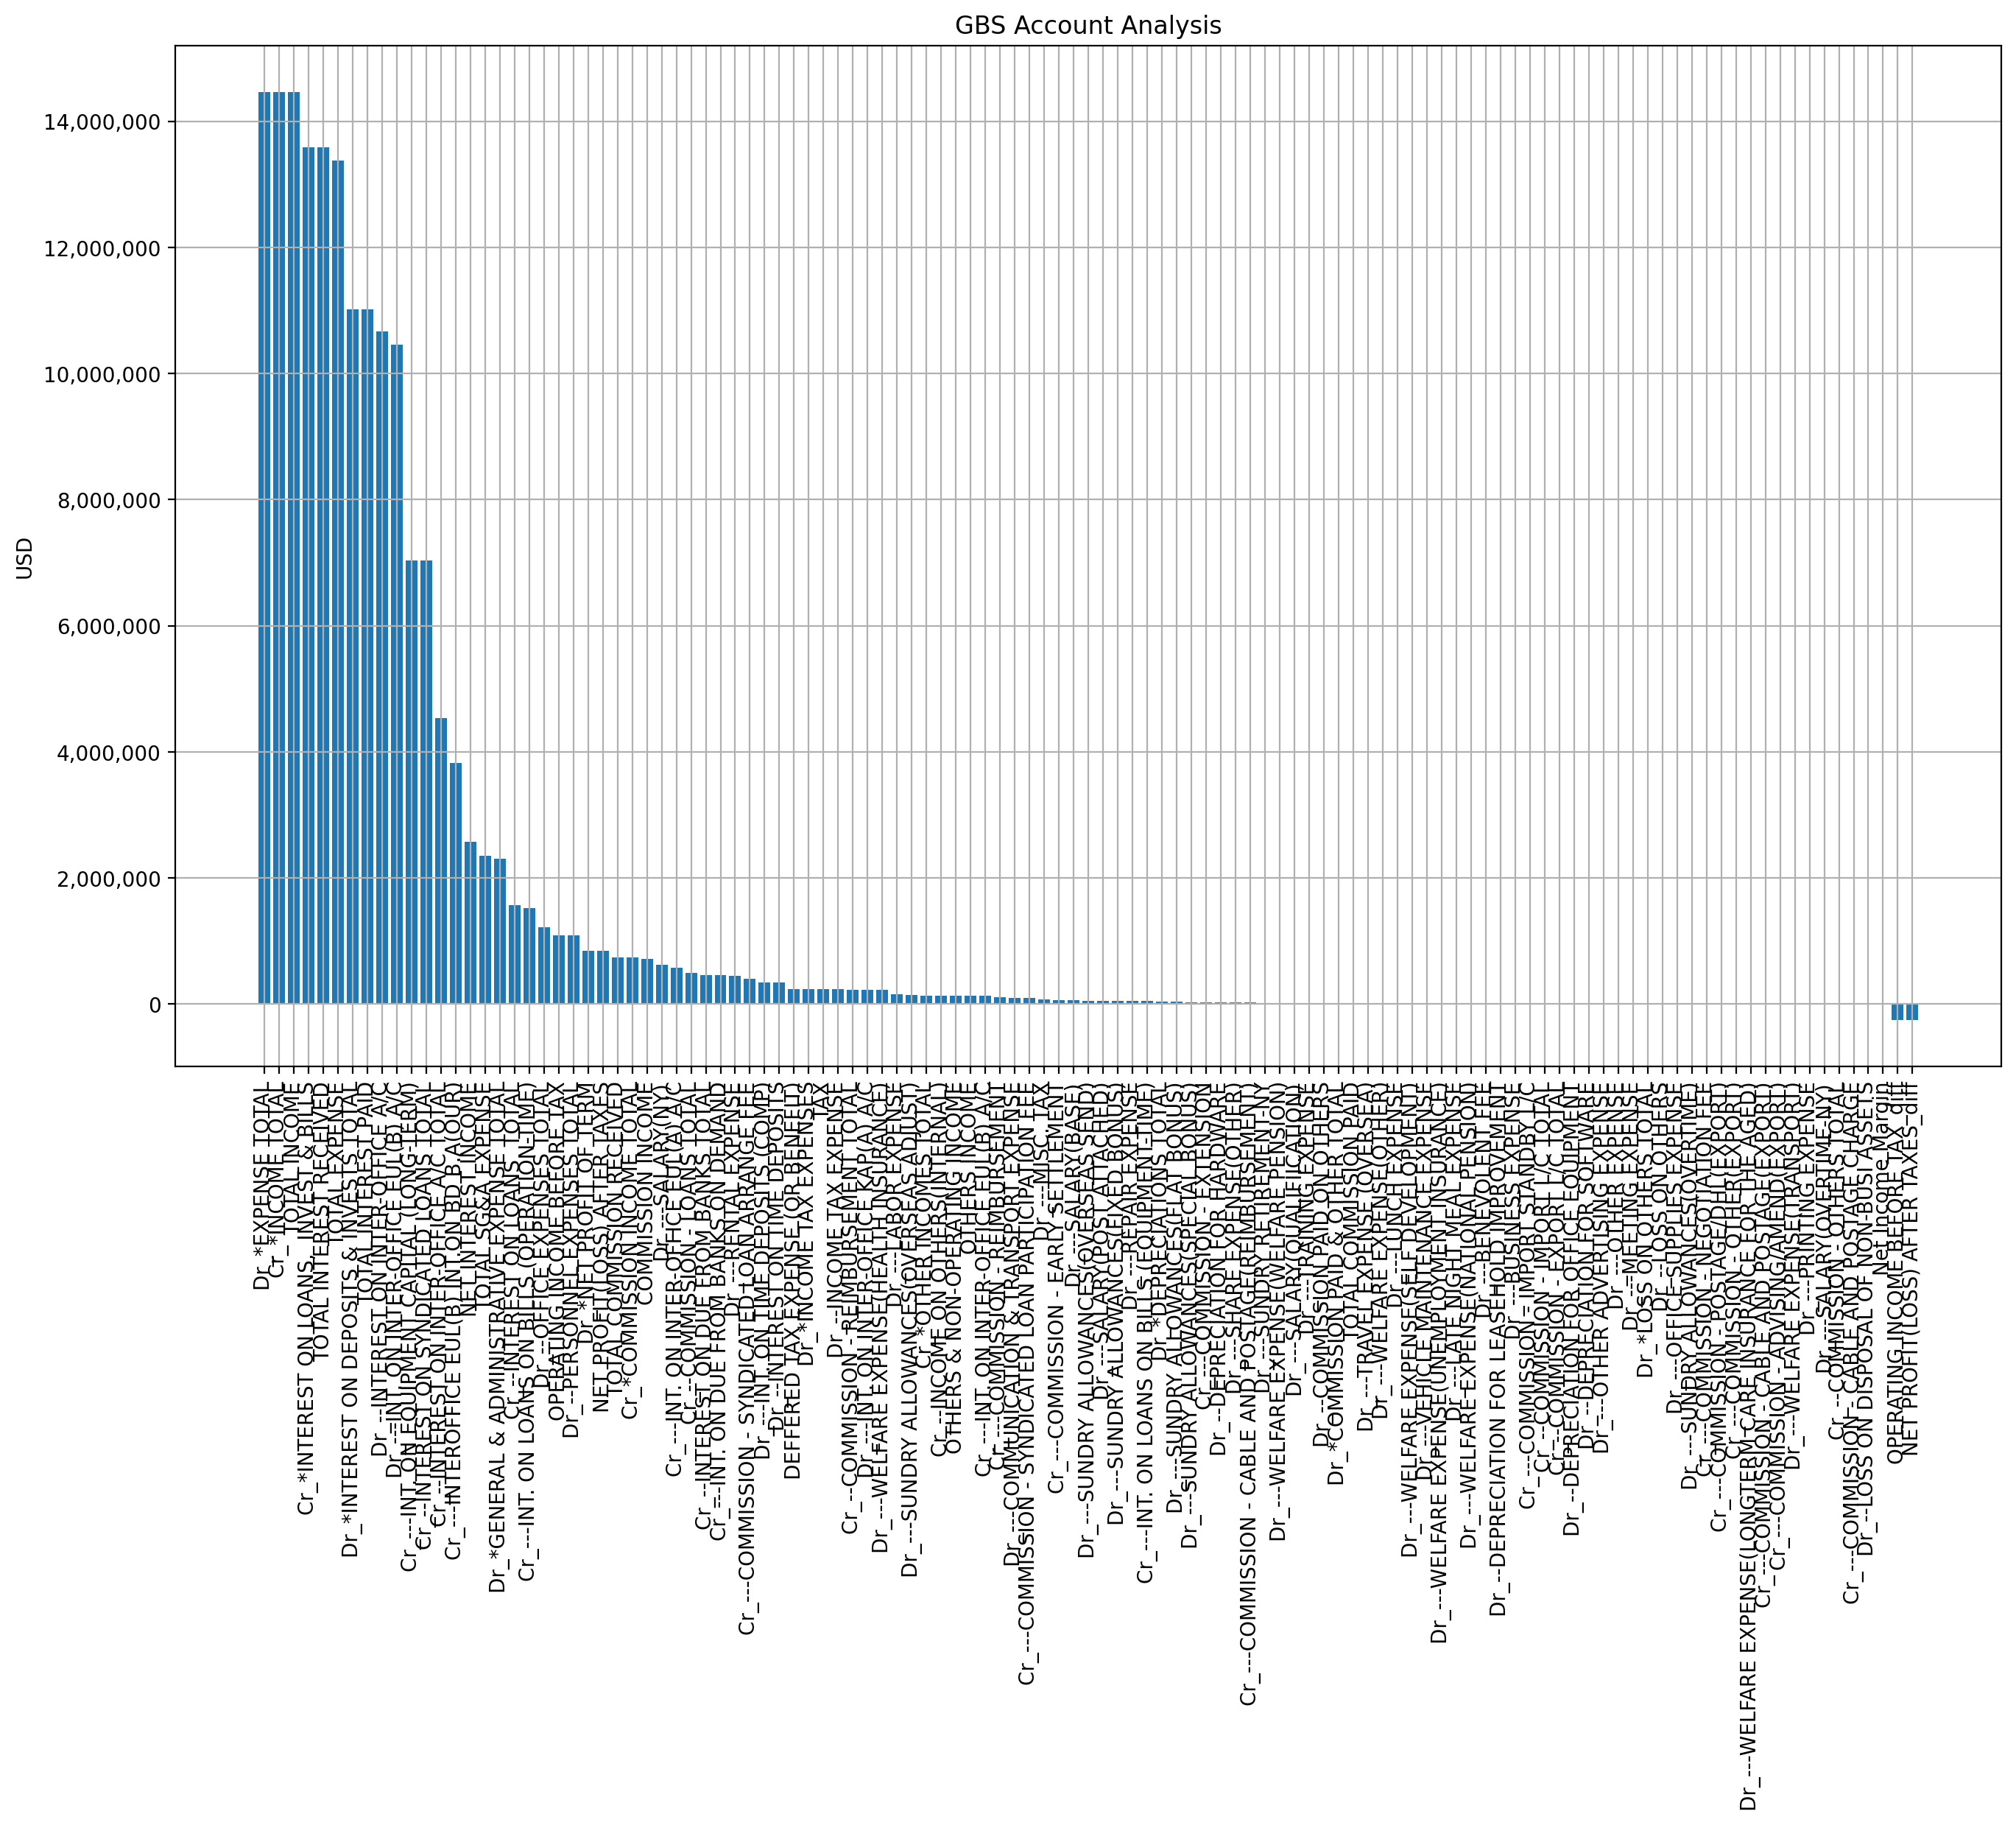

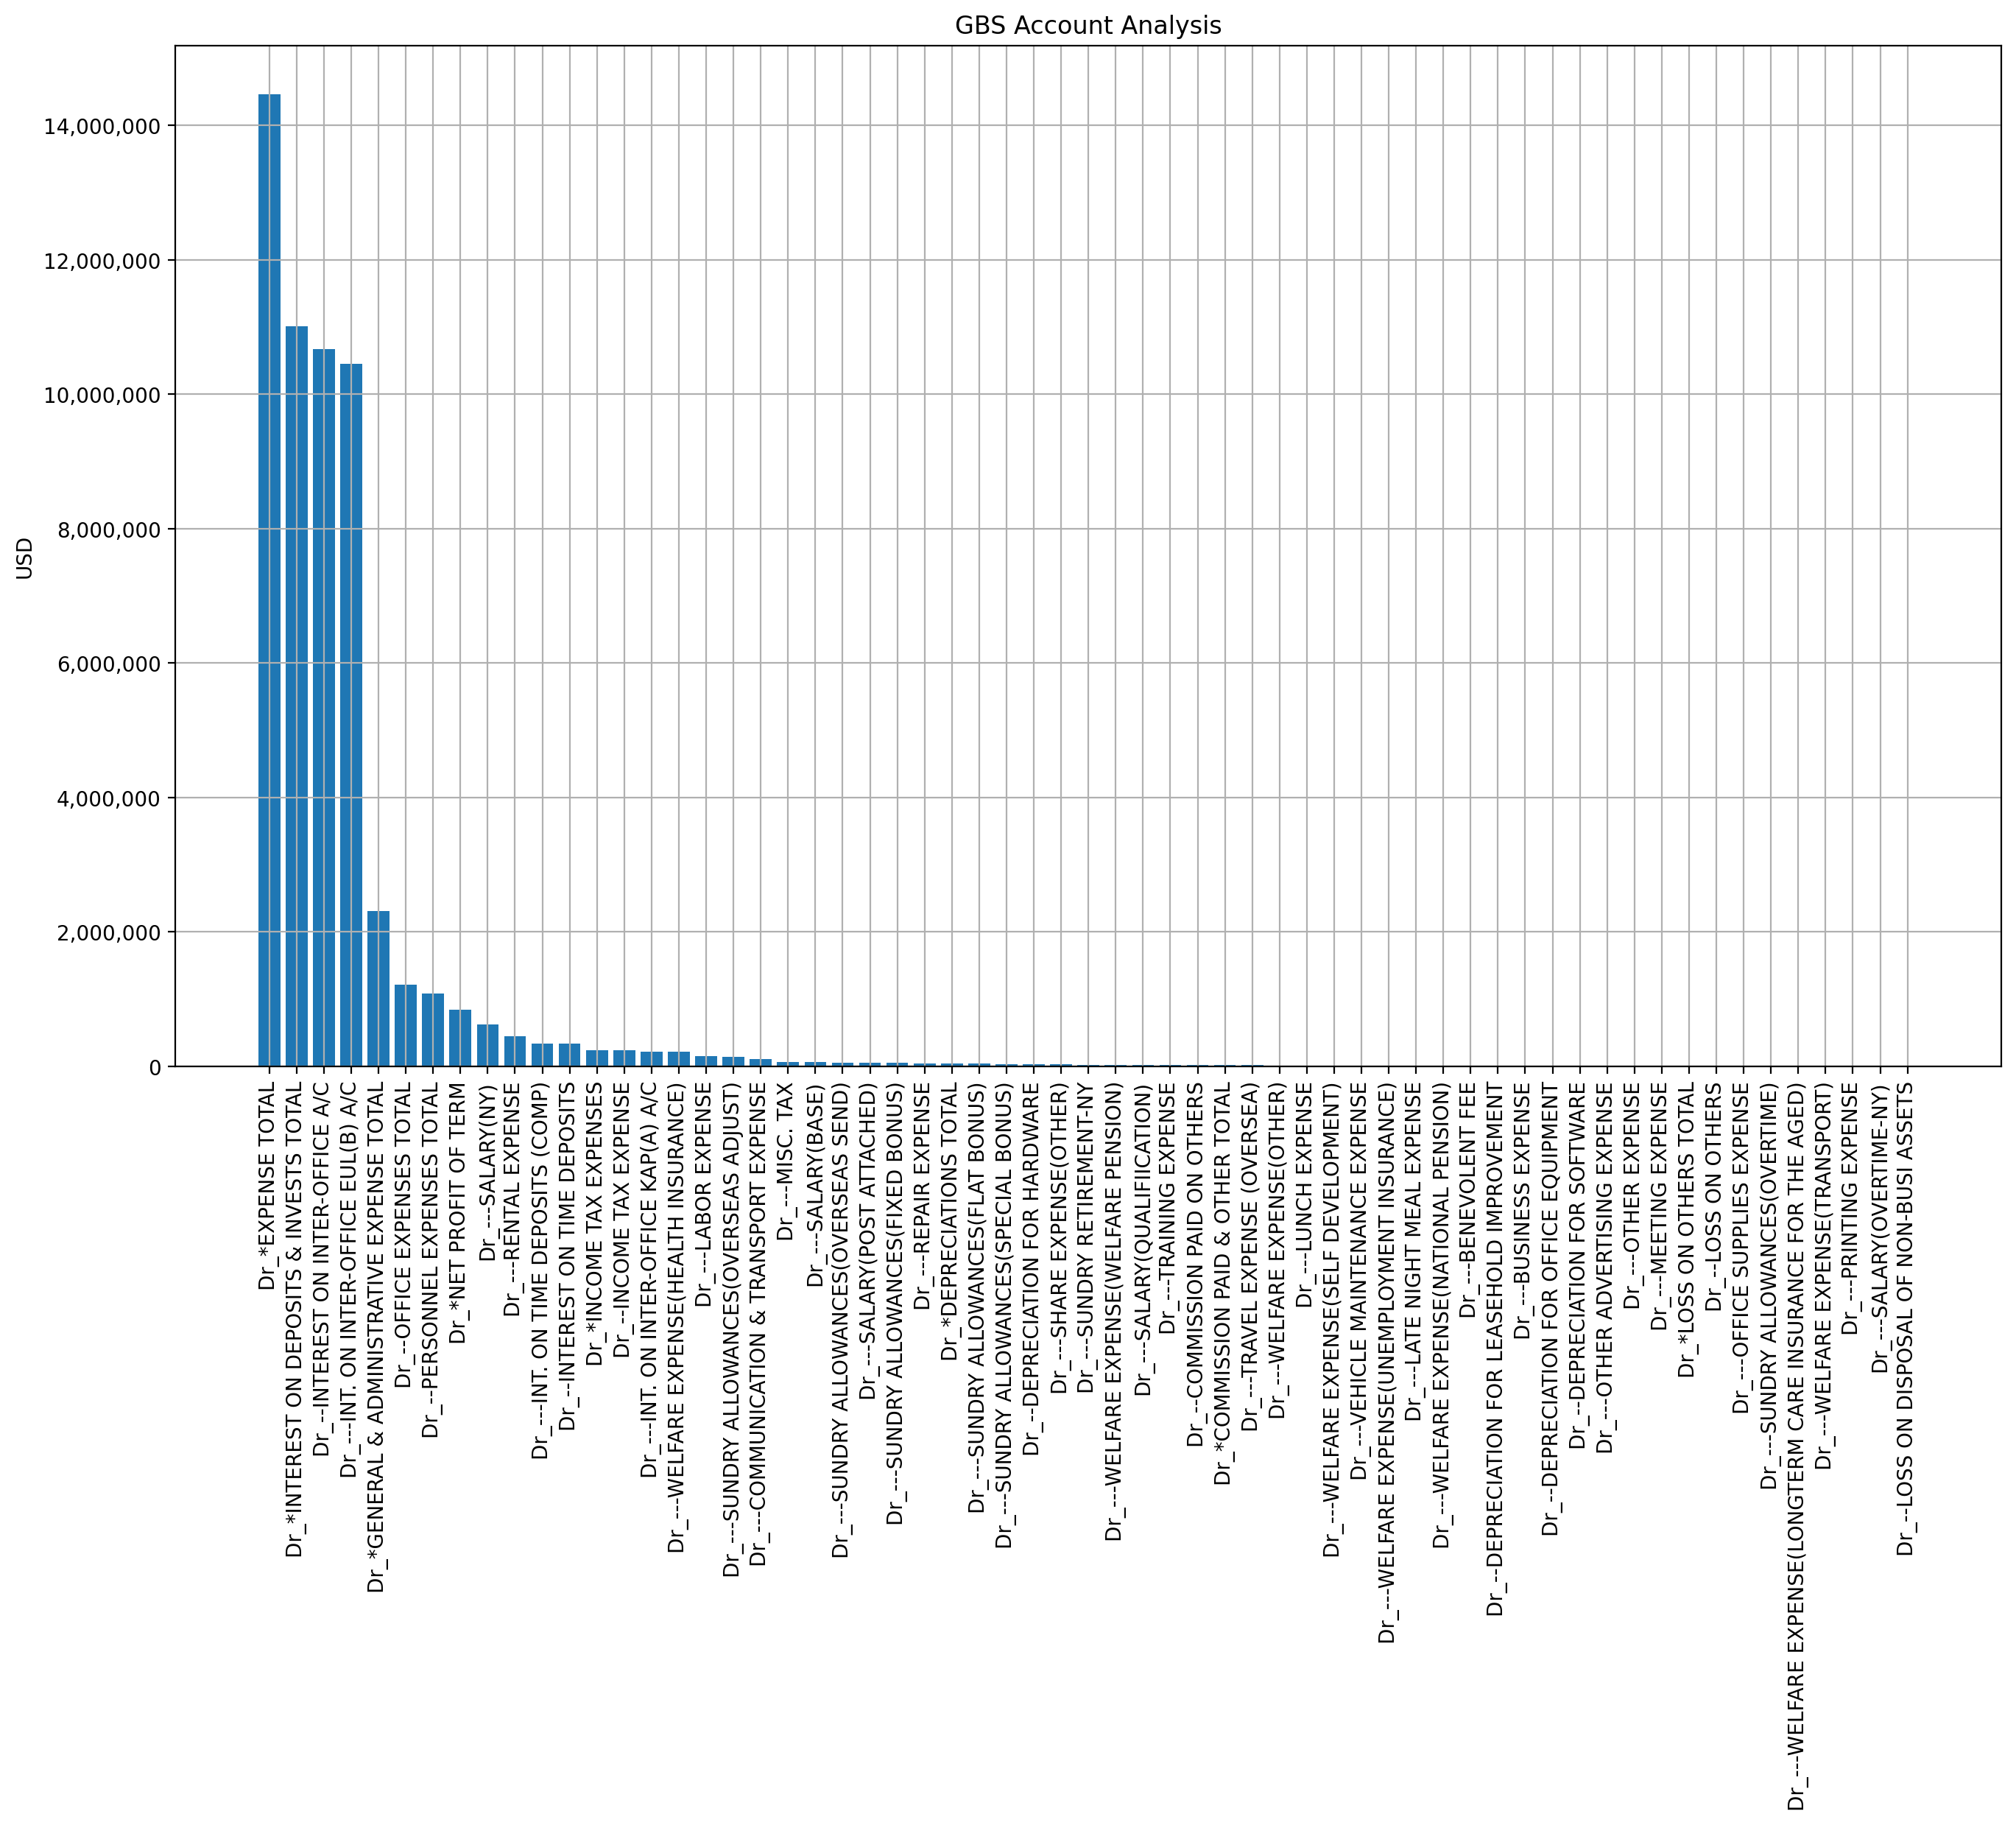

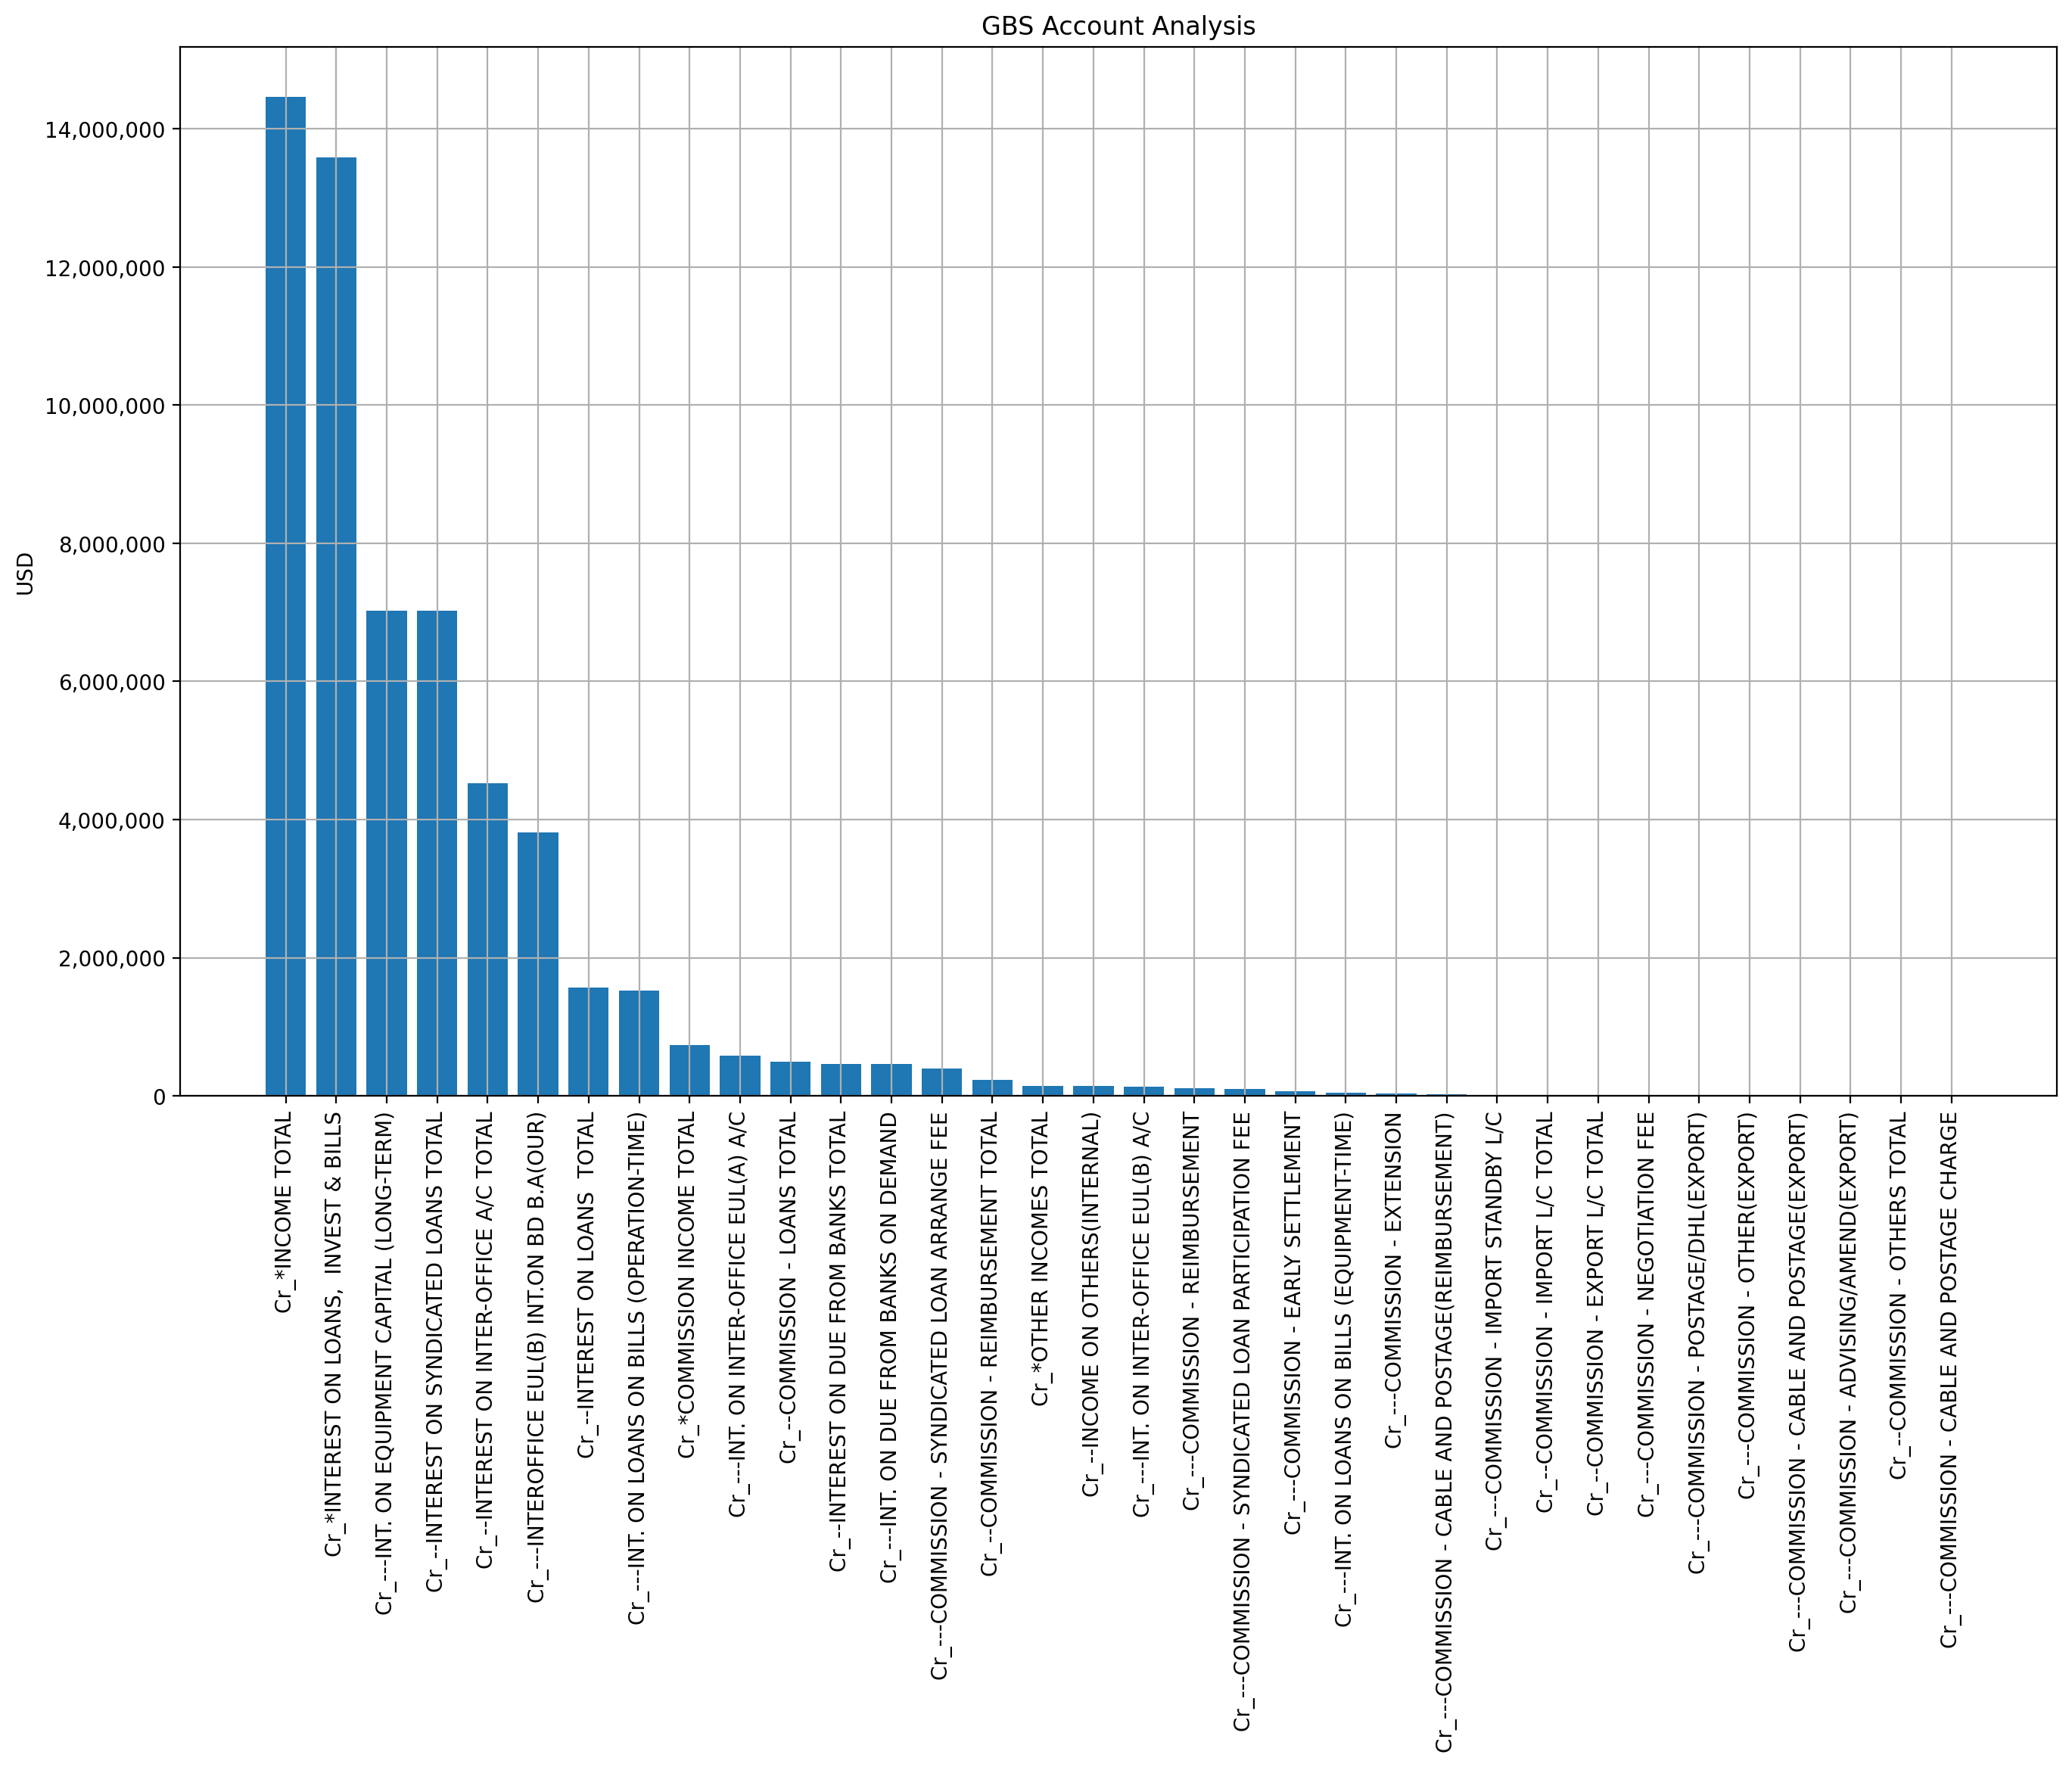

In [82]:
pl = pl_all.copy()
df, dr, cr, processed = processing_bar('pl', pl, '2023-07-01')
plot_bar(df)
plot_bar(dr)
plot_bar(cr)

### Analysis for Diff

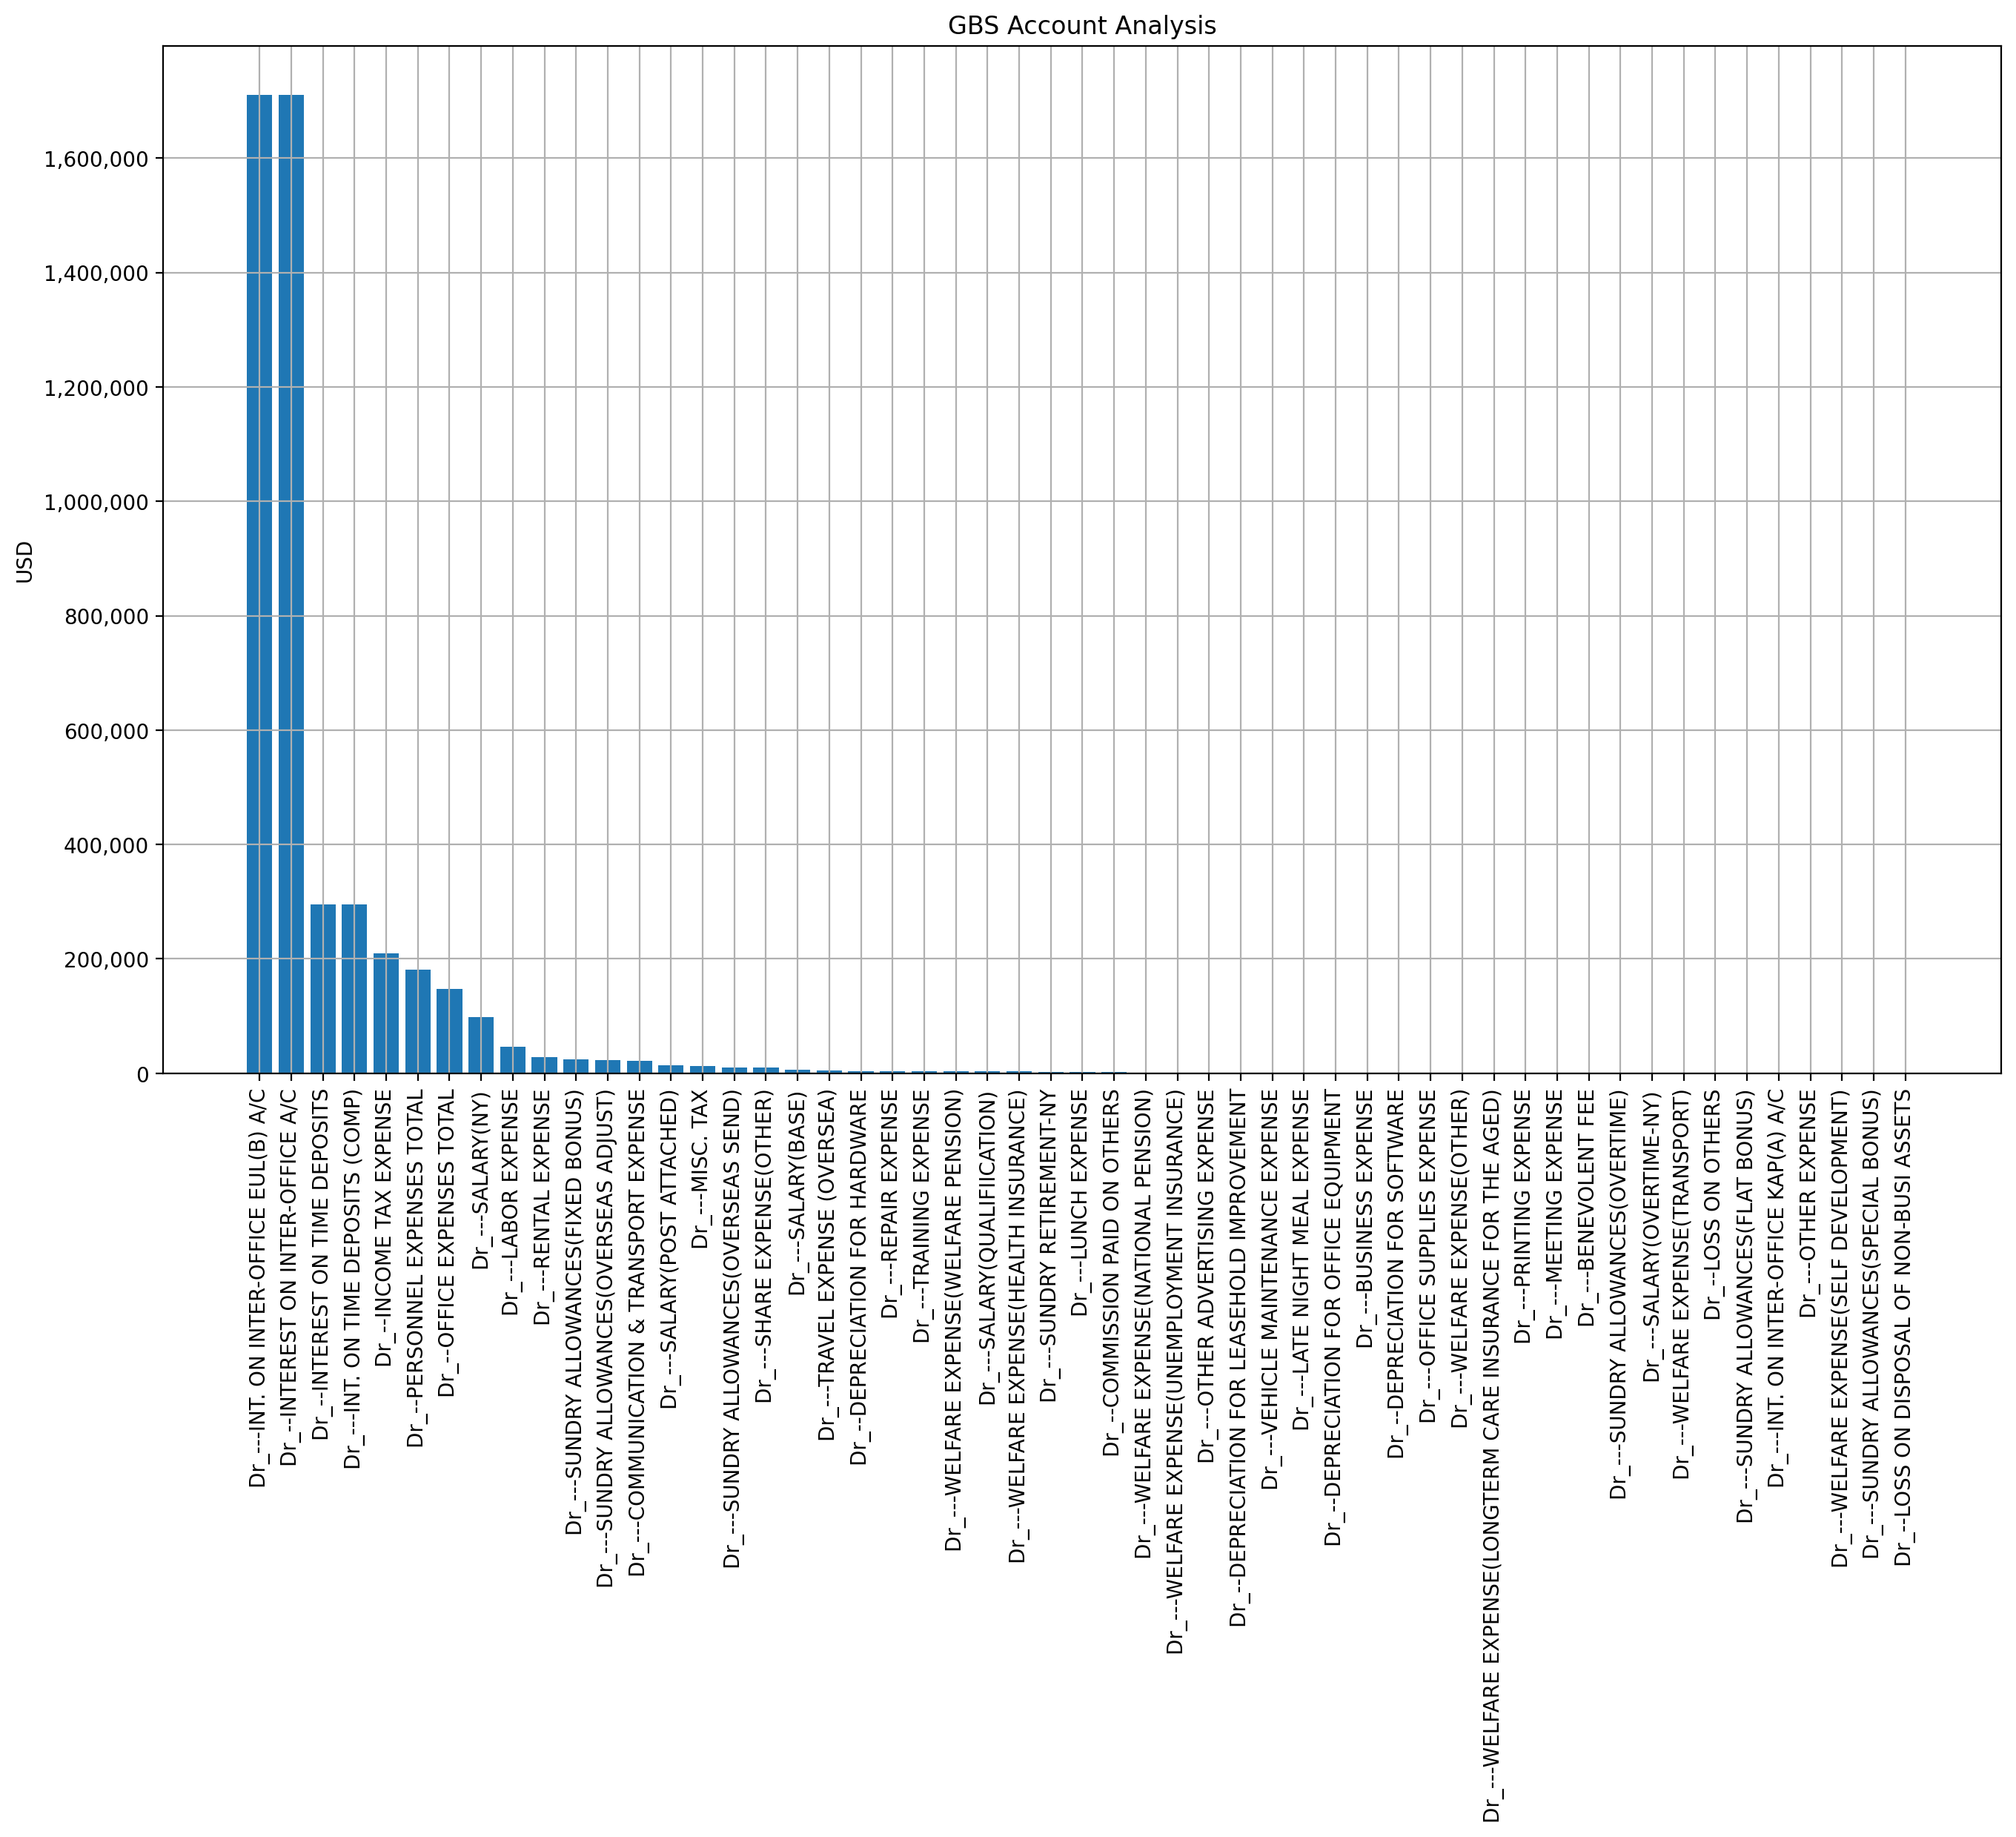

In [85]:
diff_bar('pl', '2023-06-03', '2023-07-01', 'dr')

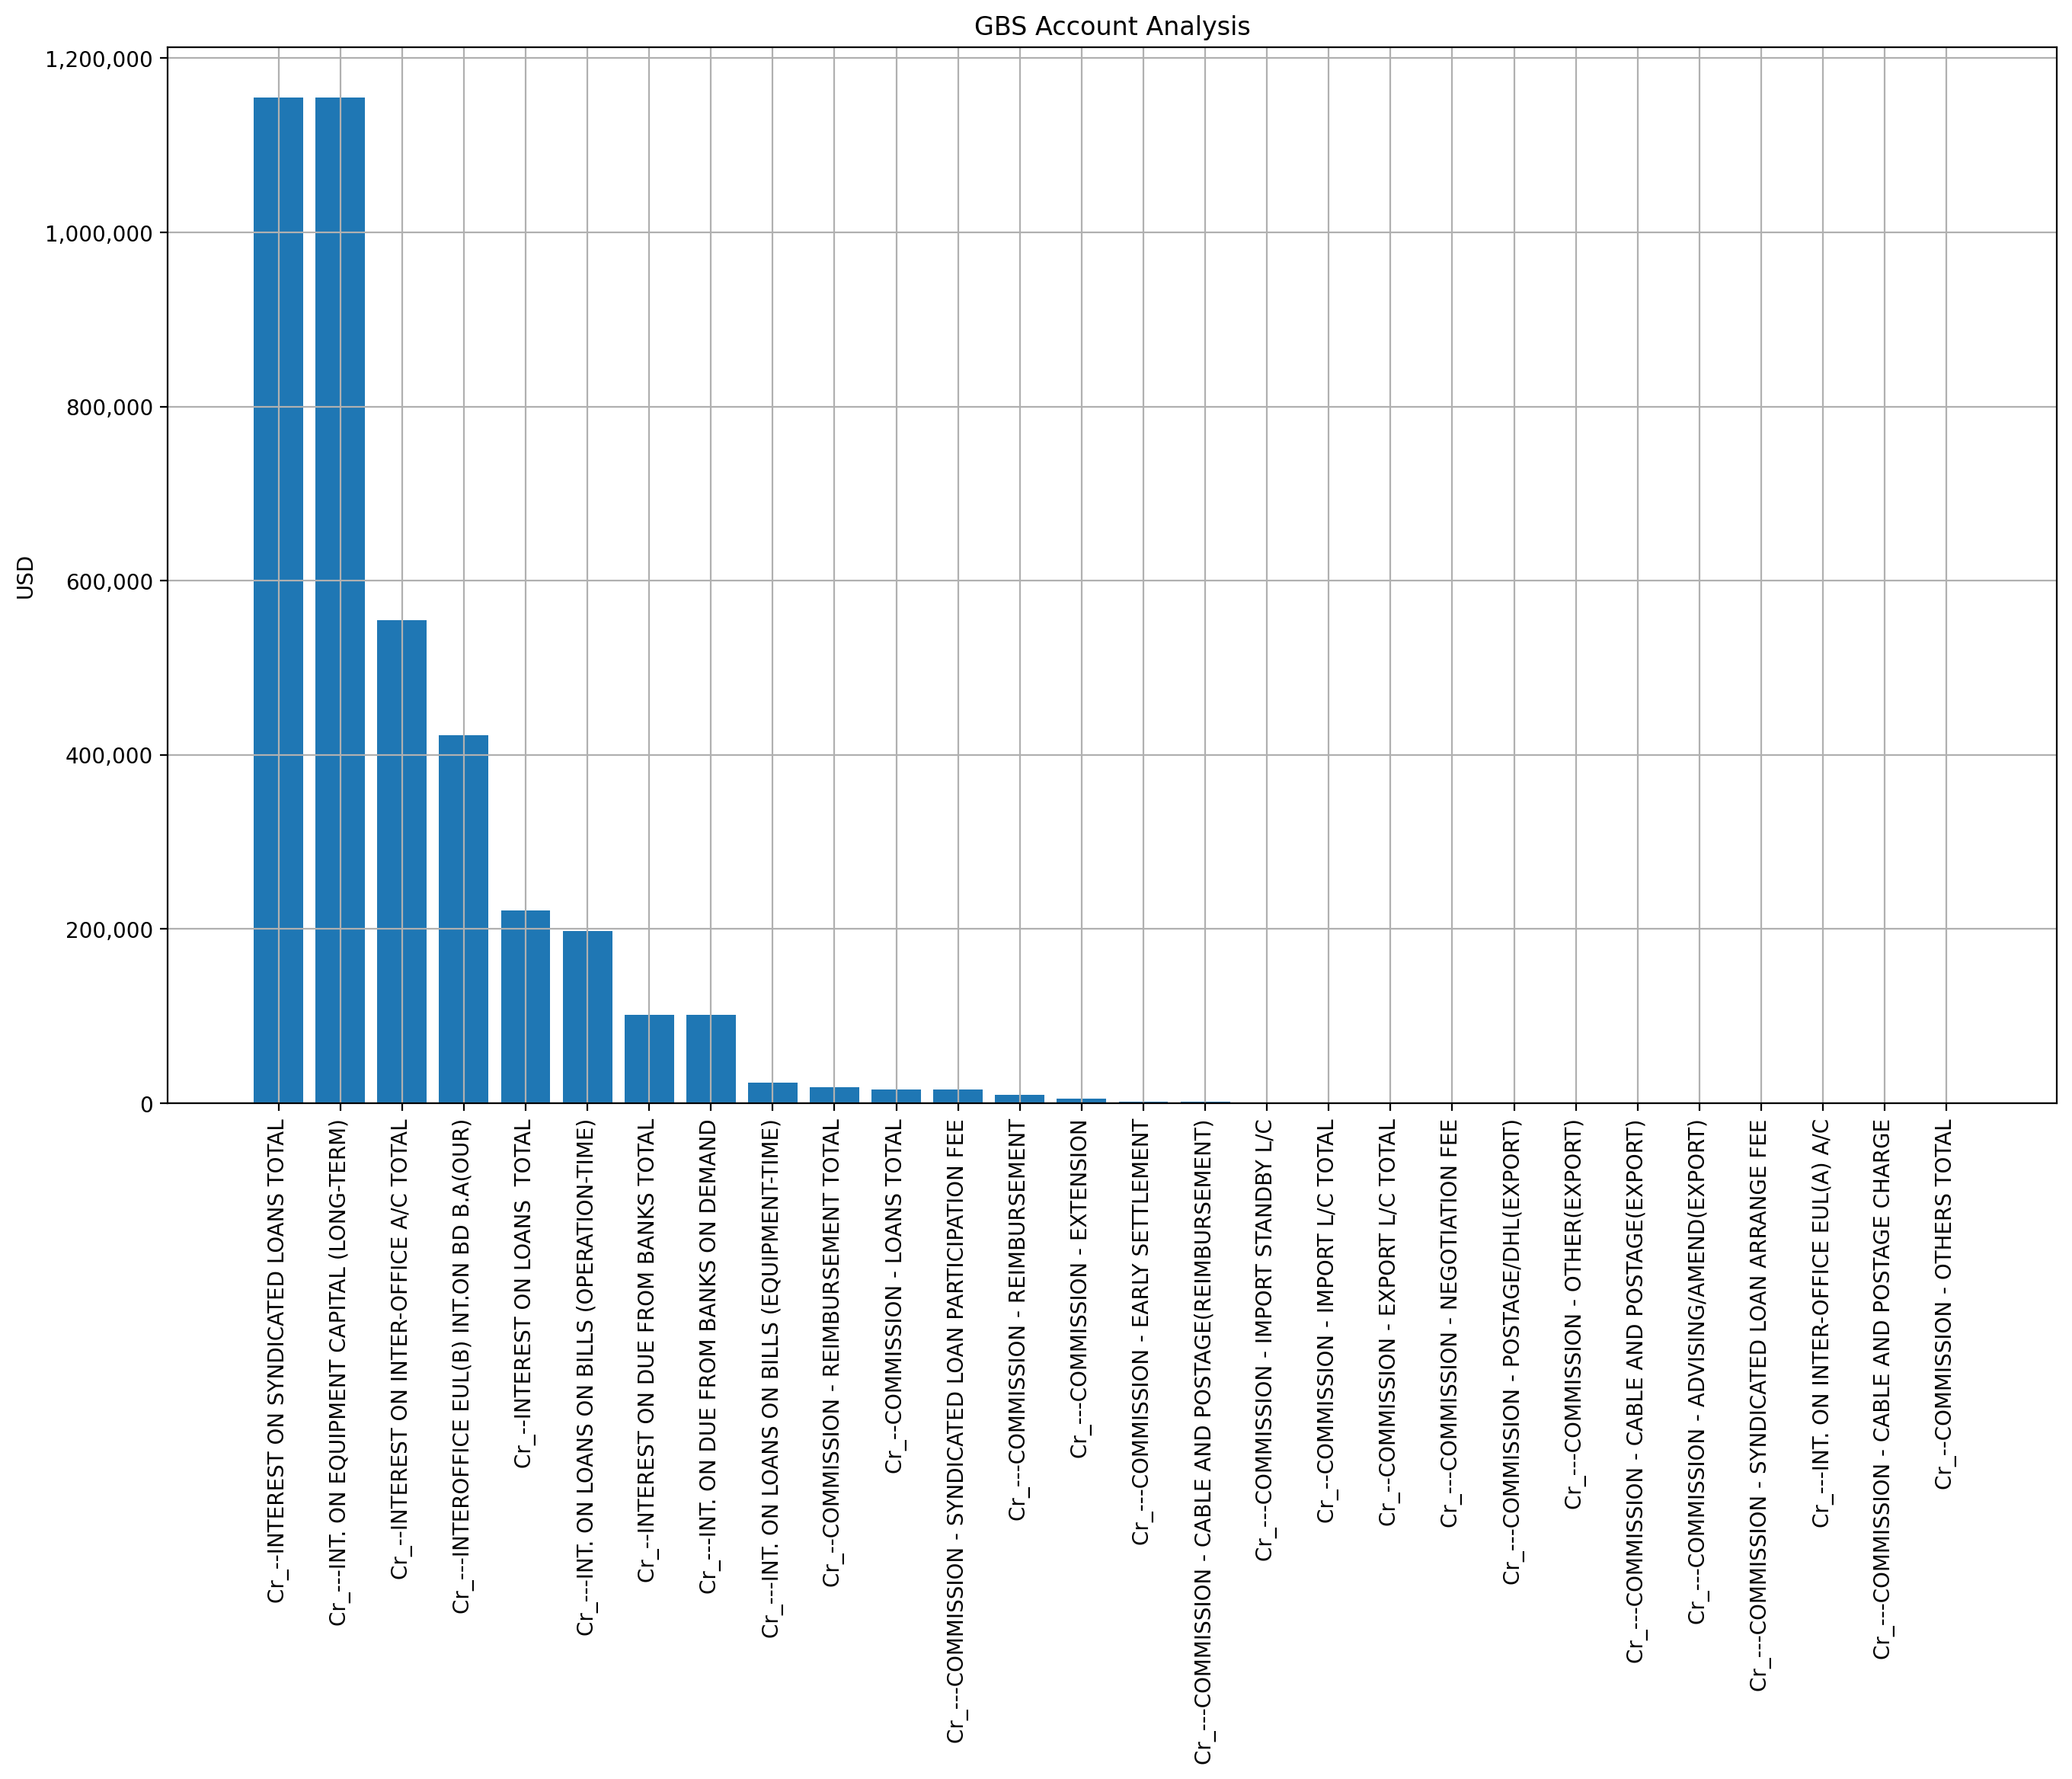

In [86]:
diff_bar('pl', '2023-06-03', '2023-07-01', 'cr')

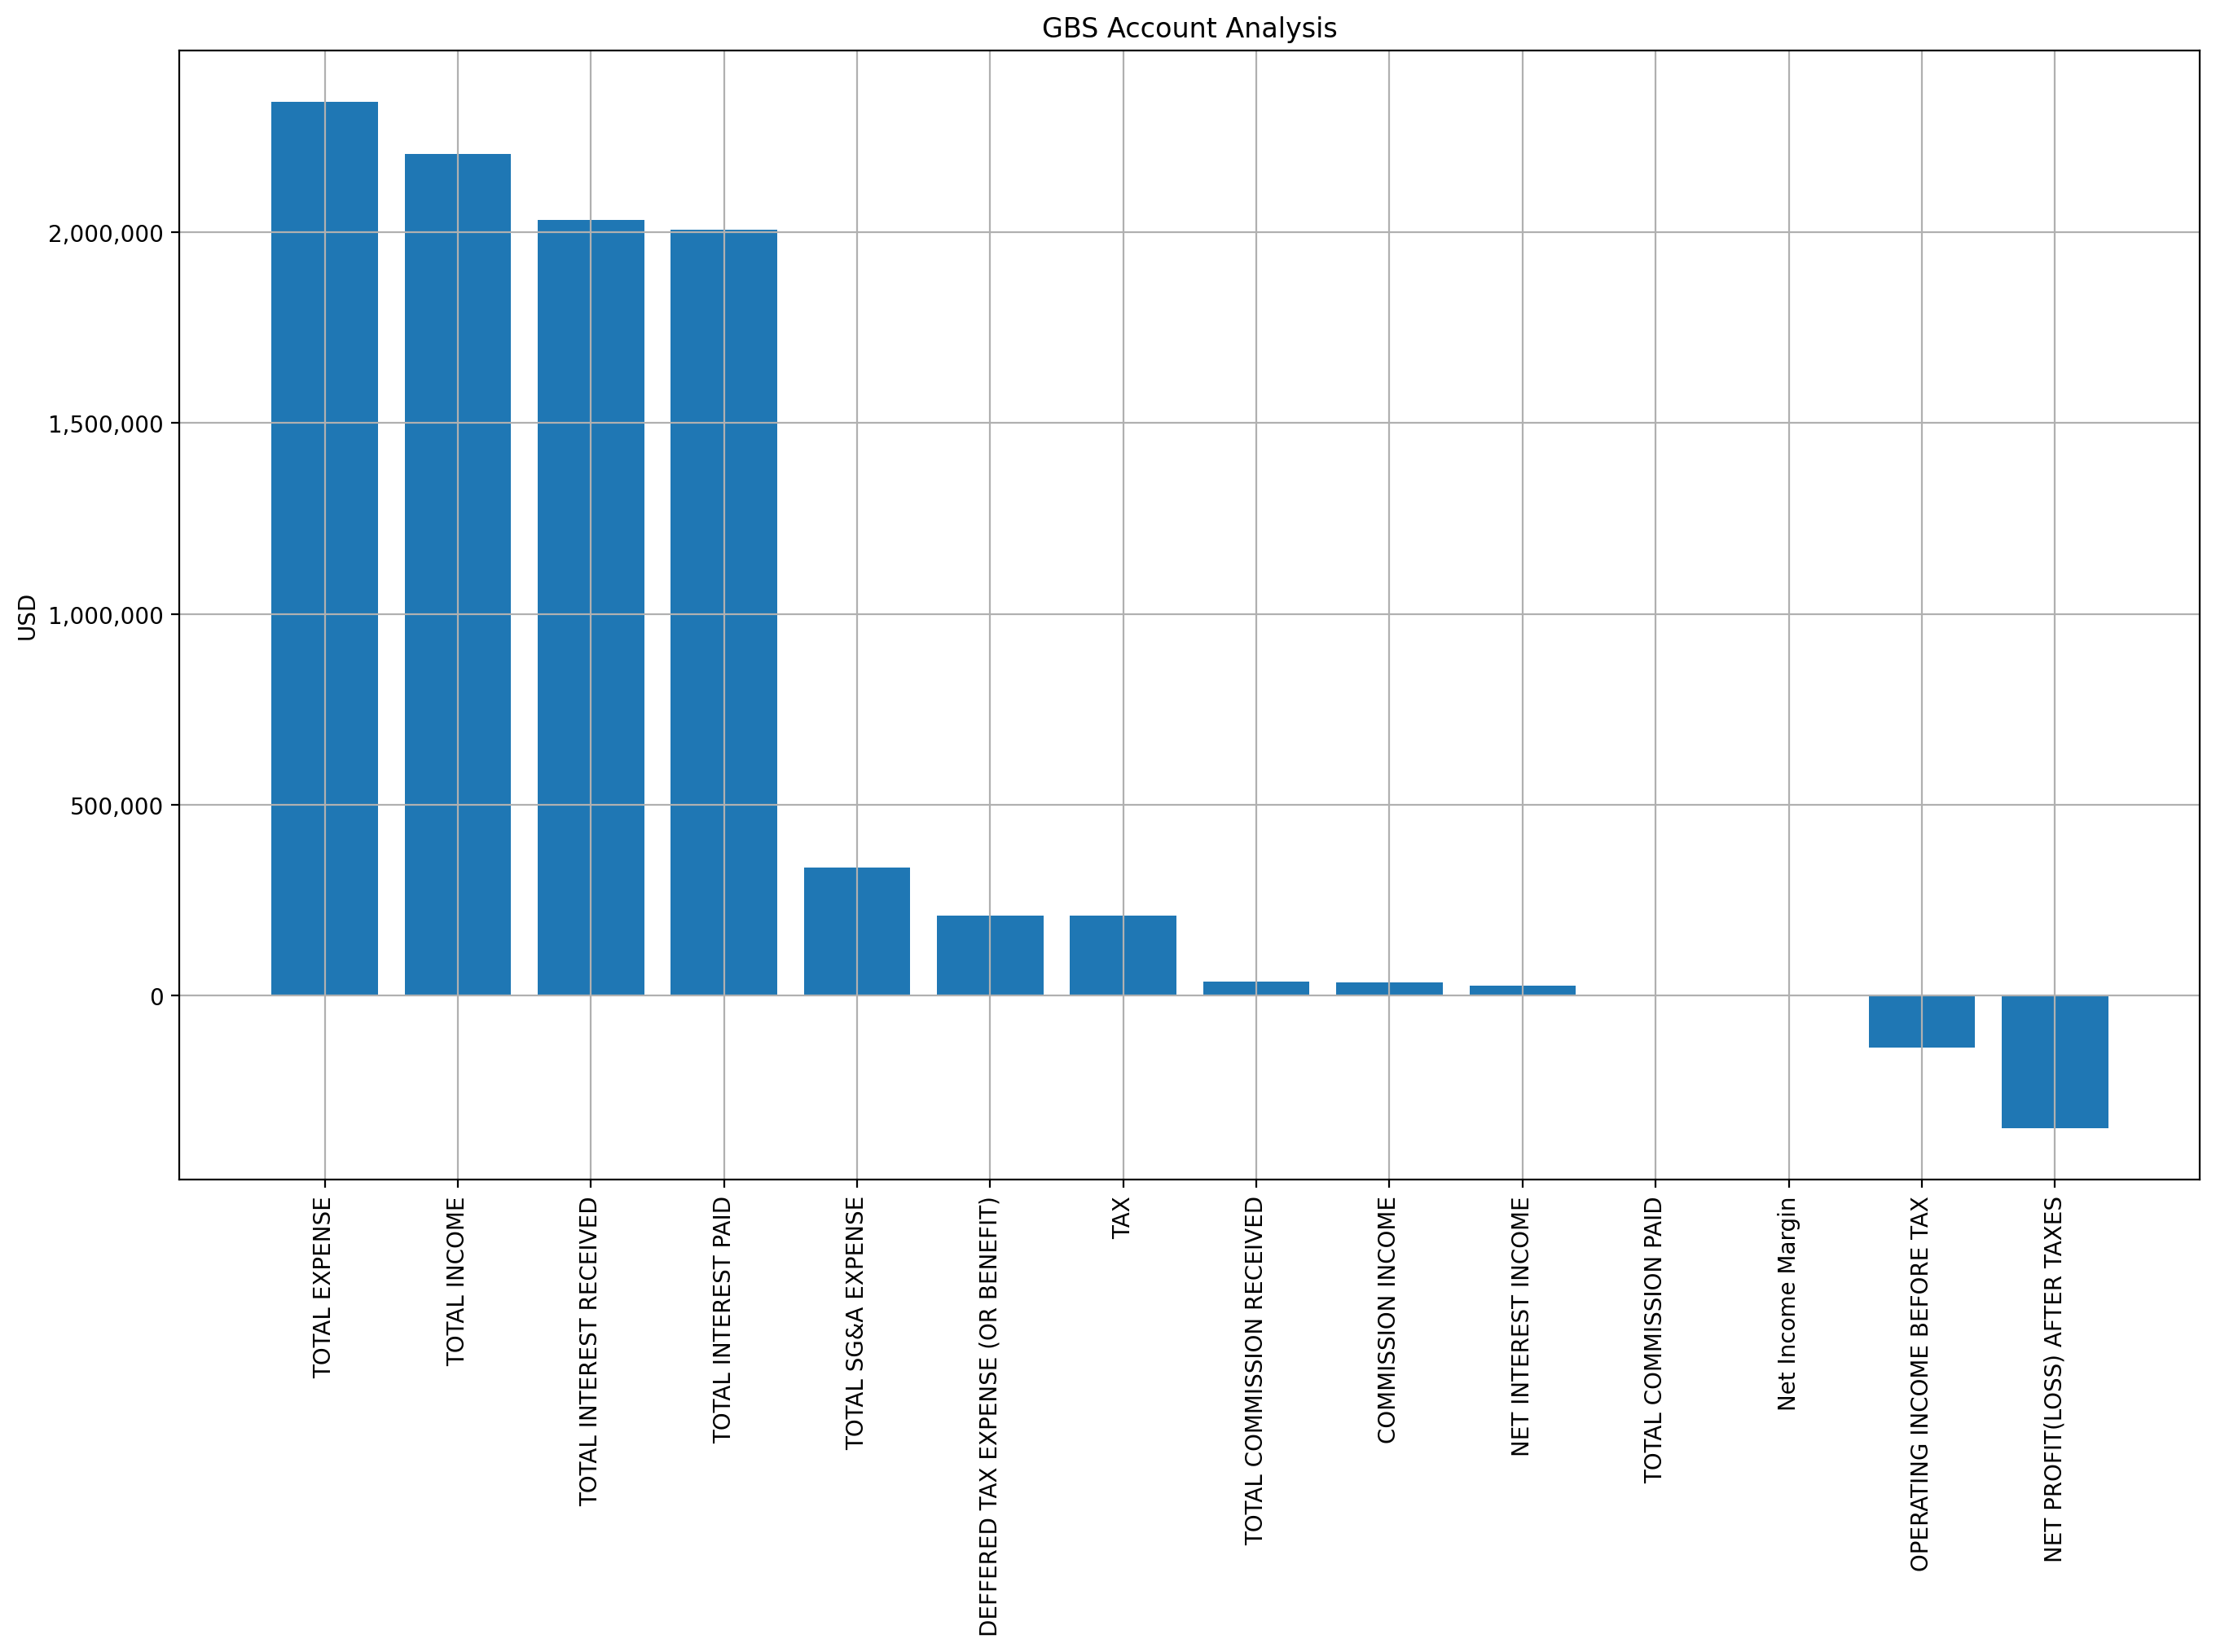

In [87]:
diff_bar('pl', '2023-06-03', '2023-07-01', 'processed')

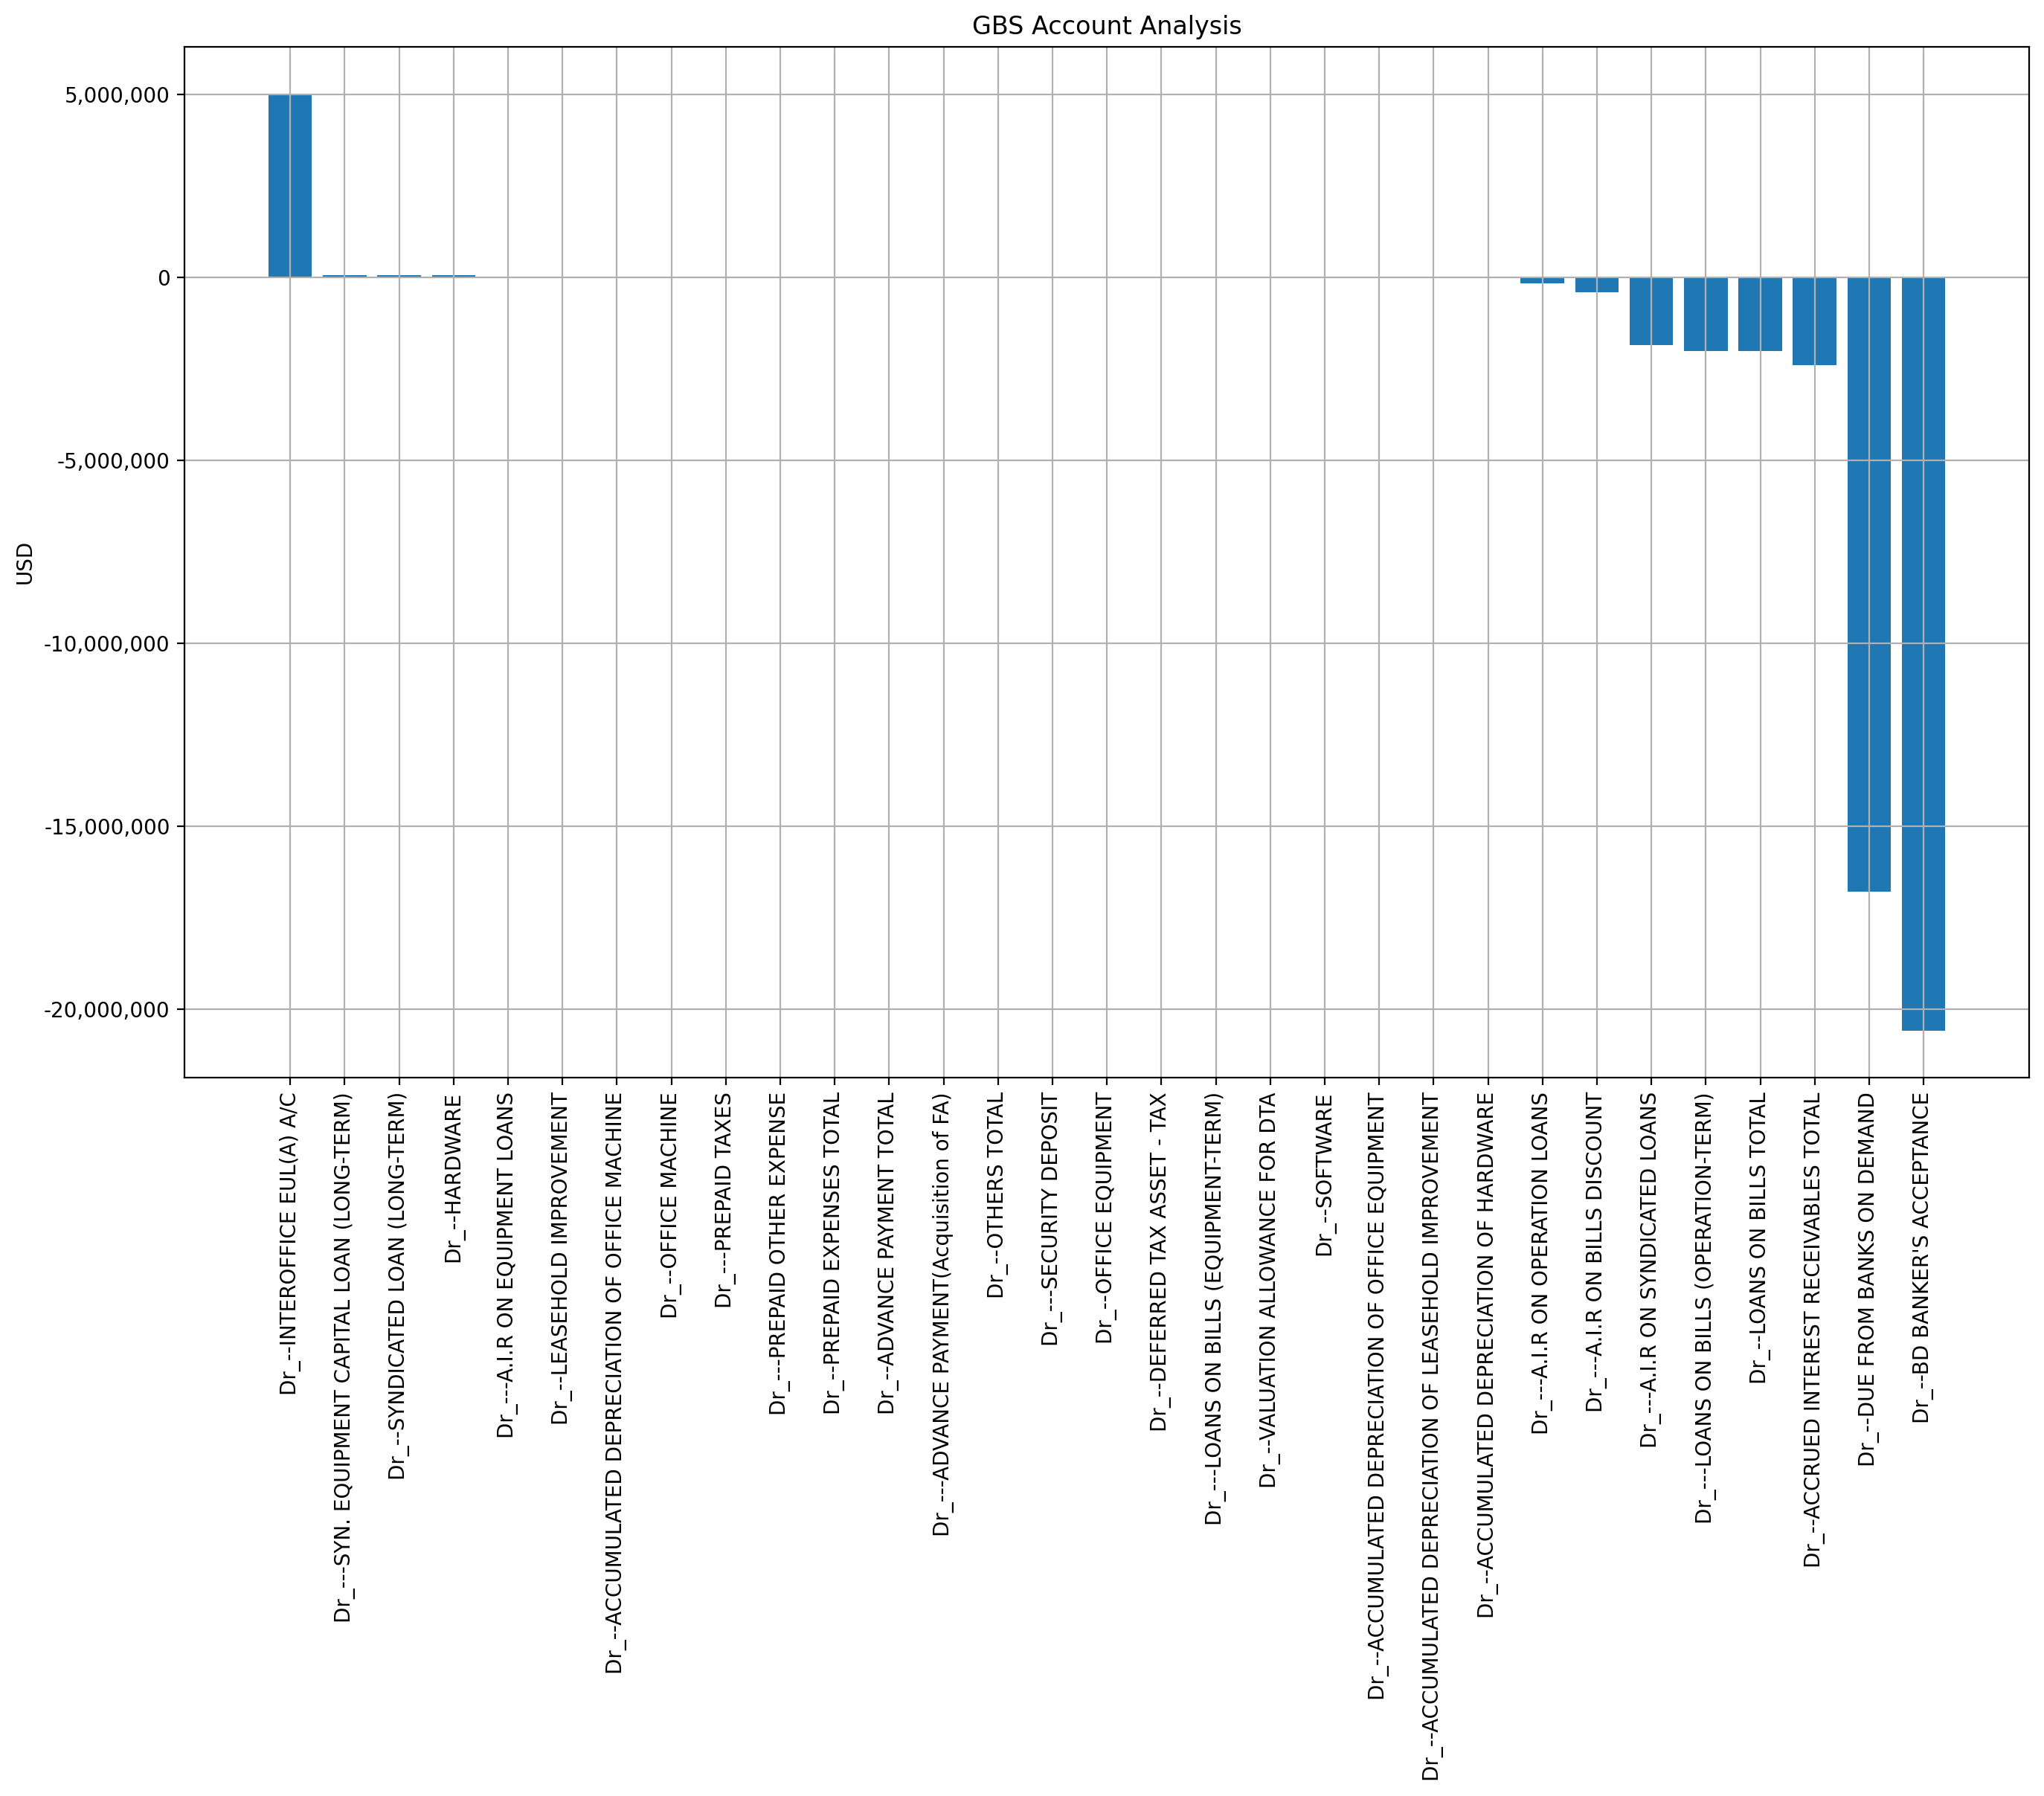

In [90]:
diff_bar('bs', '2023-06-03', '2023-07-01', 'dr')

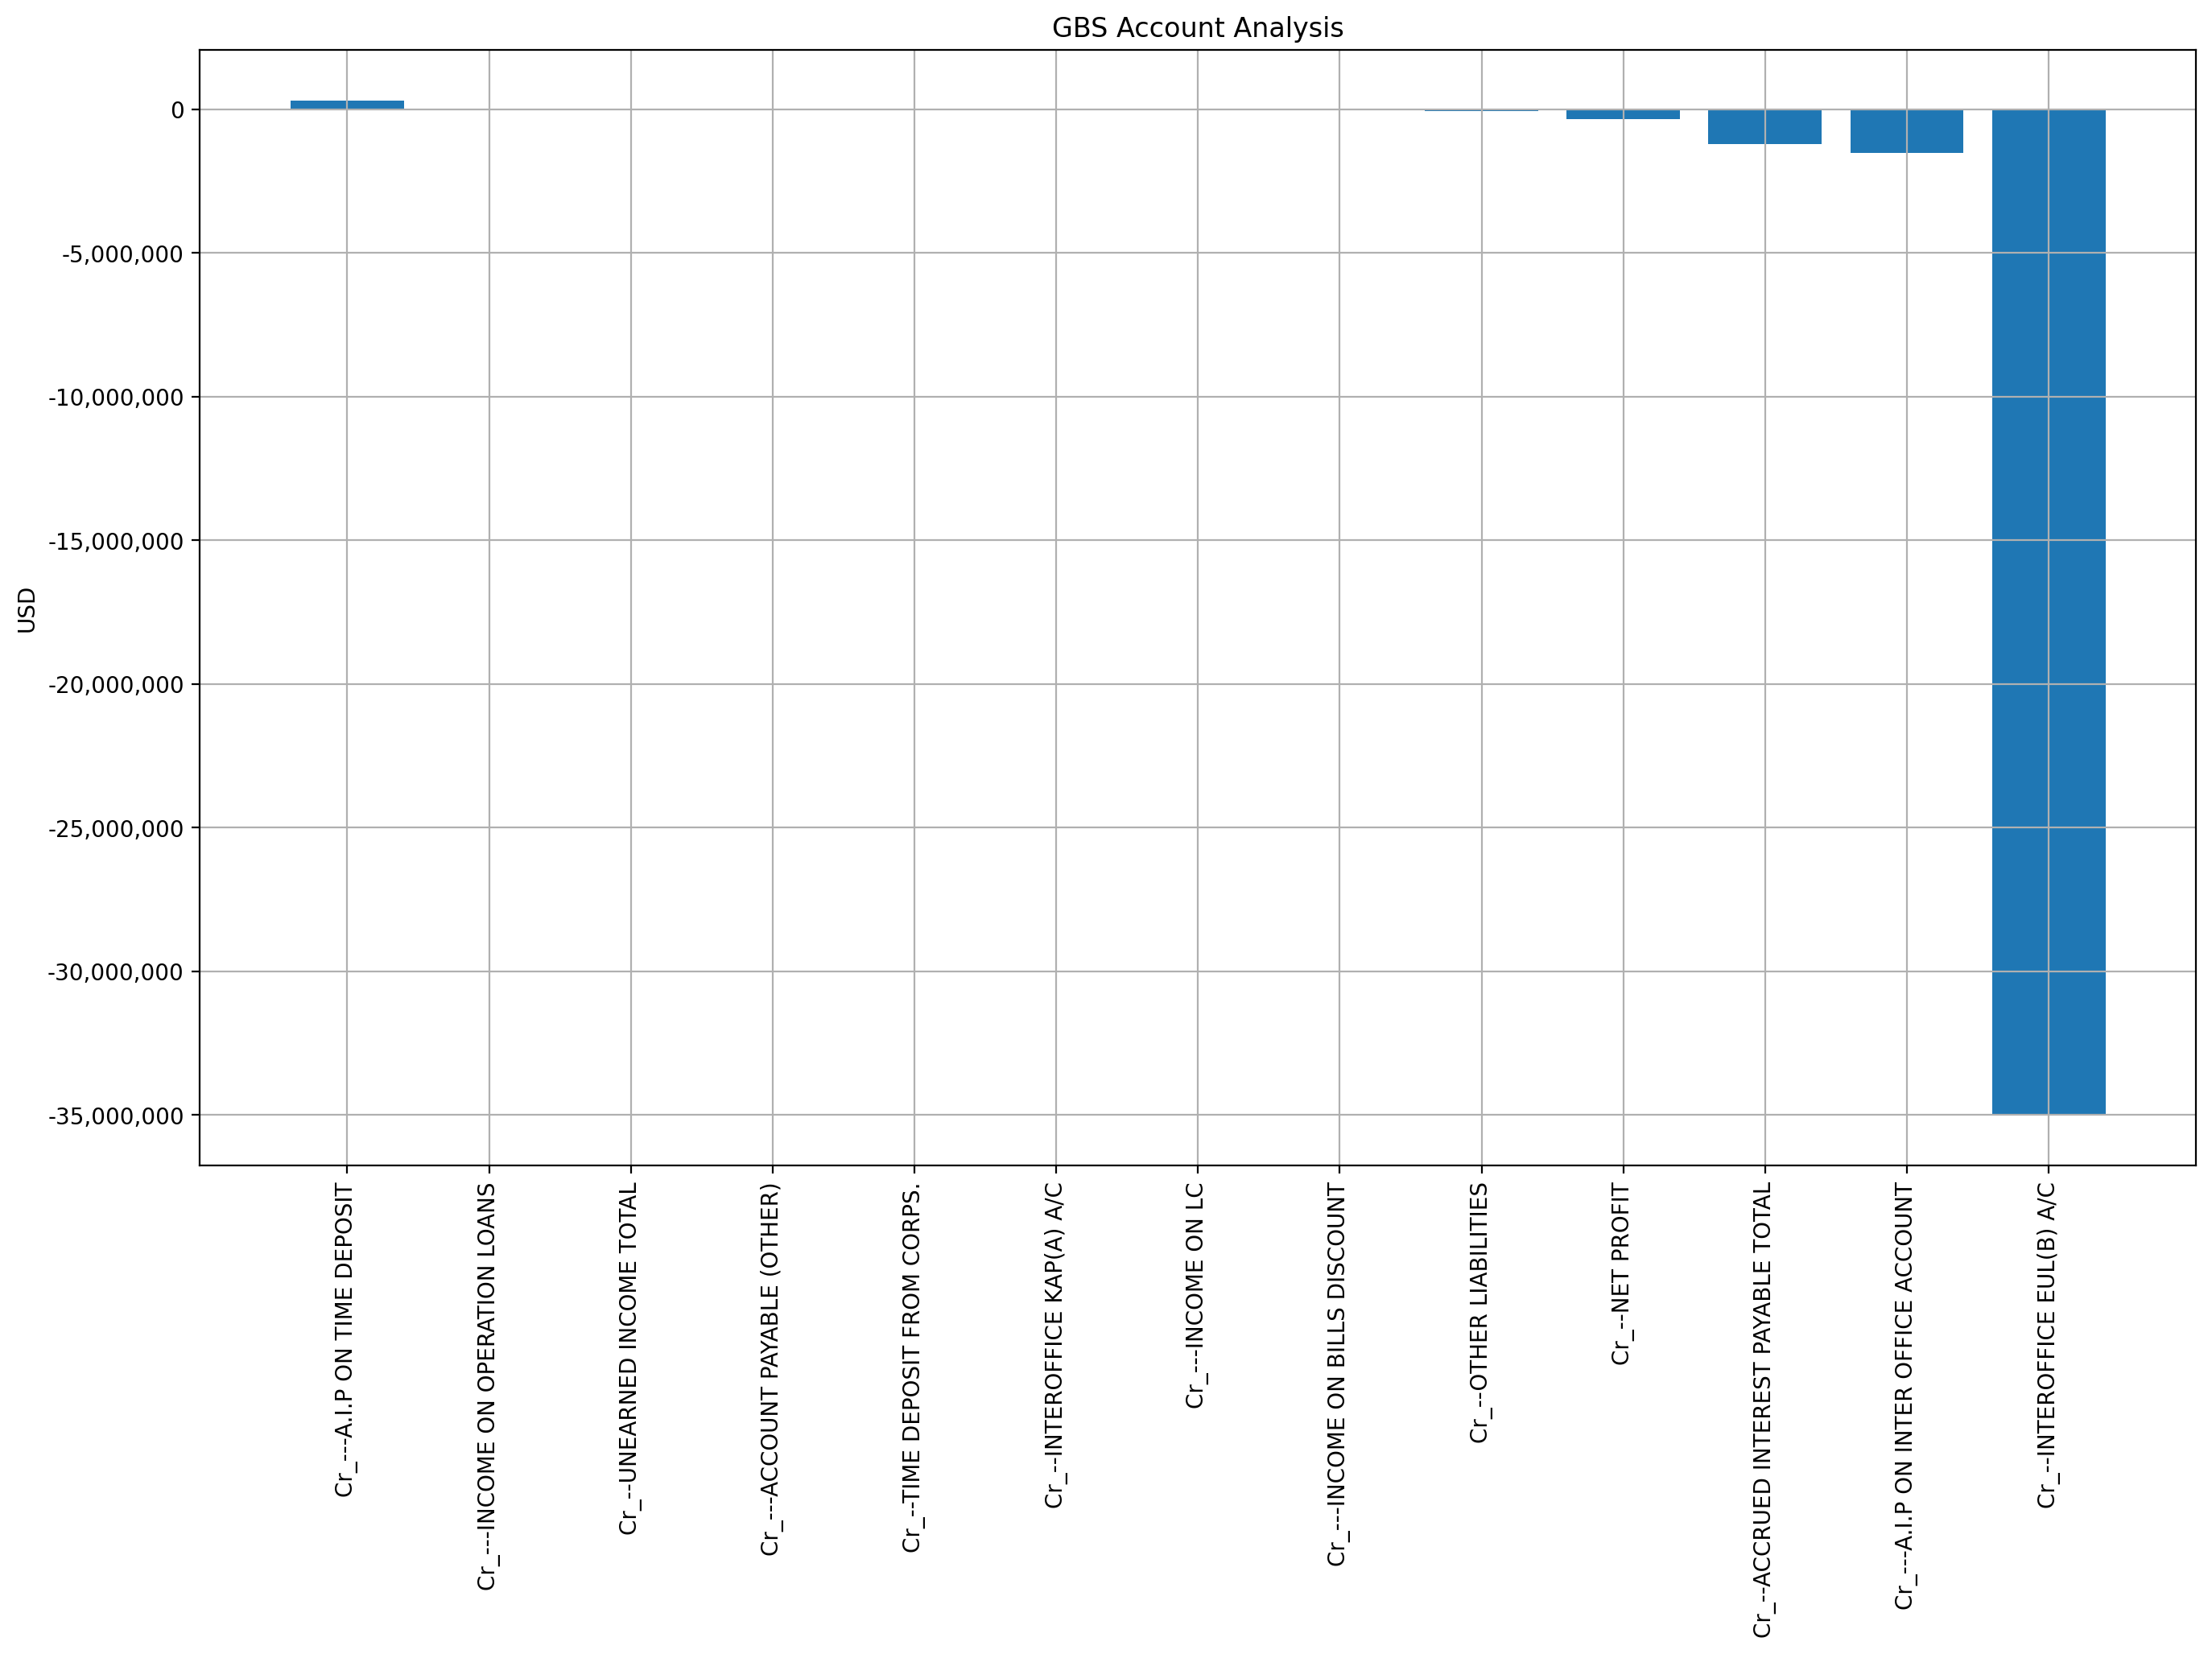

In [91]:
diff_bar('bs', '2023-06-03', '2023-07-01', 'cr')

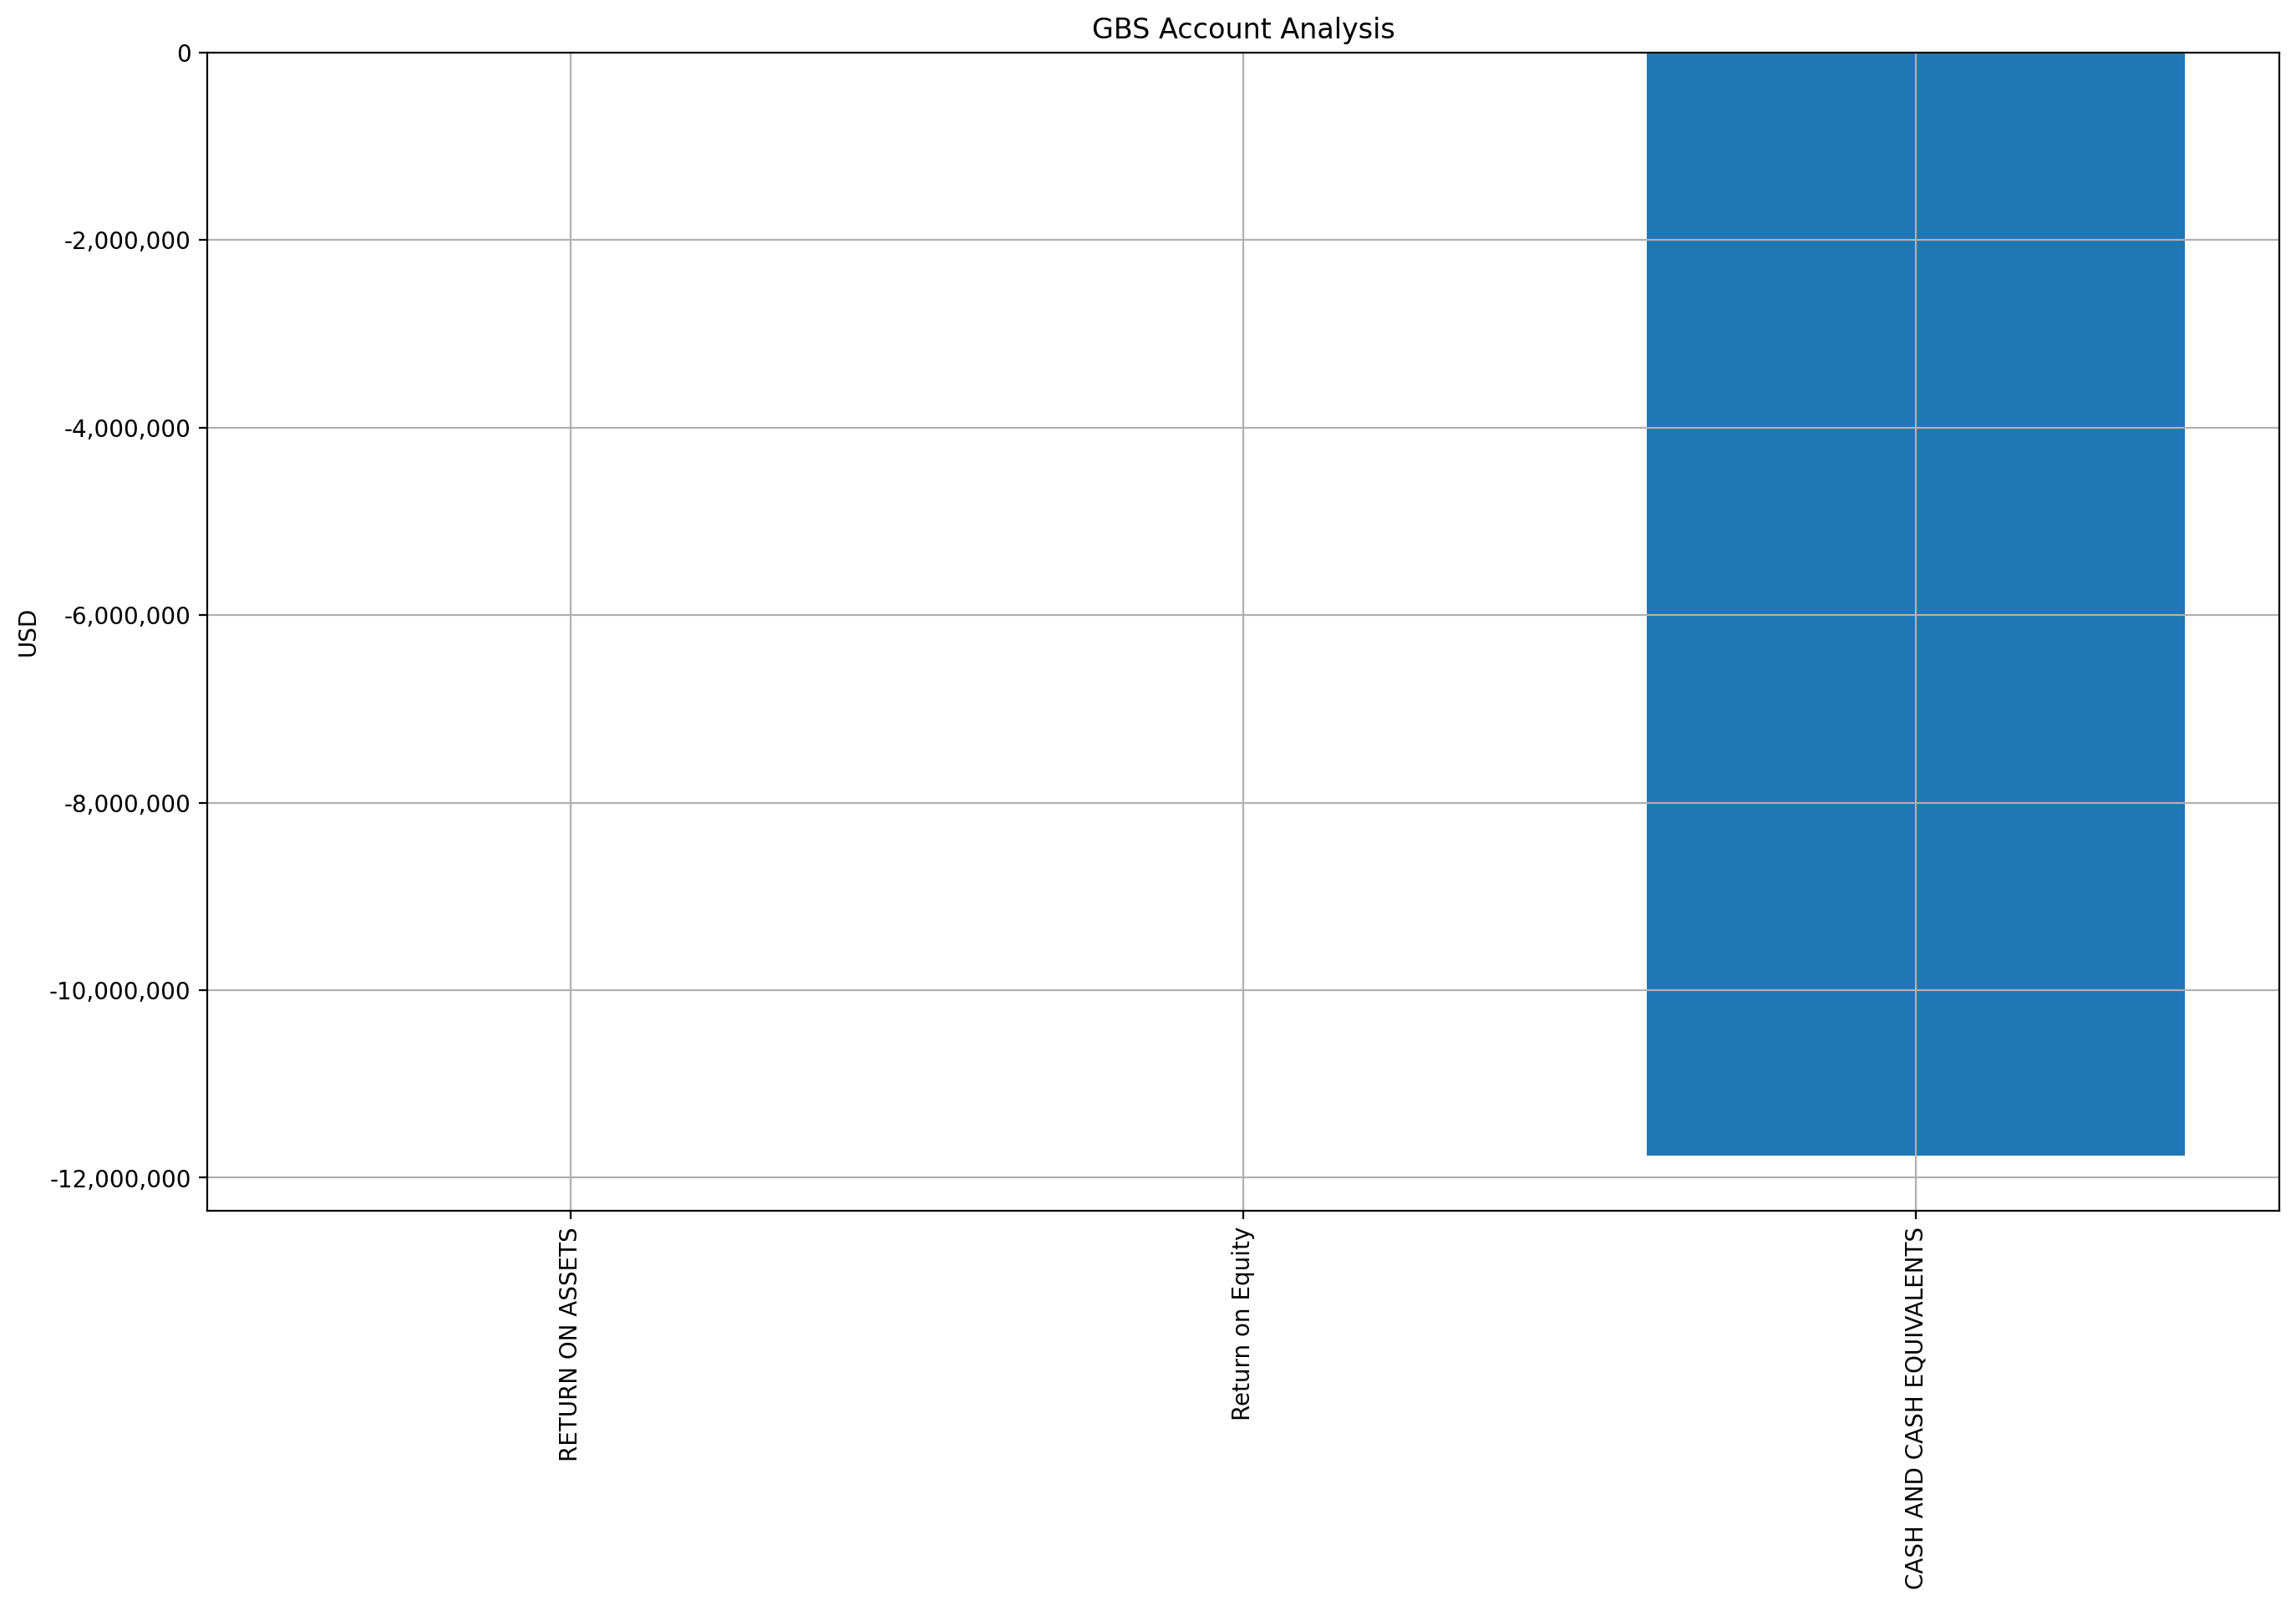

In [92]:
diff_bar('bs', '2023-06-03', '2023-07-01', 'processed')

### Trend Analysis

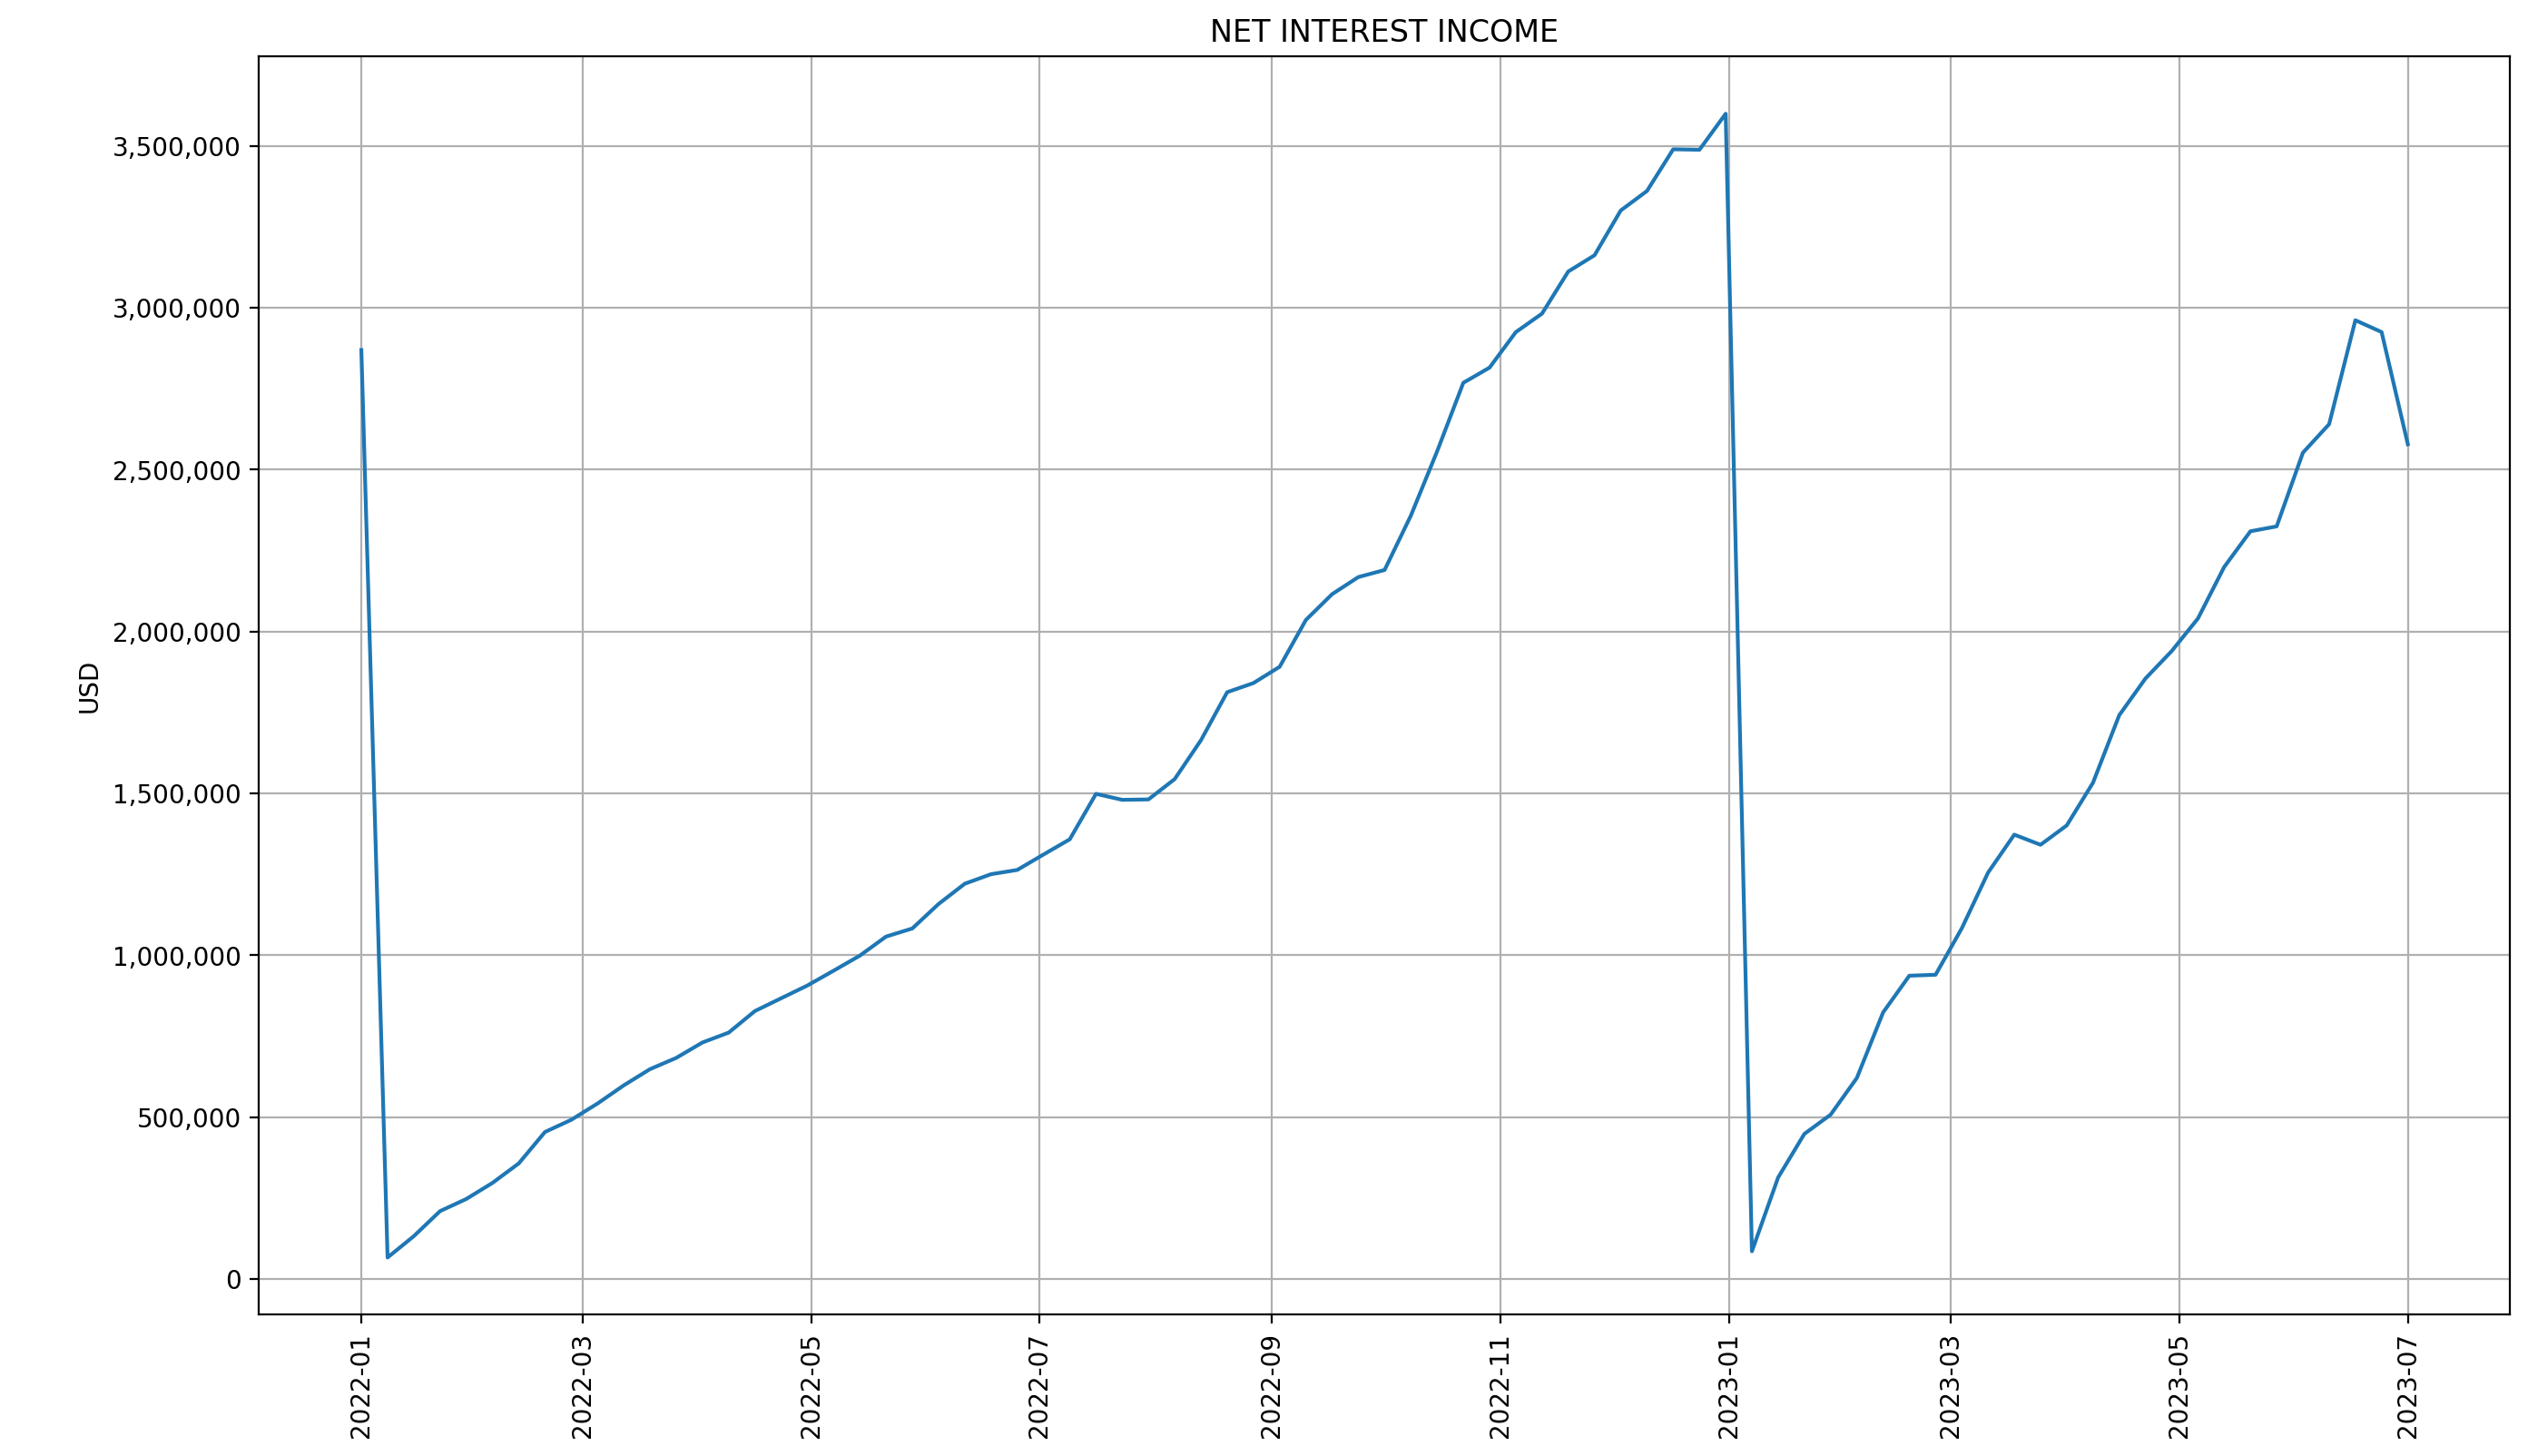

In [57]:
plot_line(pl, 'NET INTEREST INCOME', True)

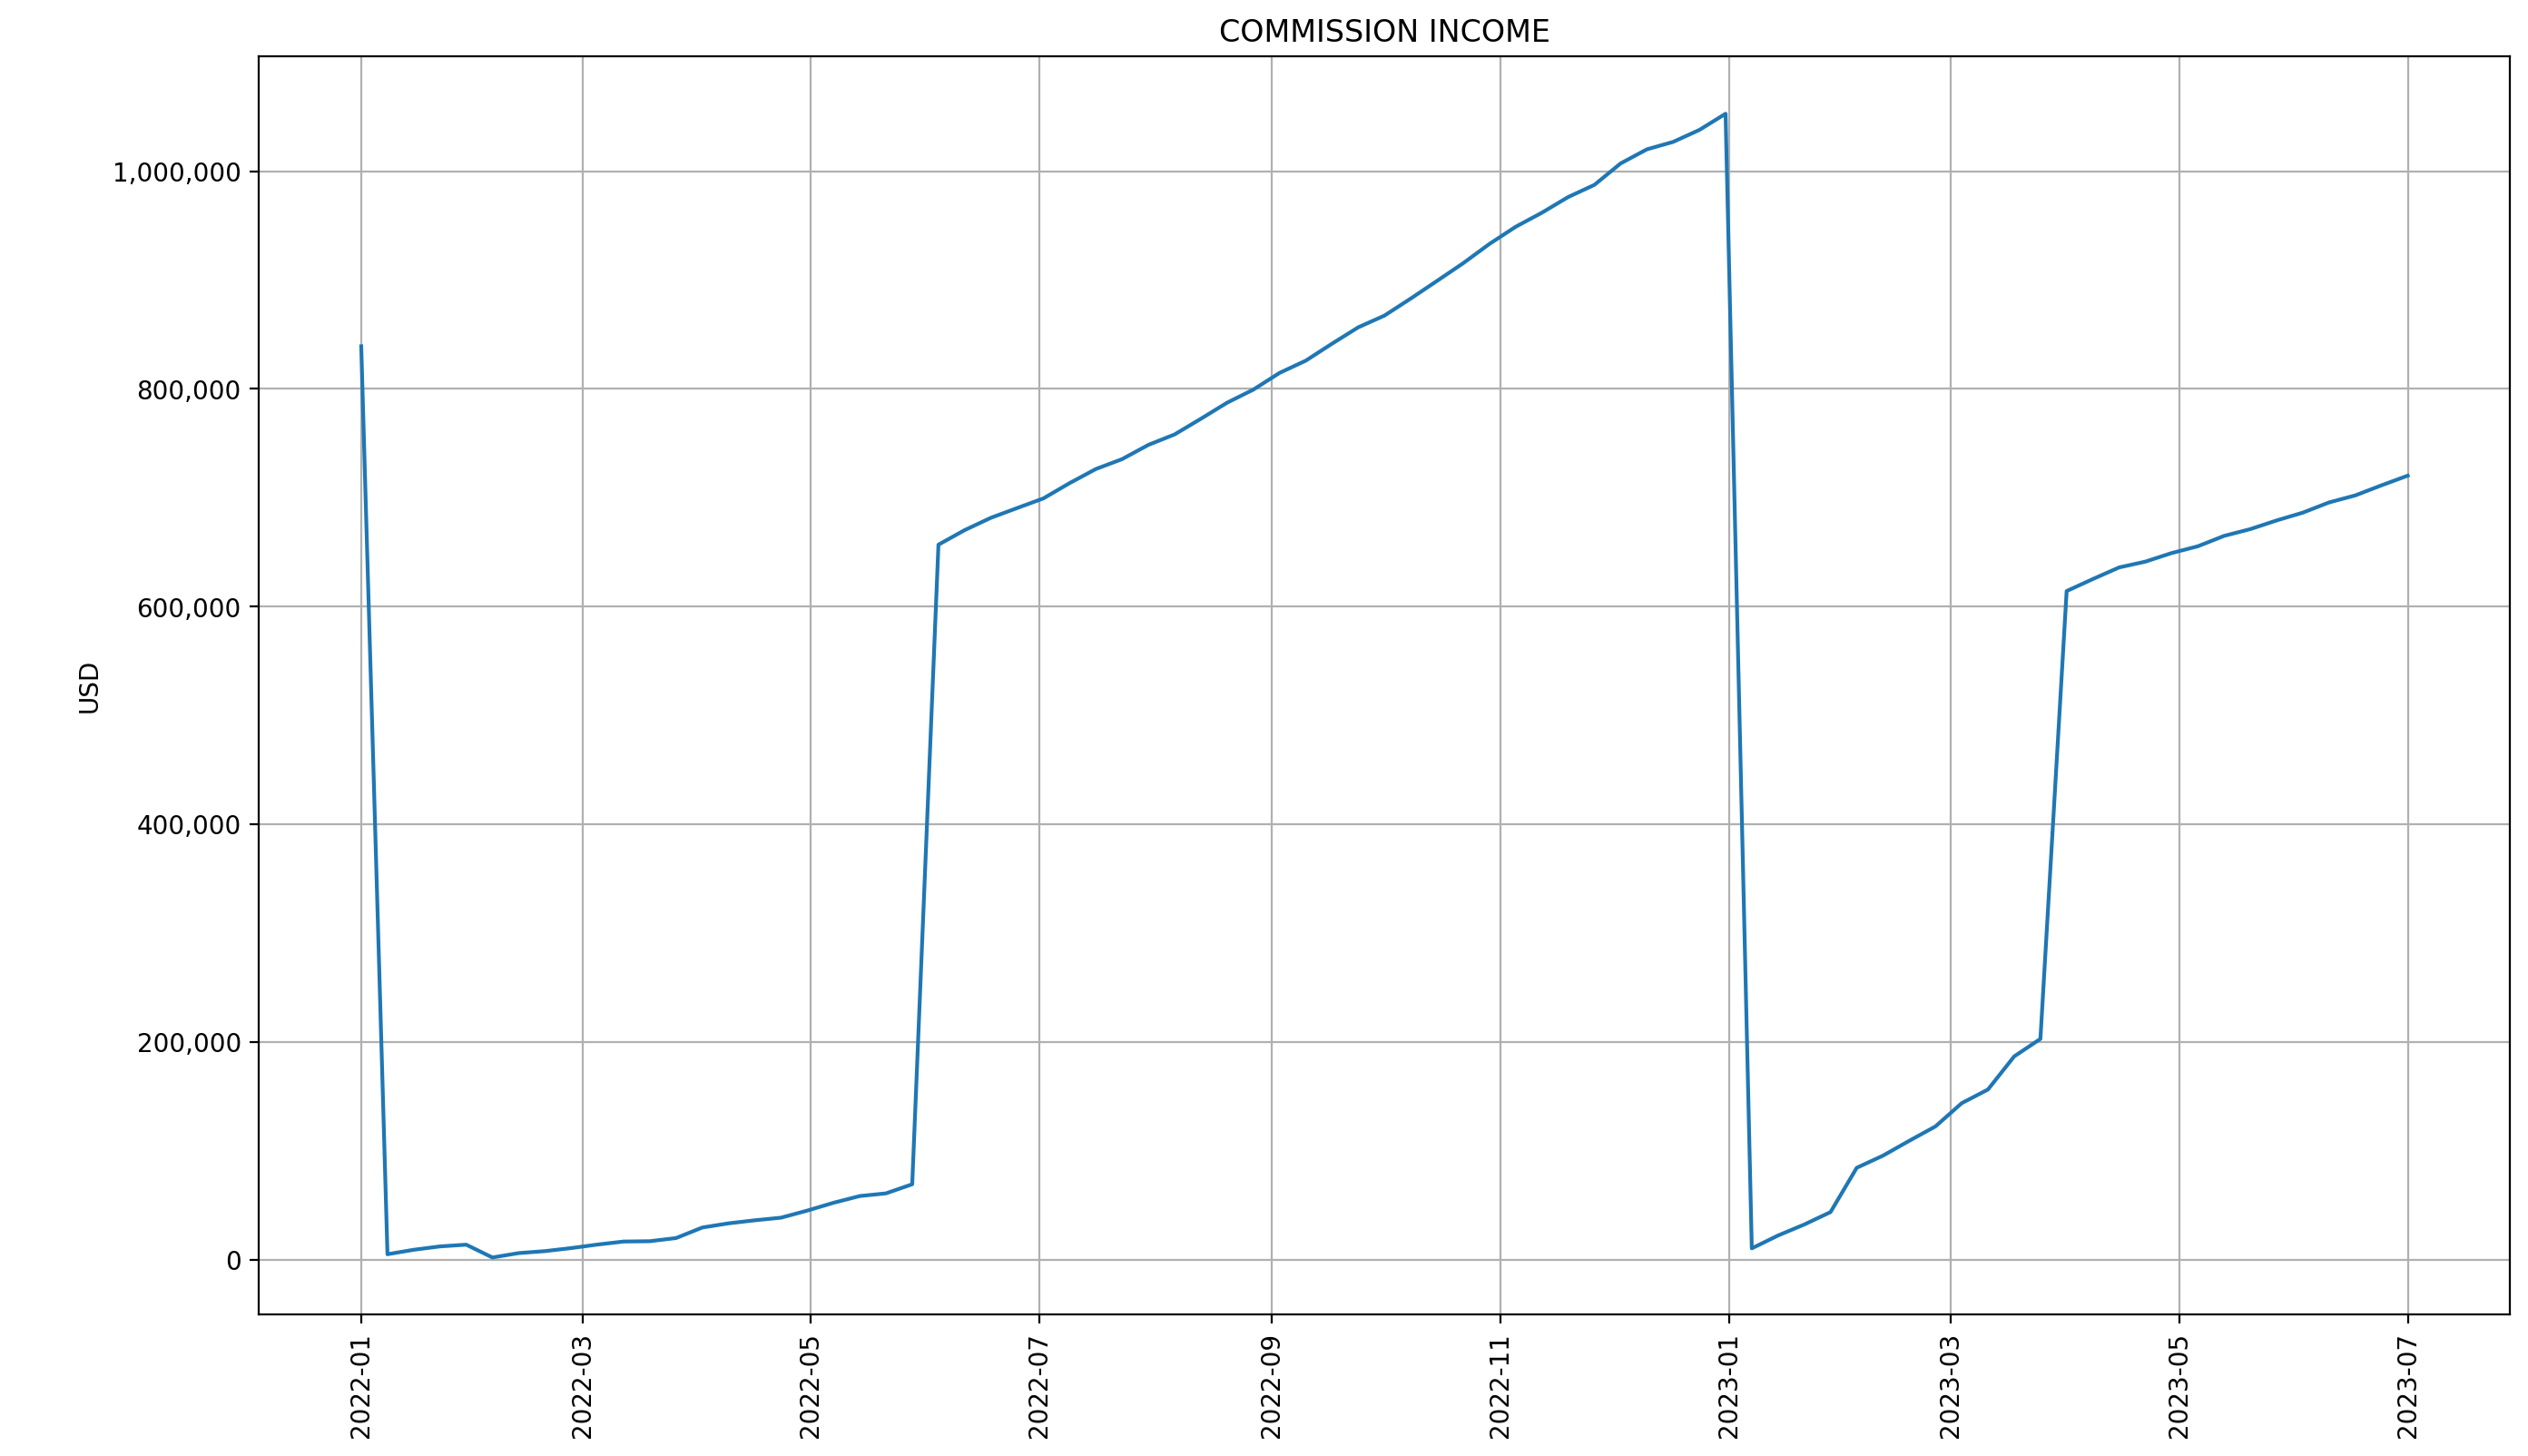

In [58]:
plot_line(pl, 'COMMISSION INCOME', True)

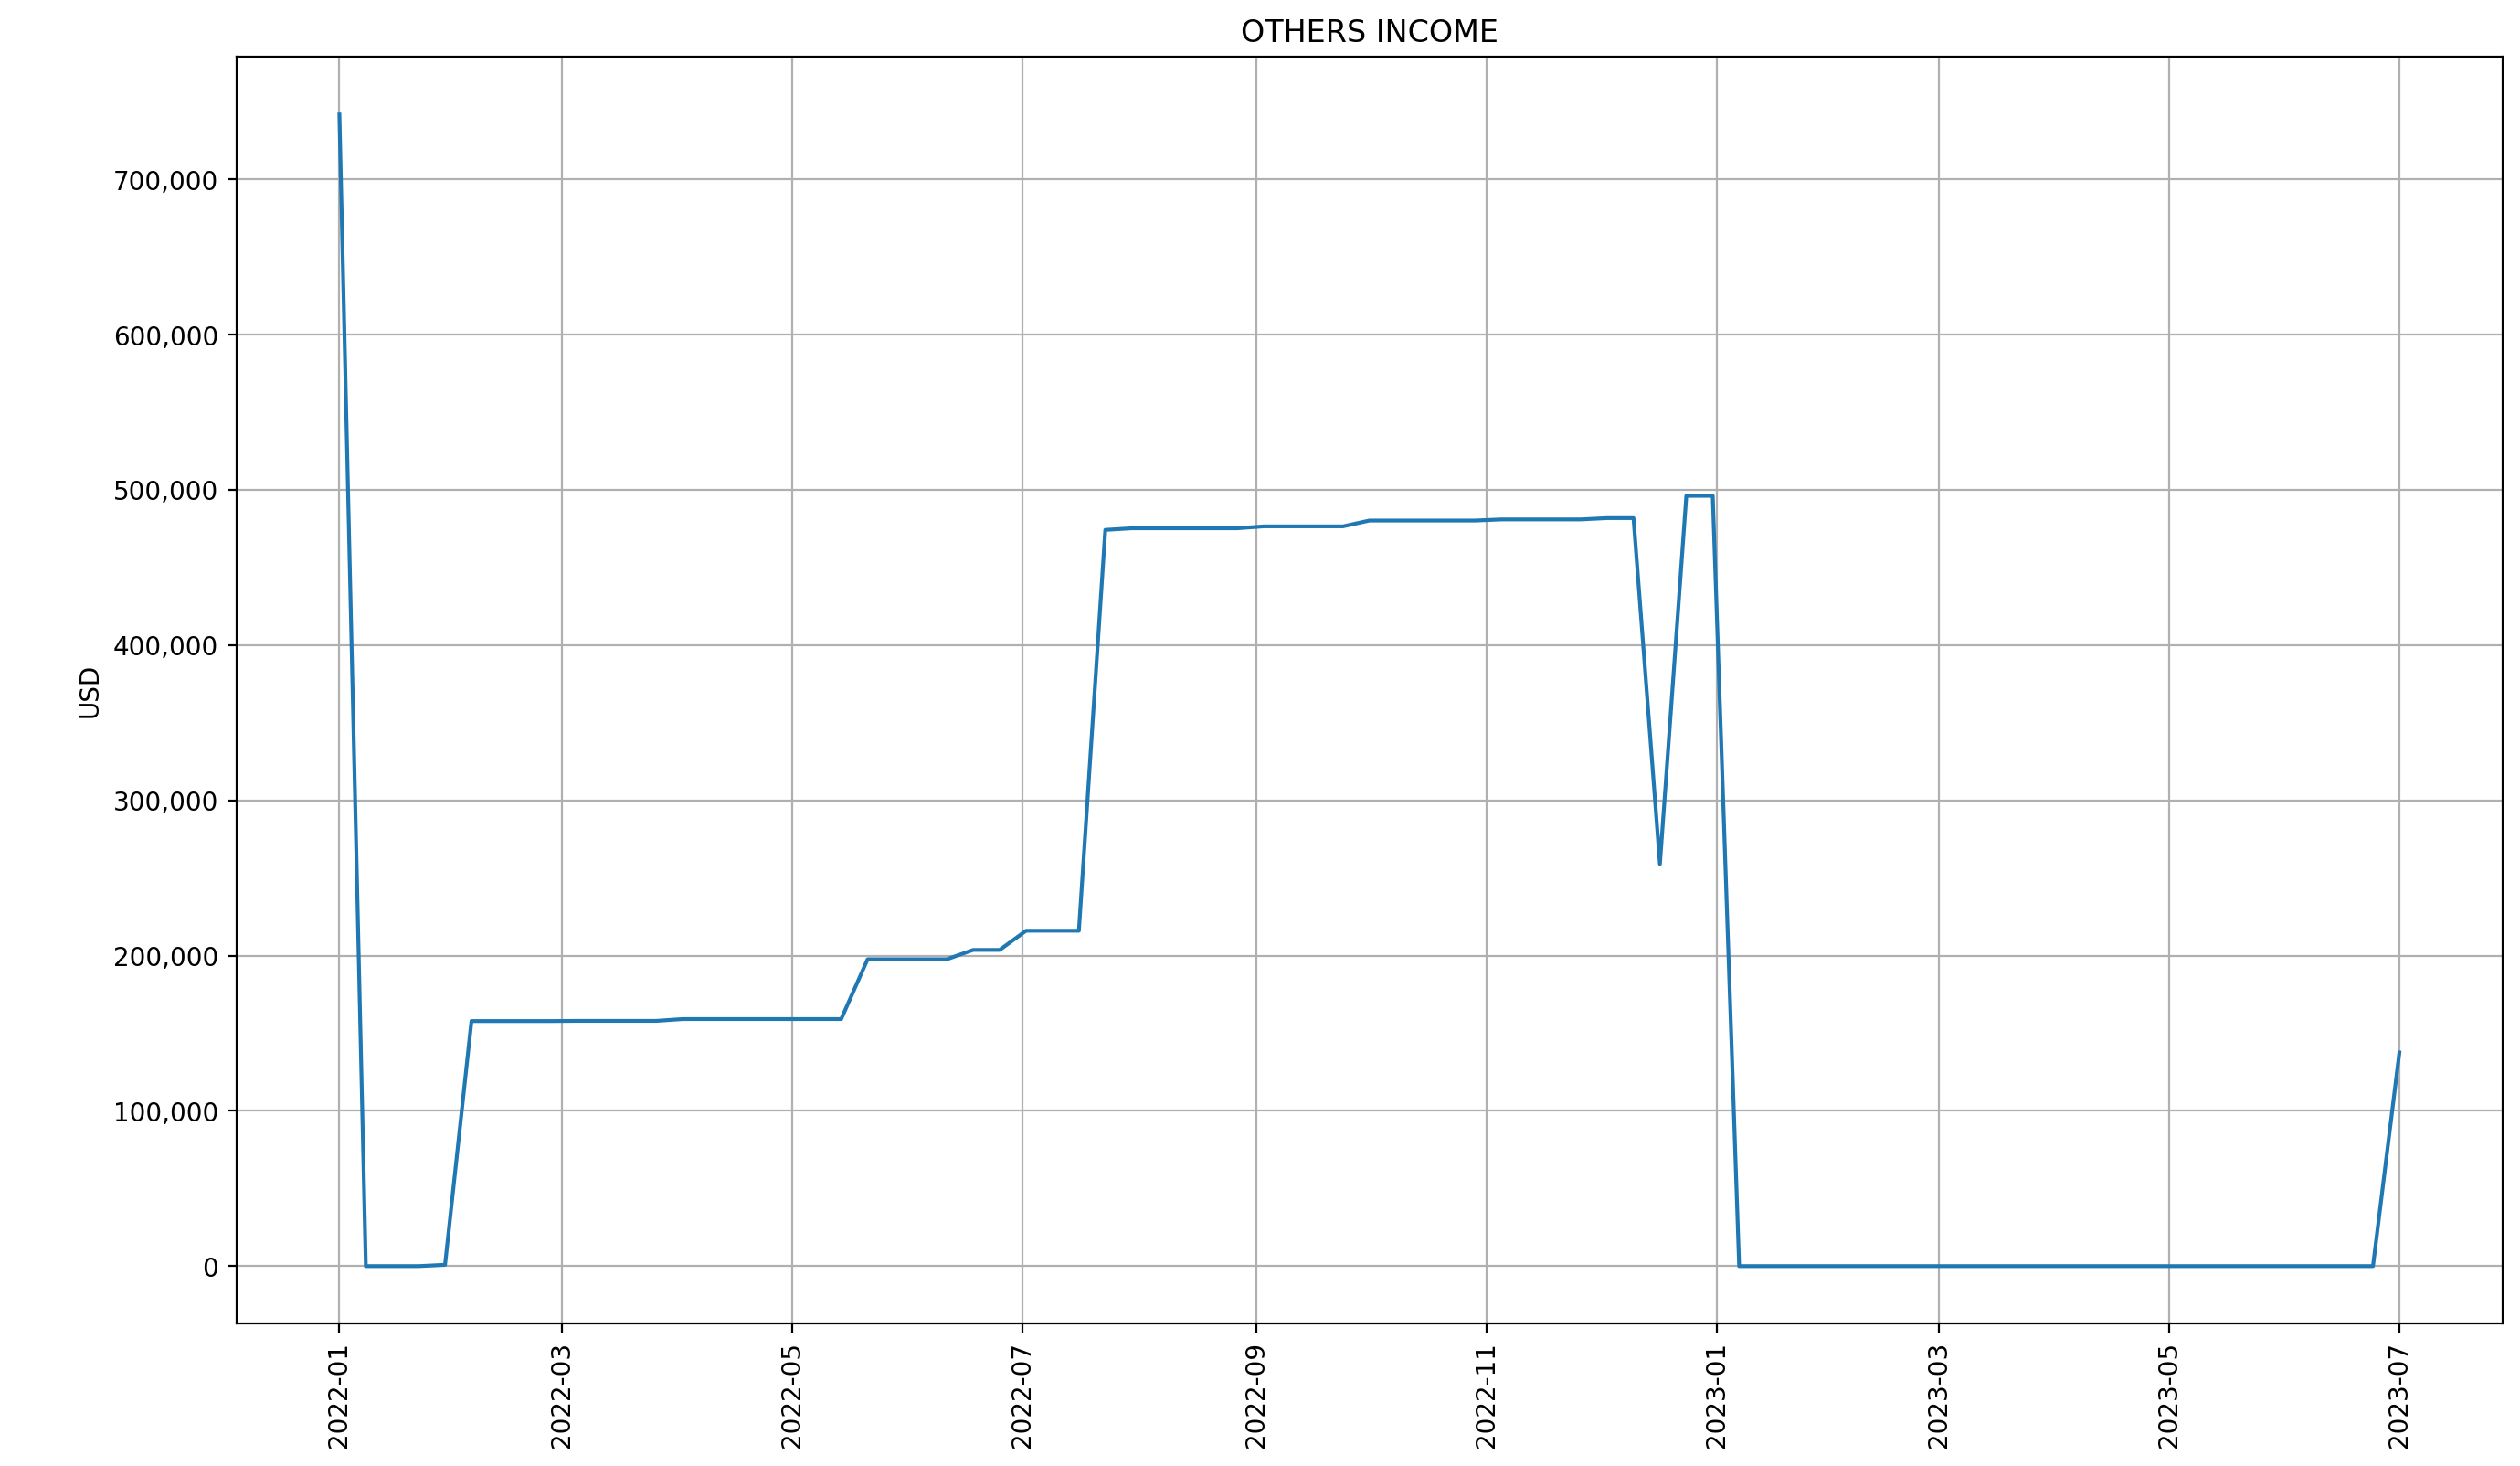

In [59]:
plot_line(pl, 'OTHERS INCOME', True)

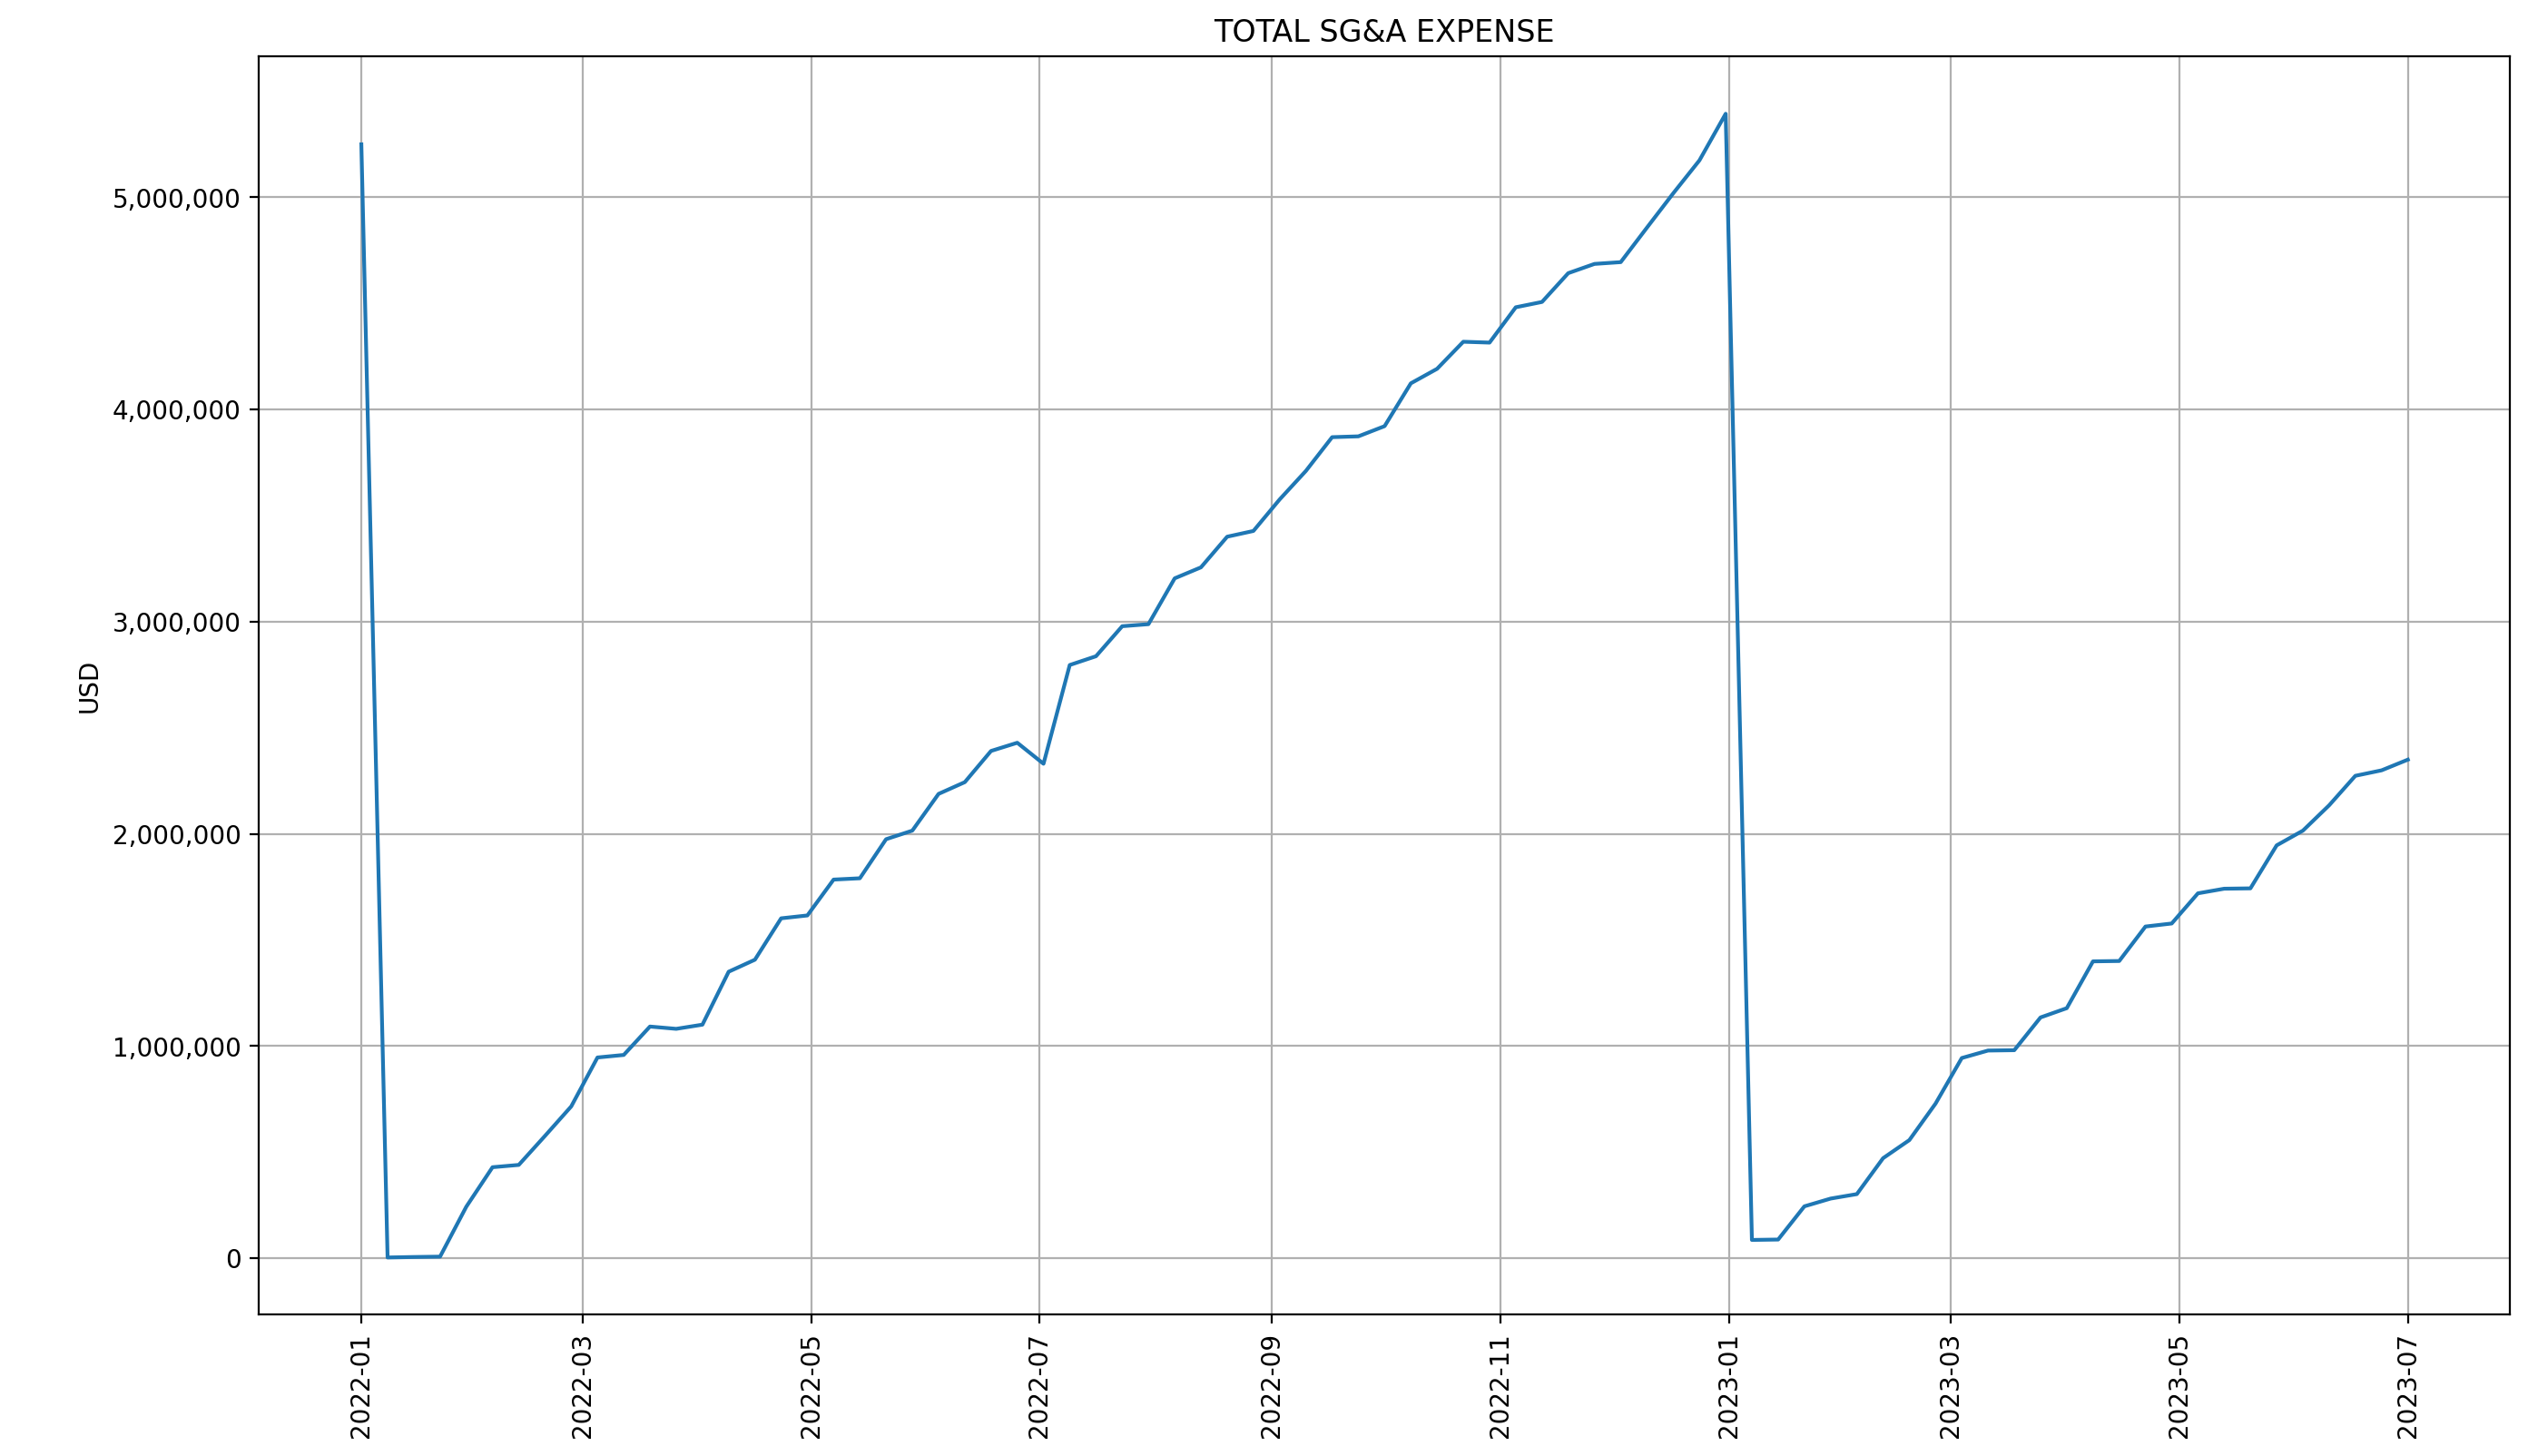

In [12]:
plot_line(pl, 'TOTAL SG&A EXPENSE', True)

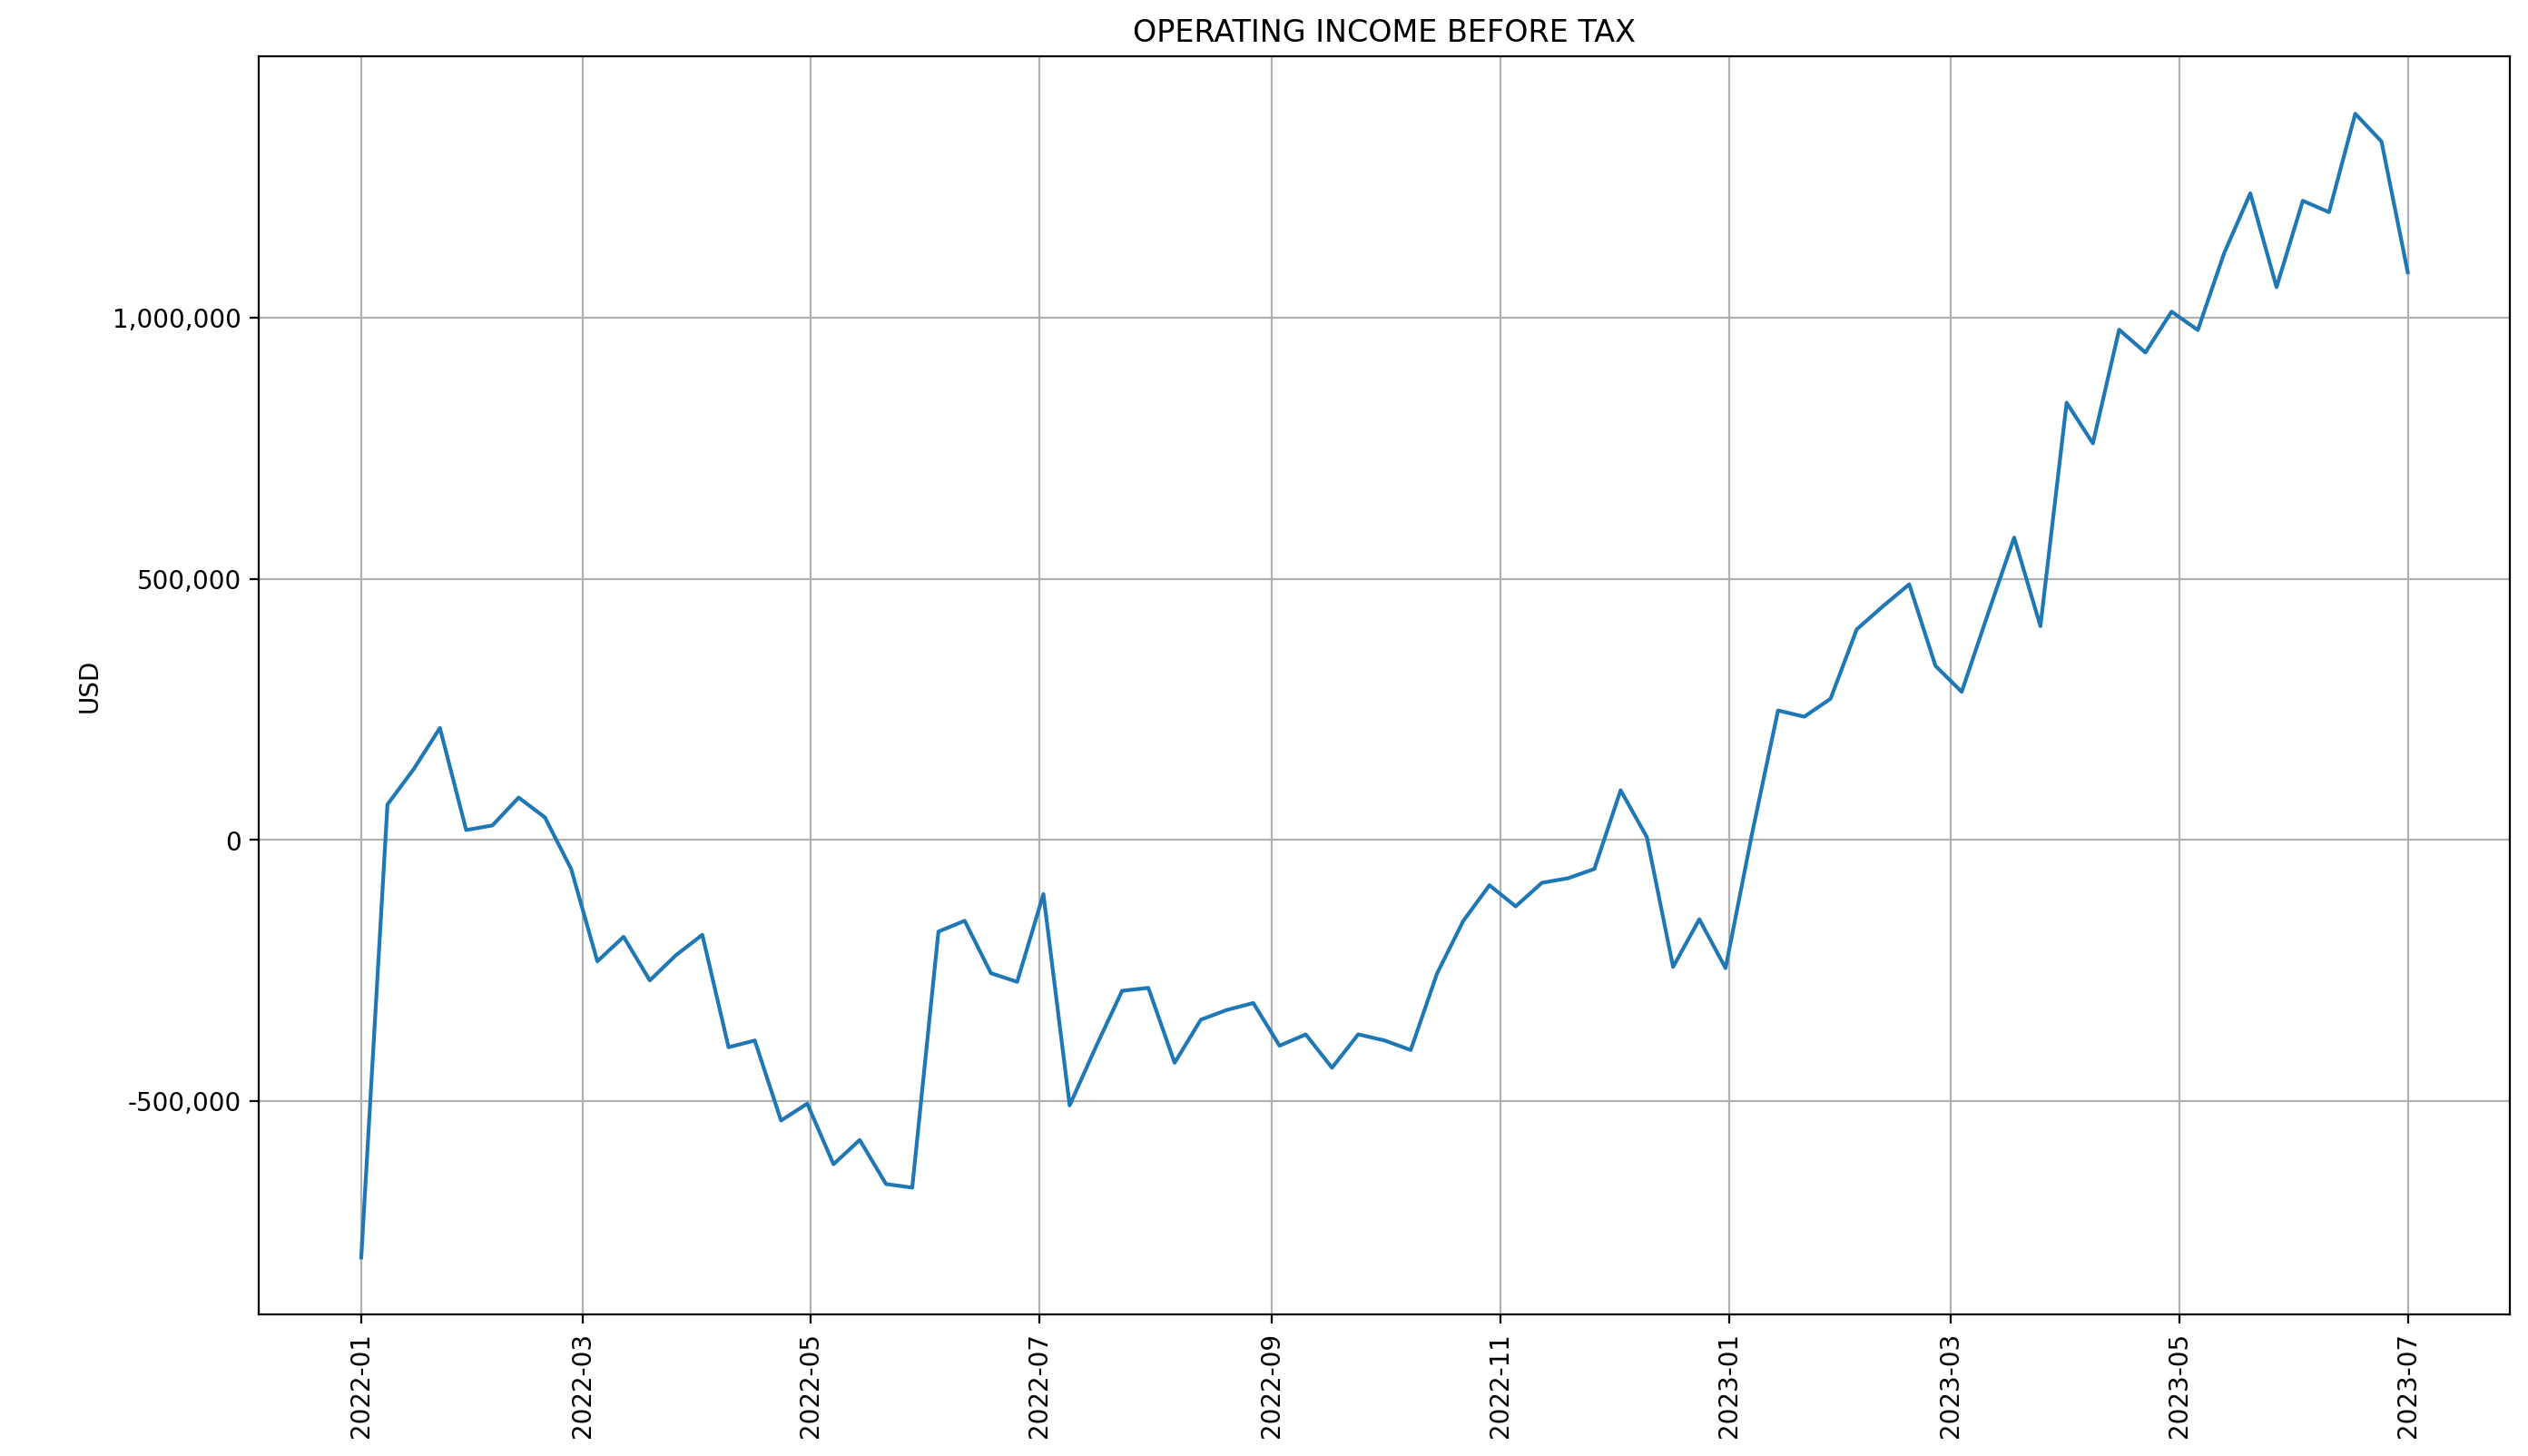

In [13]:
plot_line(pl, 'OPERATING INCOME BEFORE TAX', True)

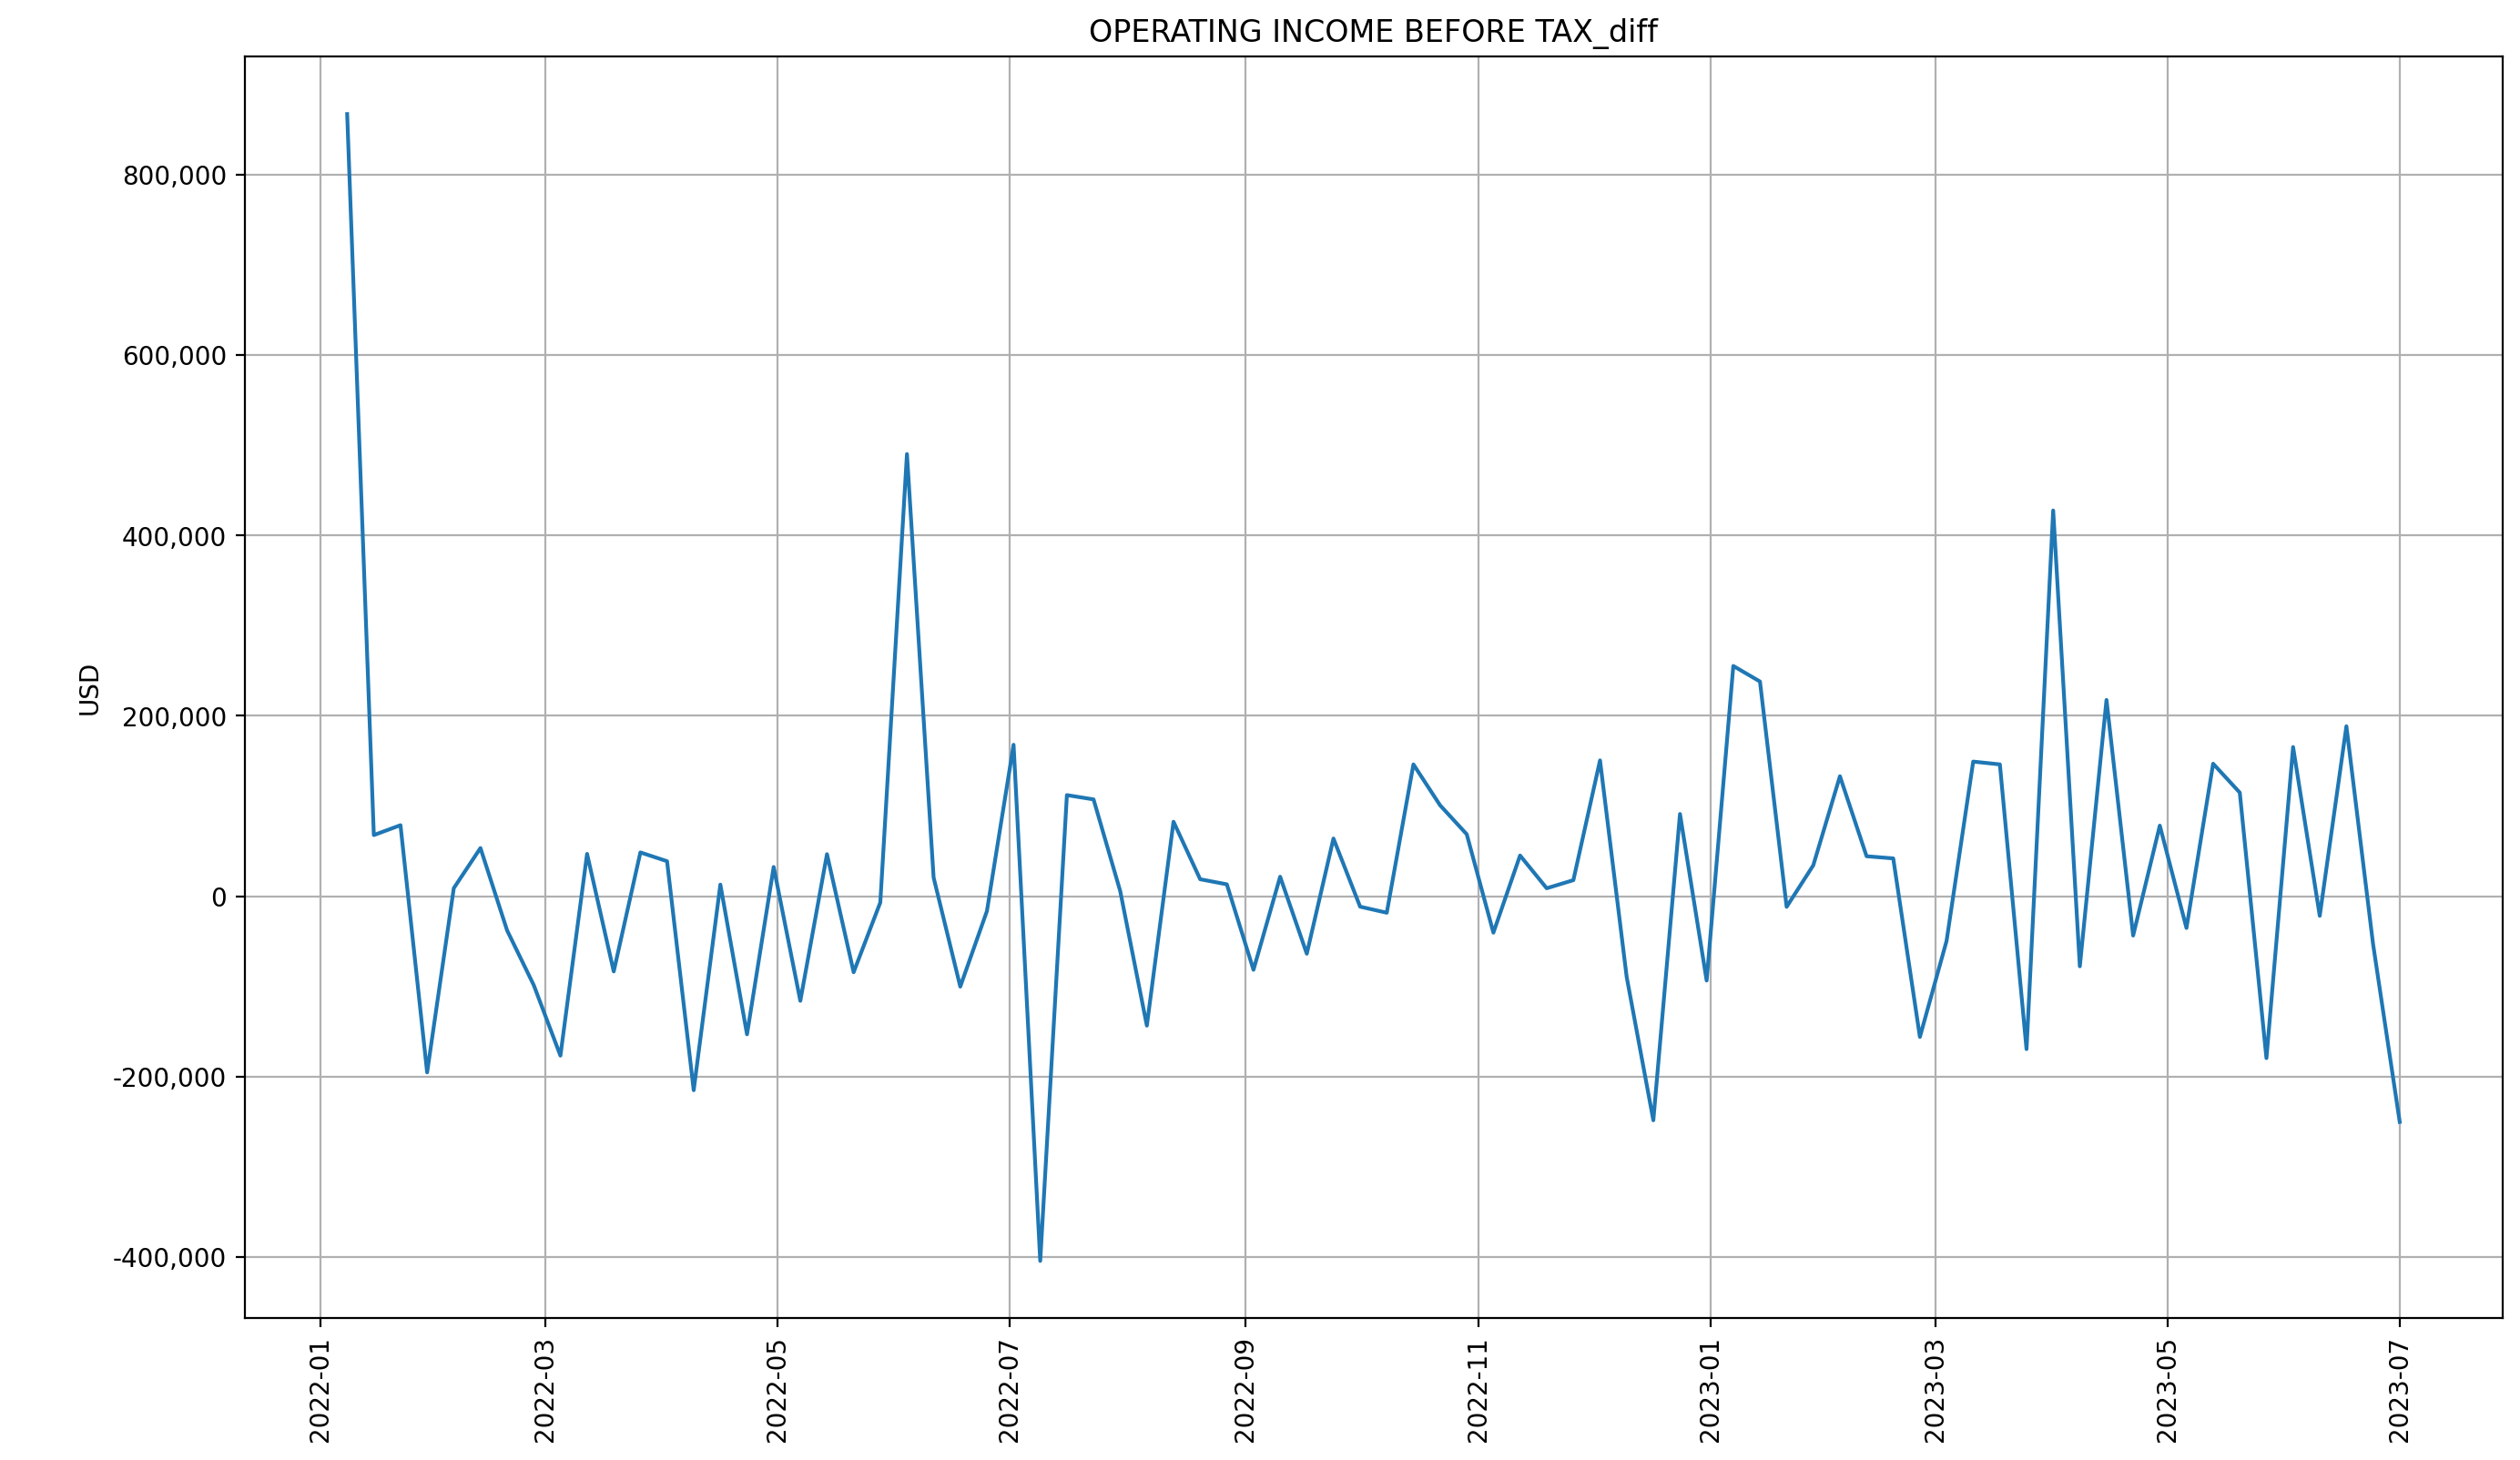

In [14]:
plot_line(pl, 'OPERATING INCOME BEFORE TAX_diff', True)

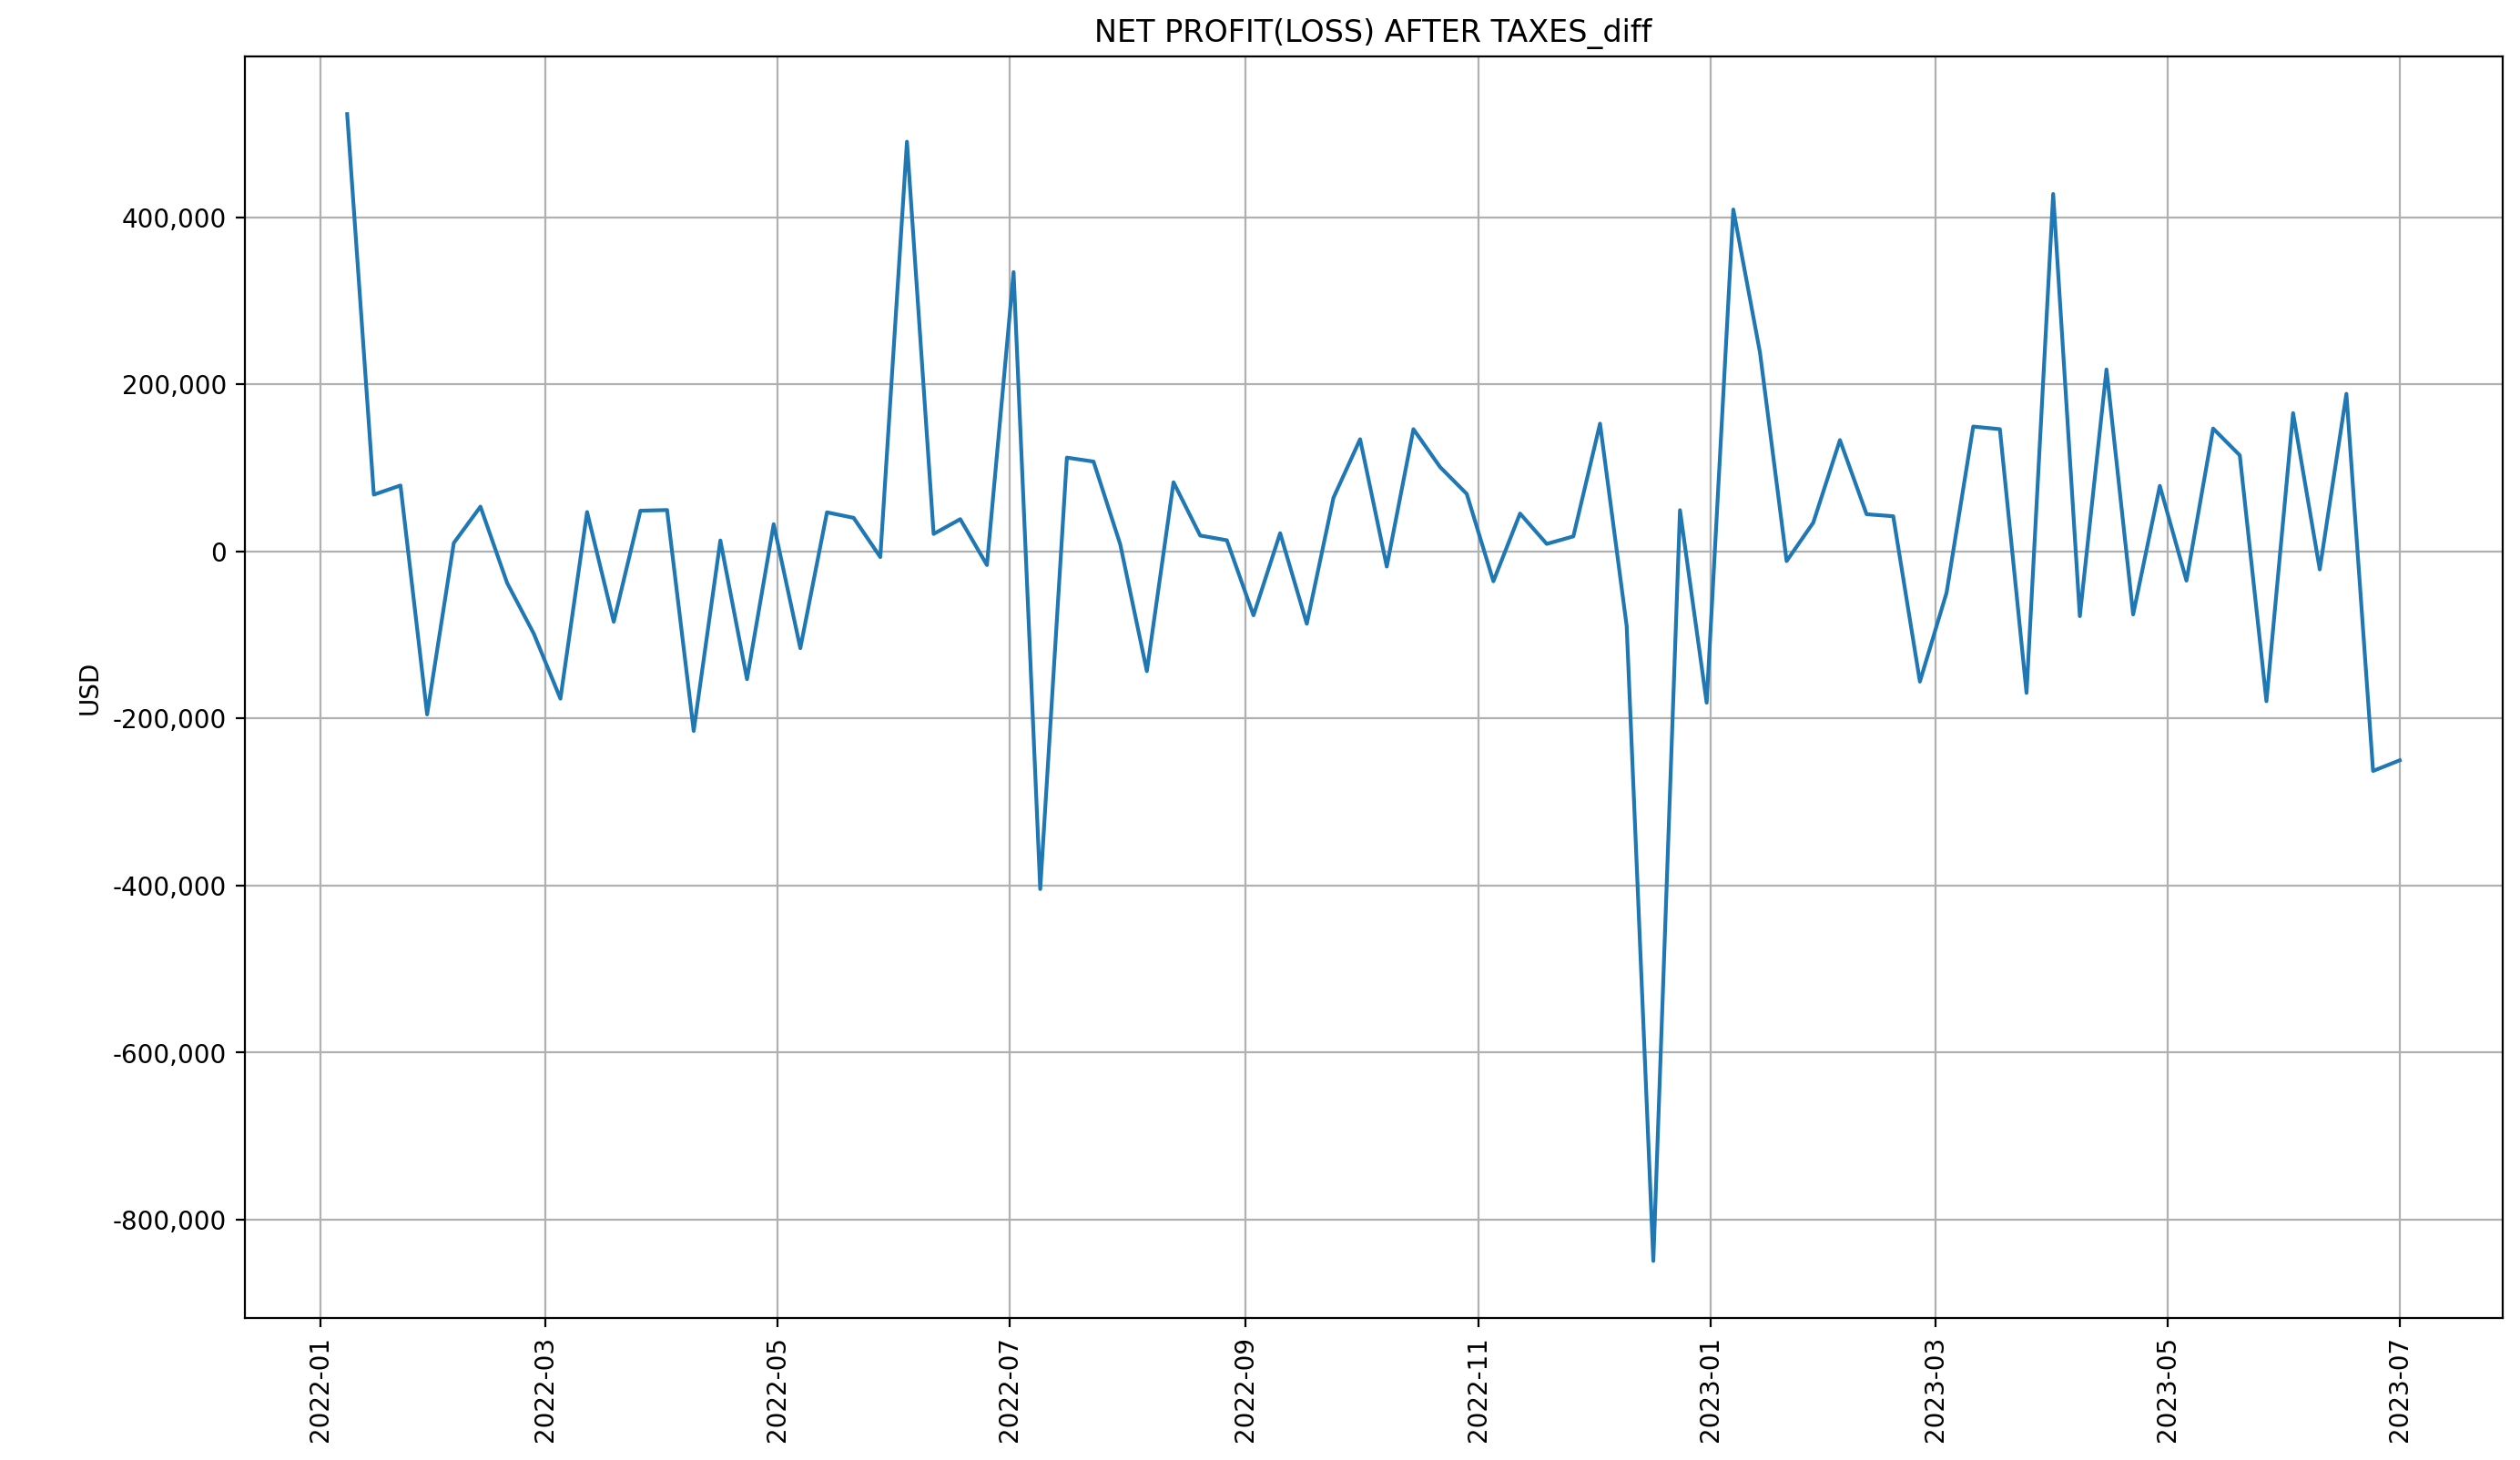

In [15]:
plot_line(pl, 'NET PROFIT(LOSS) AFTER TAXES_diff', True)

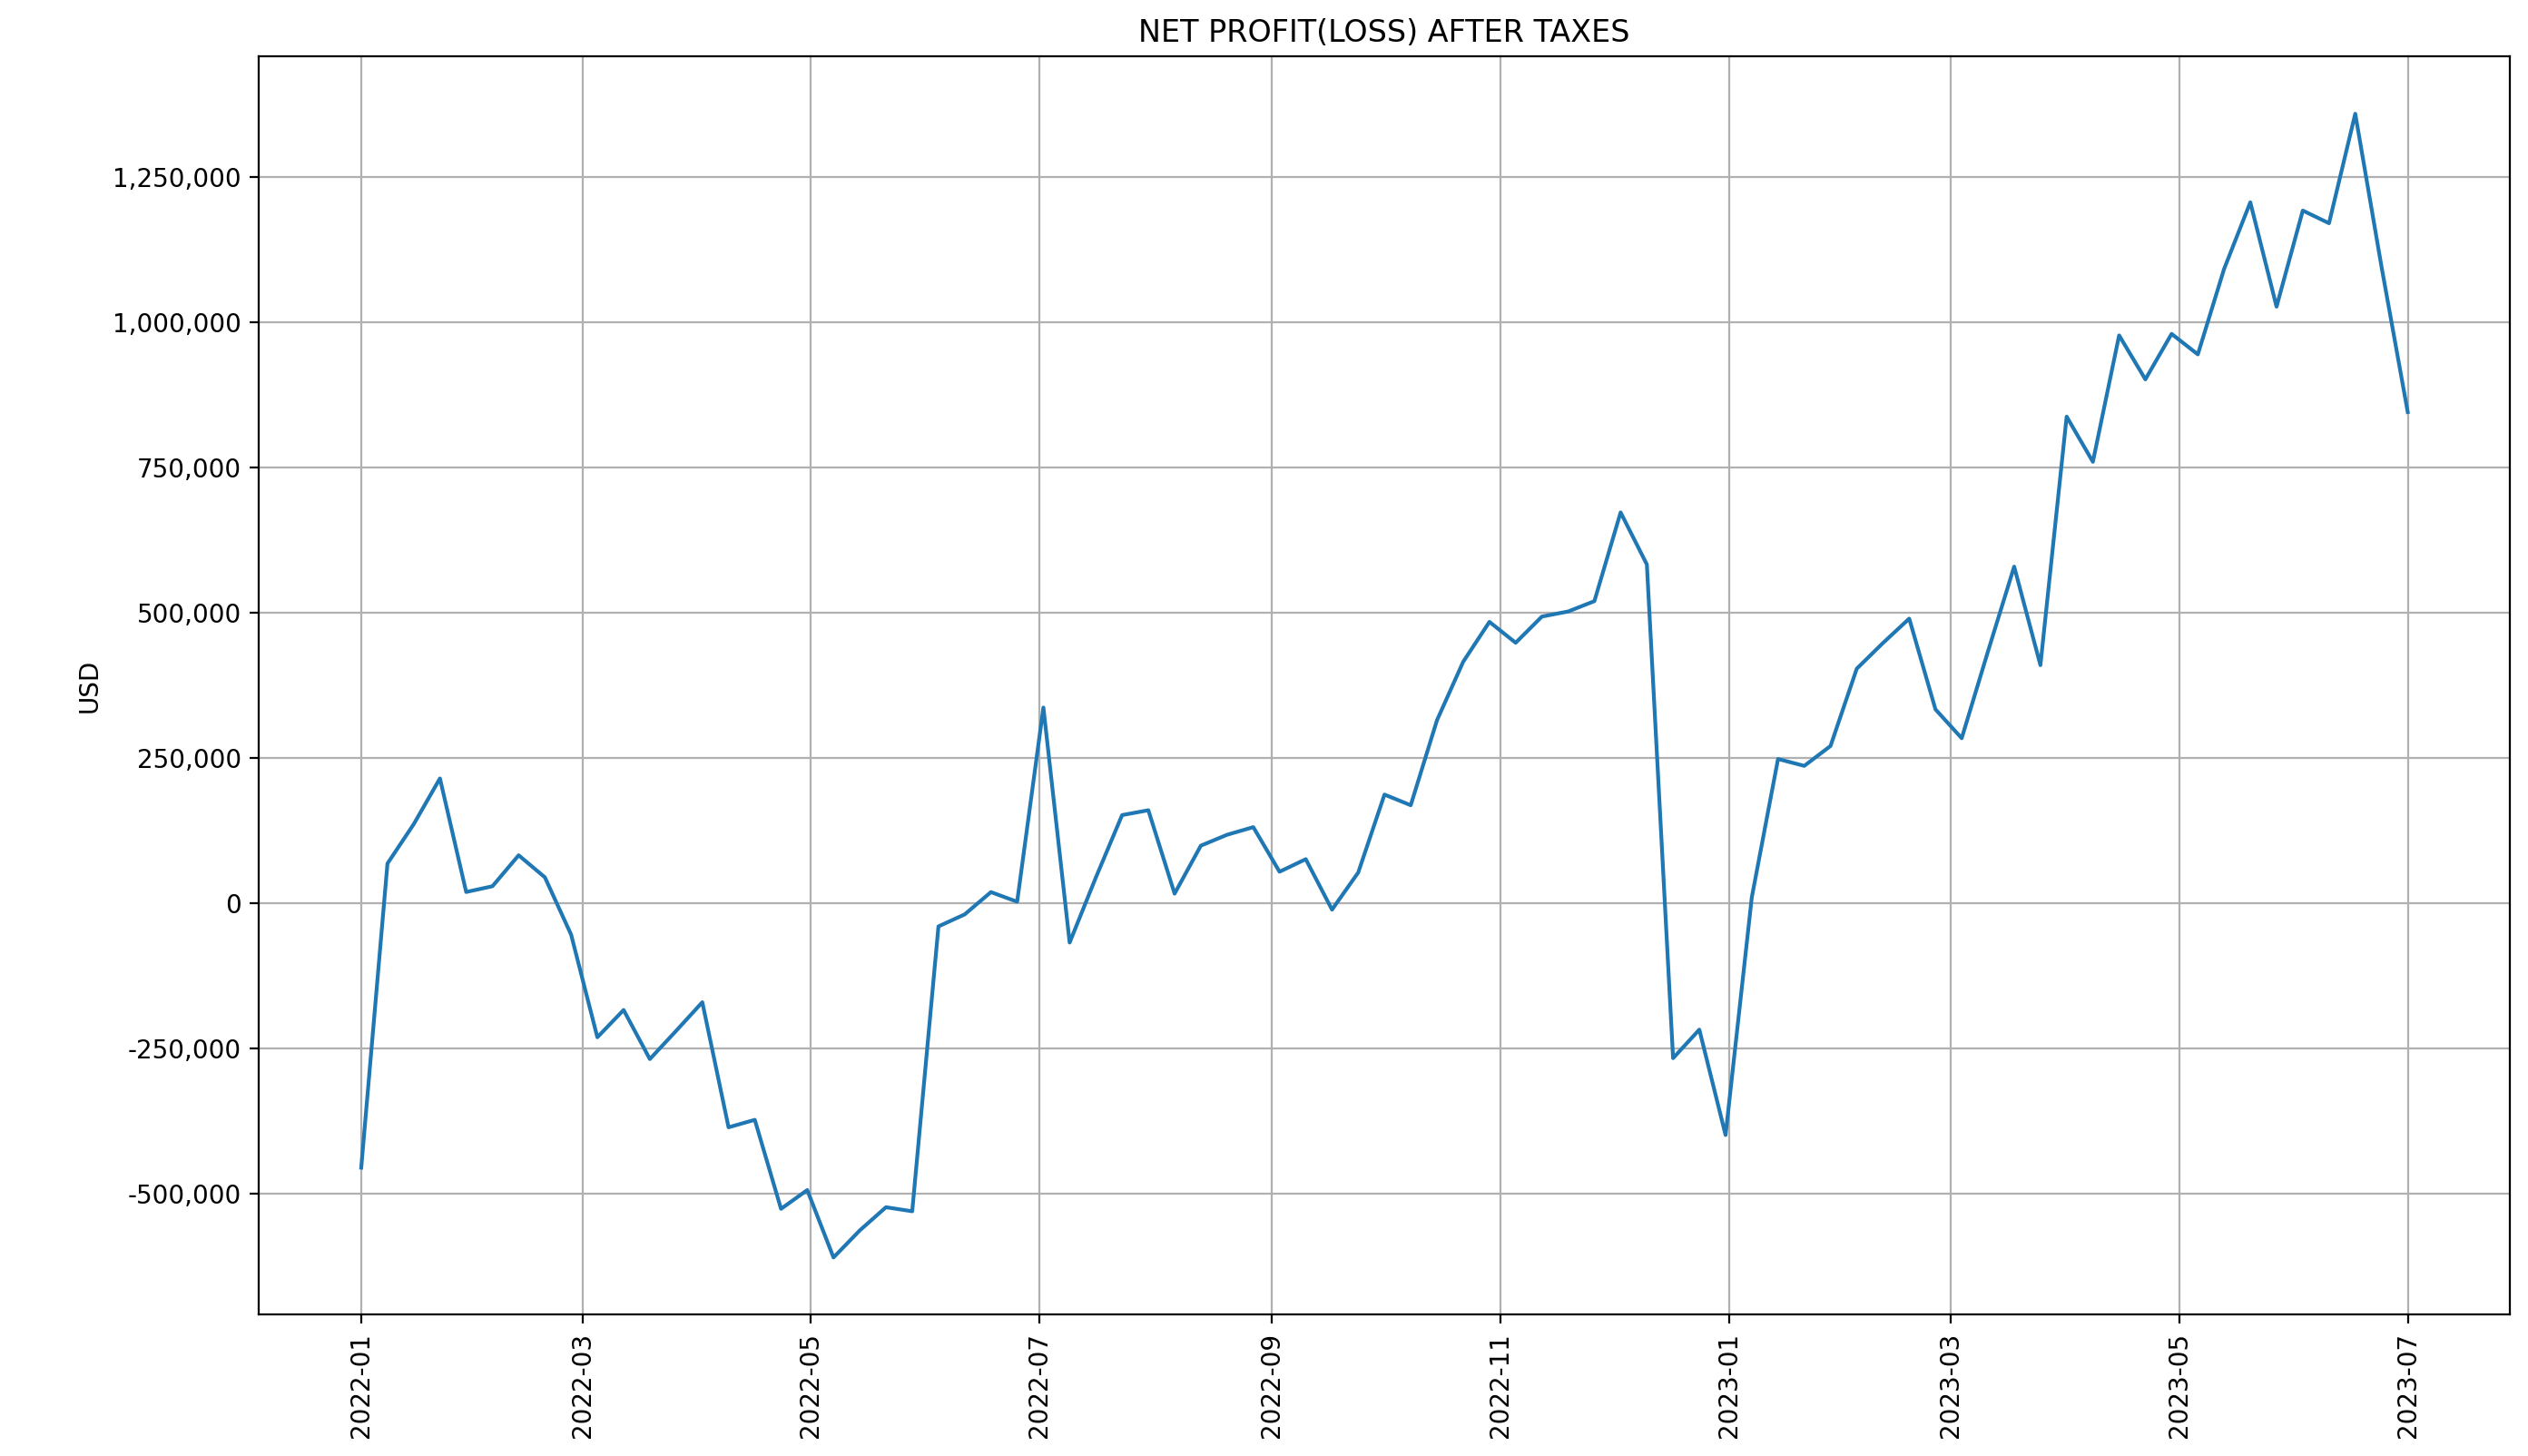

In [16]:
plot_line(pl, 'NET PROFIT(LOSS) AFTER TAXES', True)

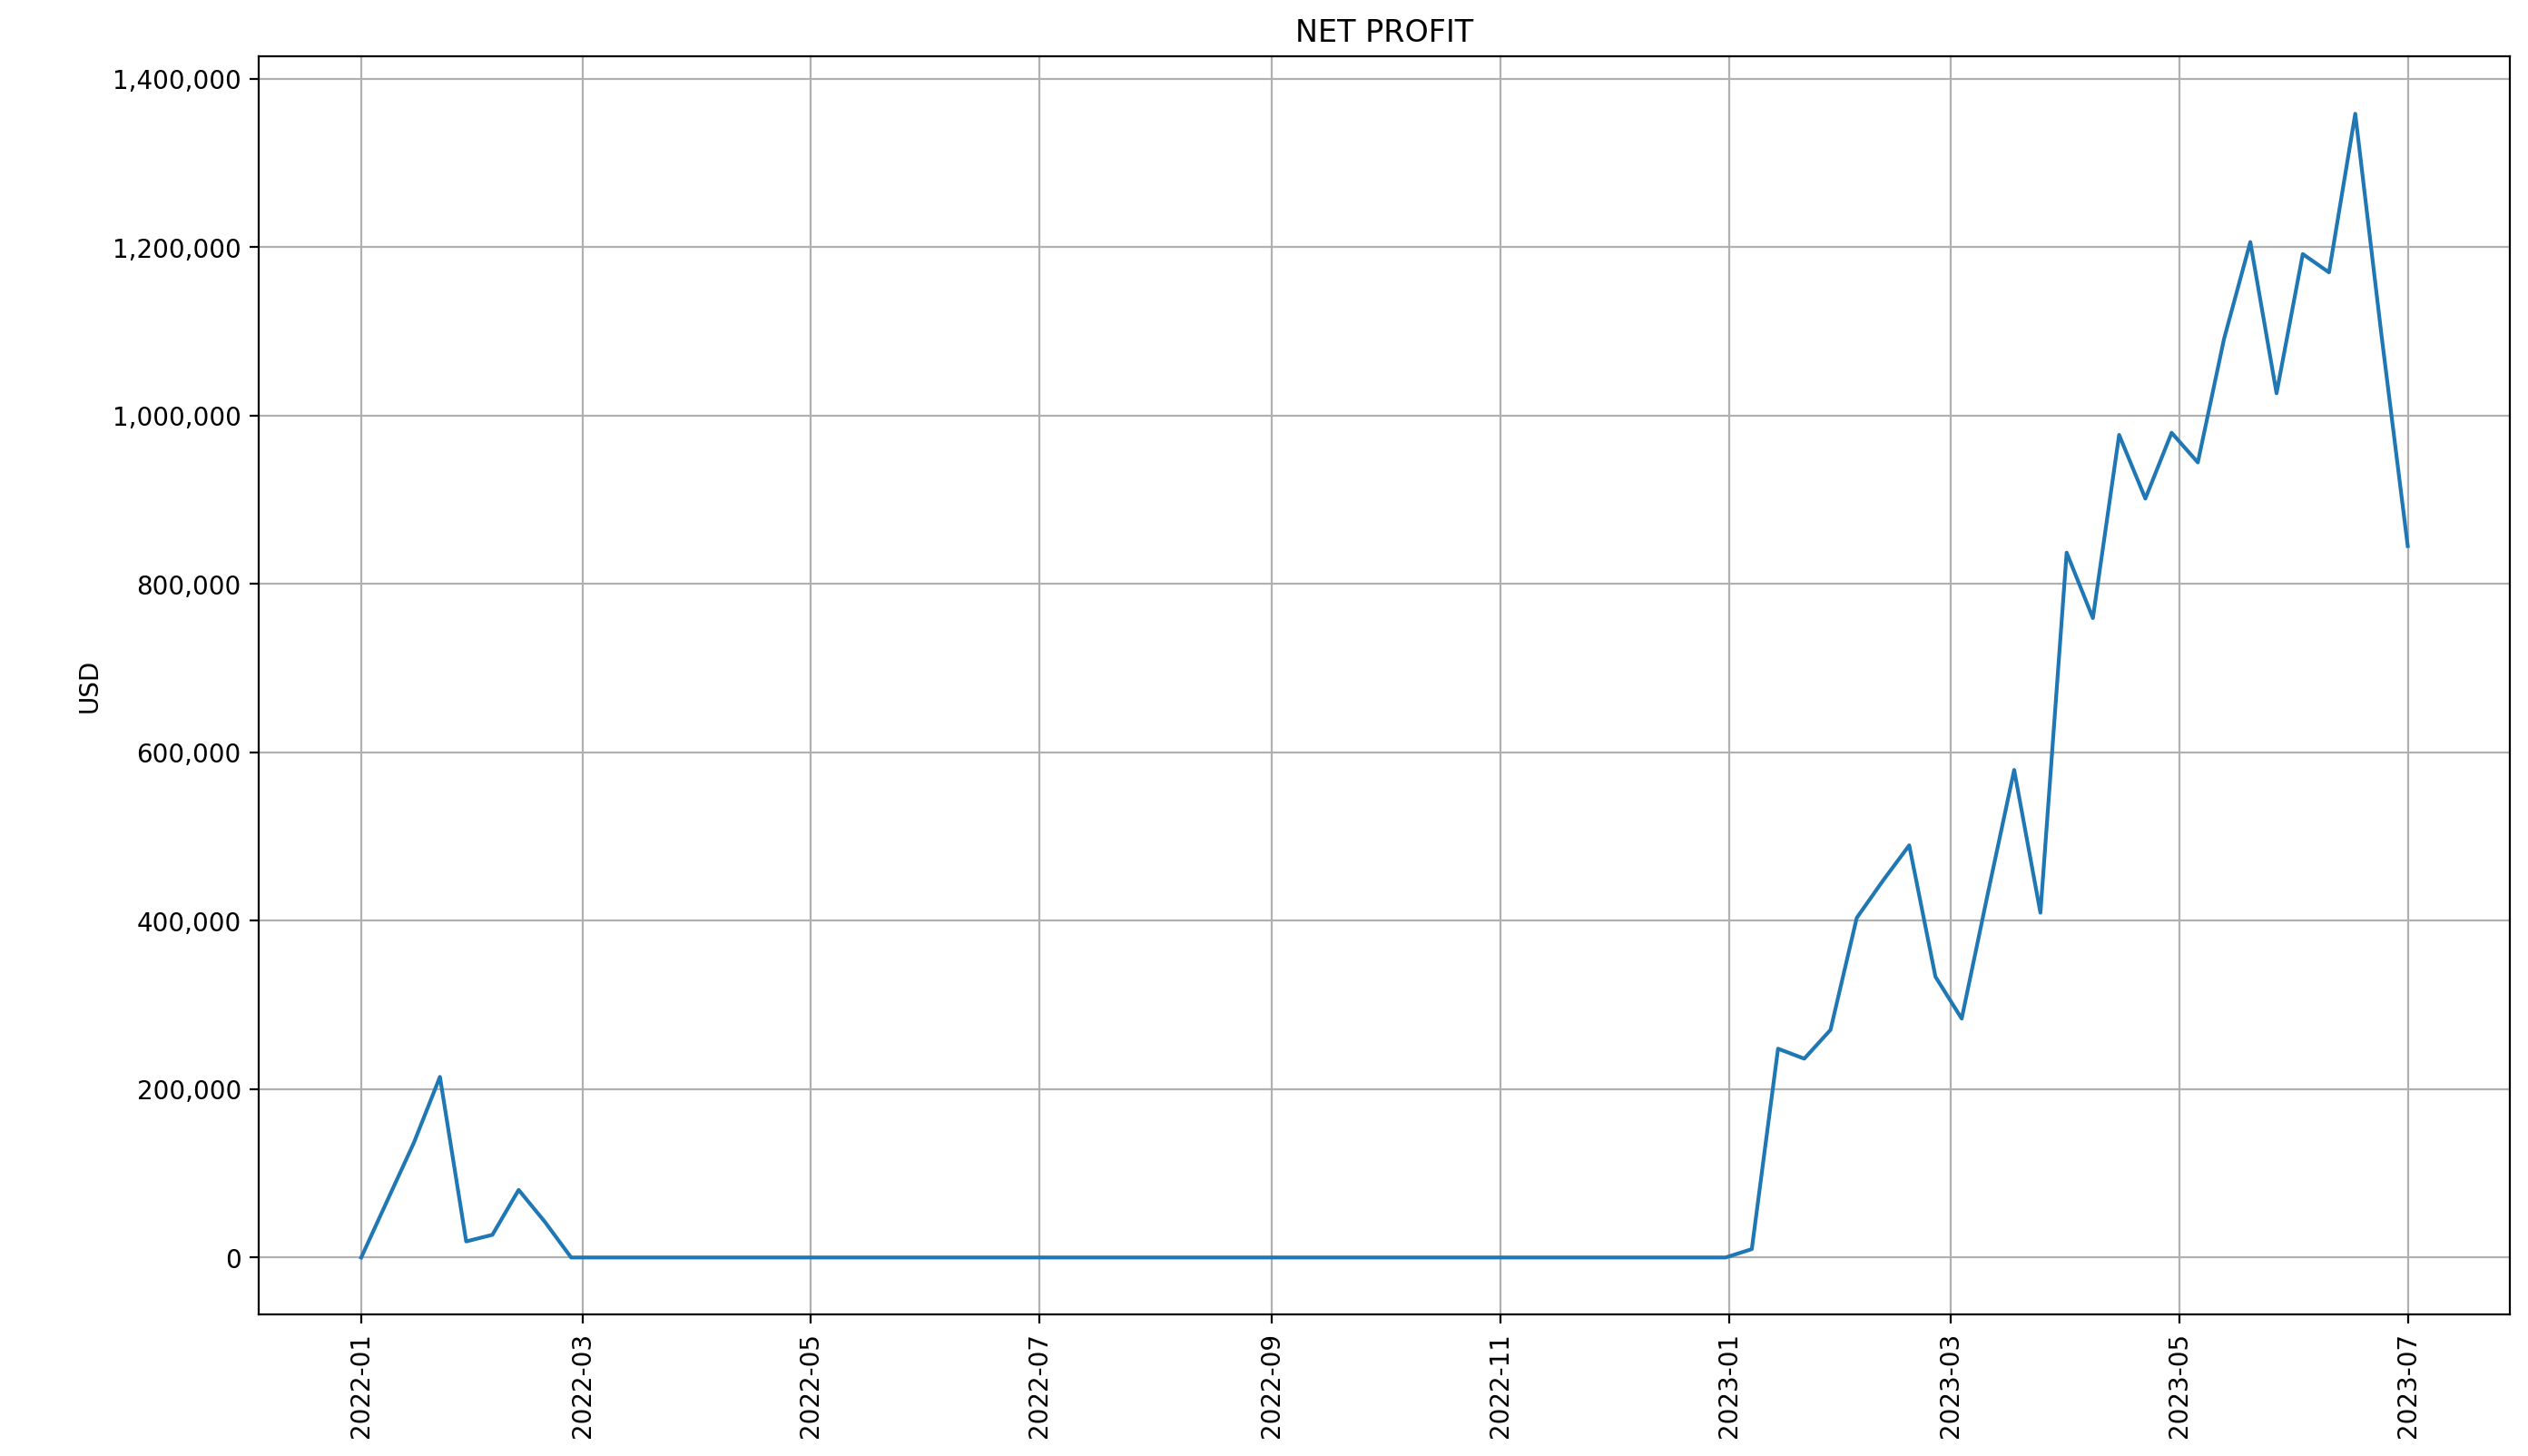

In [17]:
plot_line(bs, 'Cr_--NET PROFIT', False)

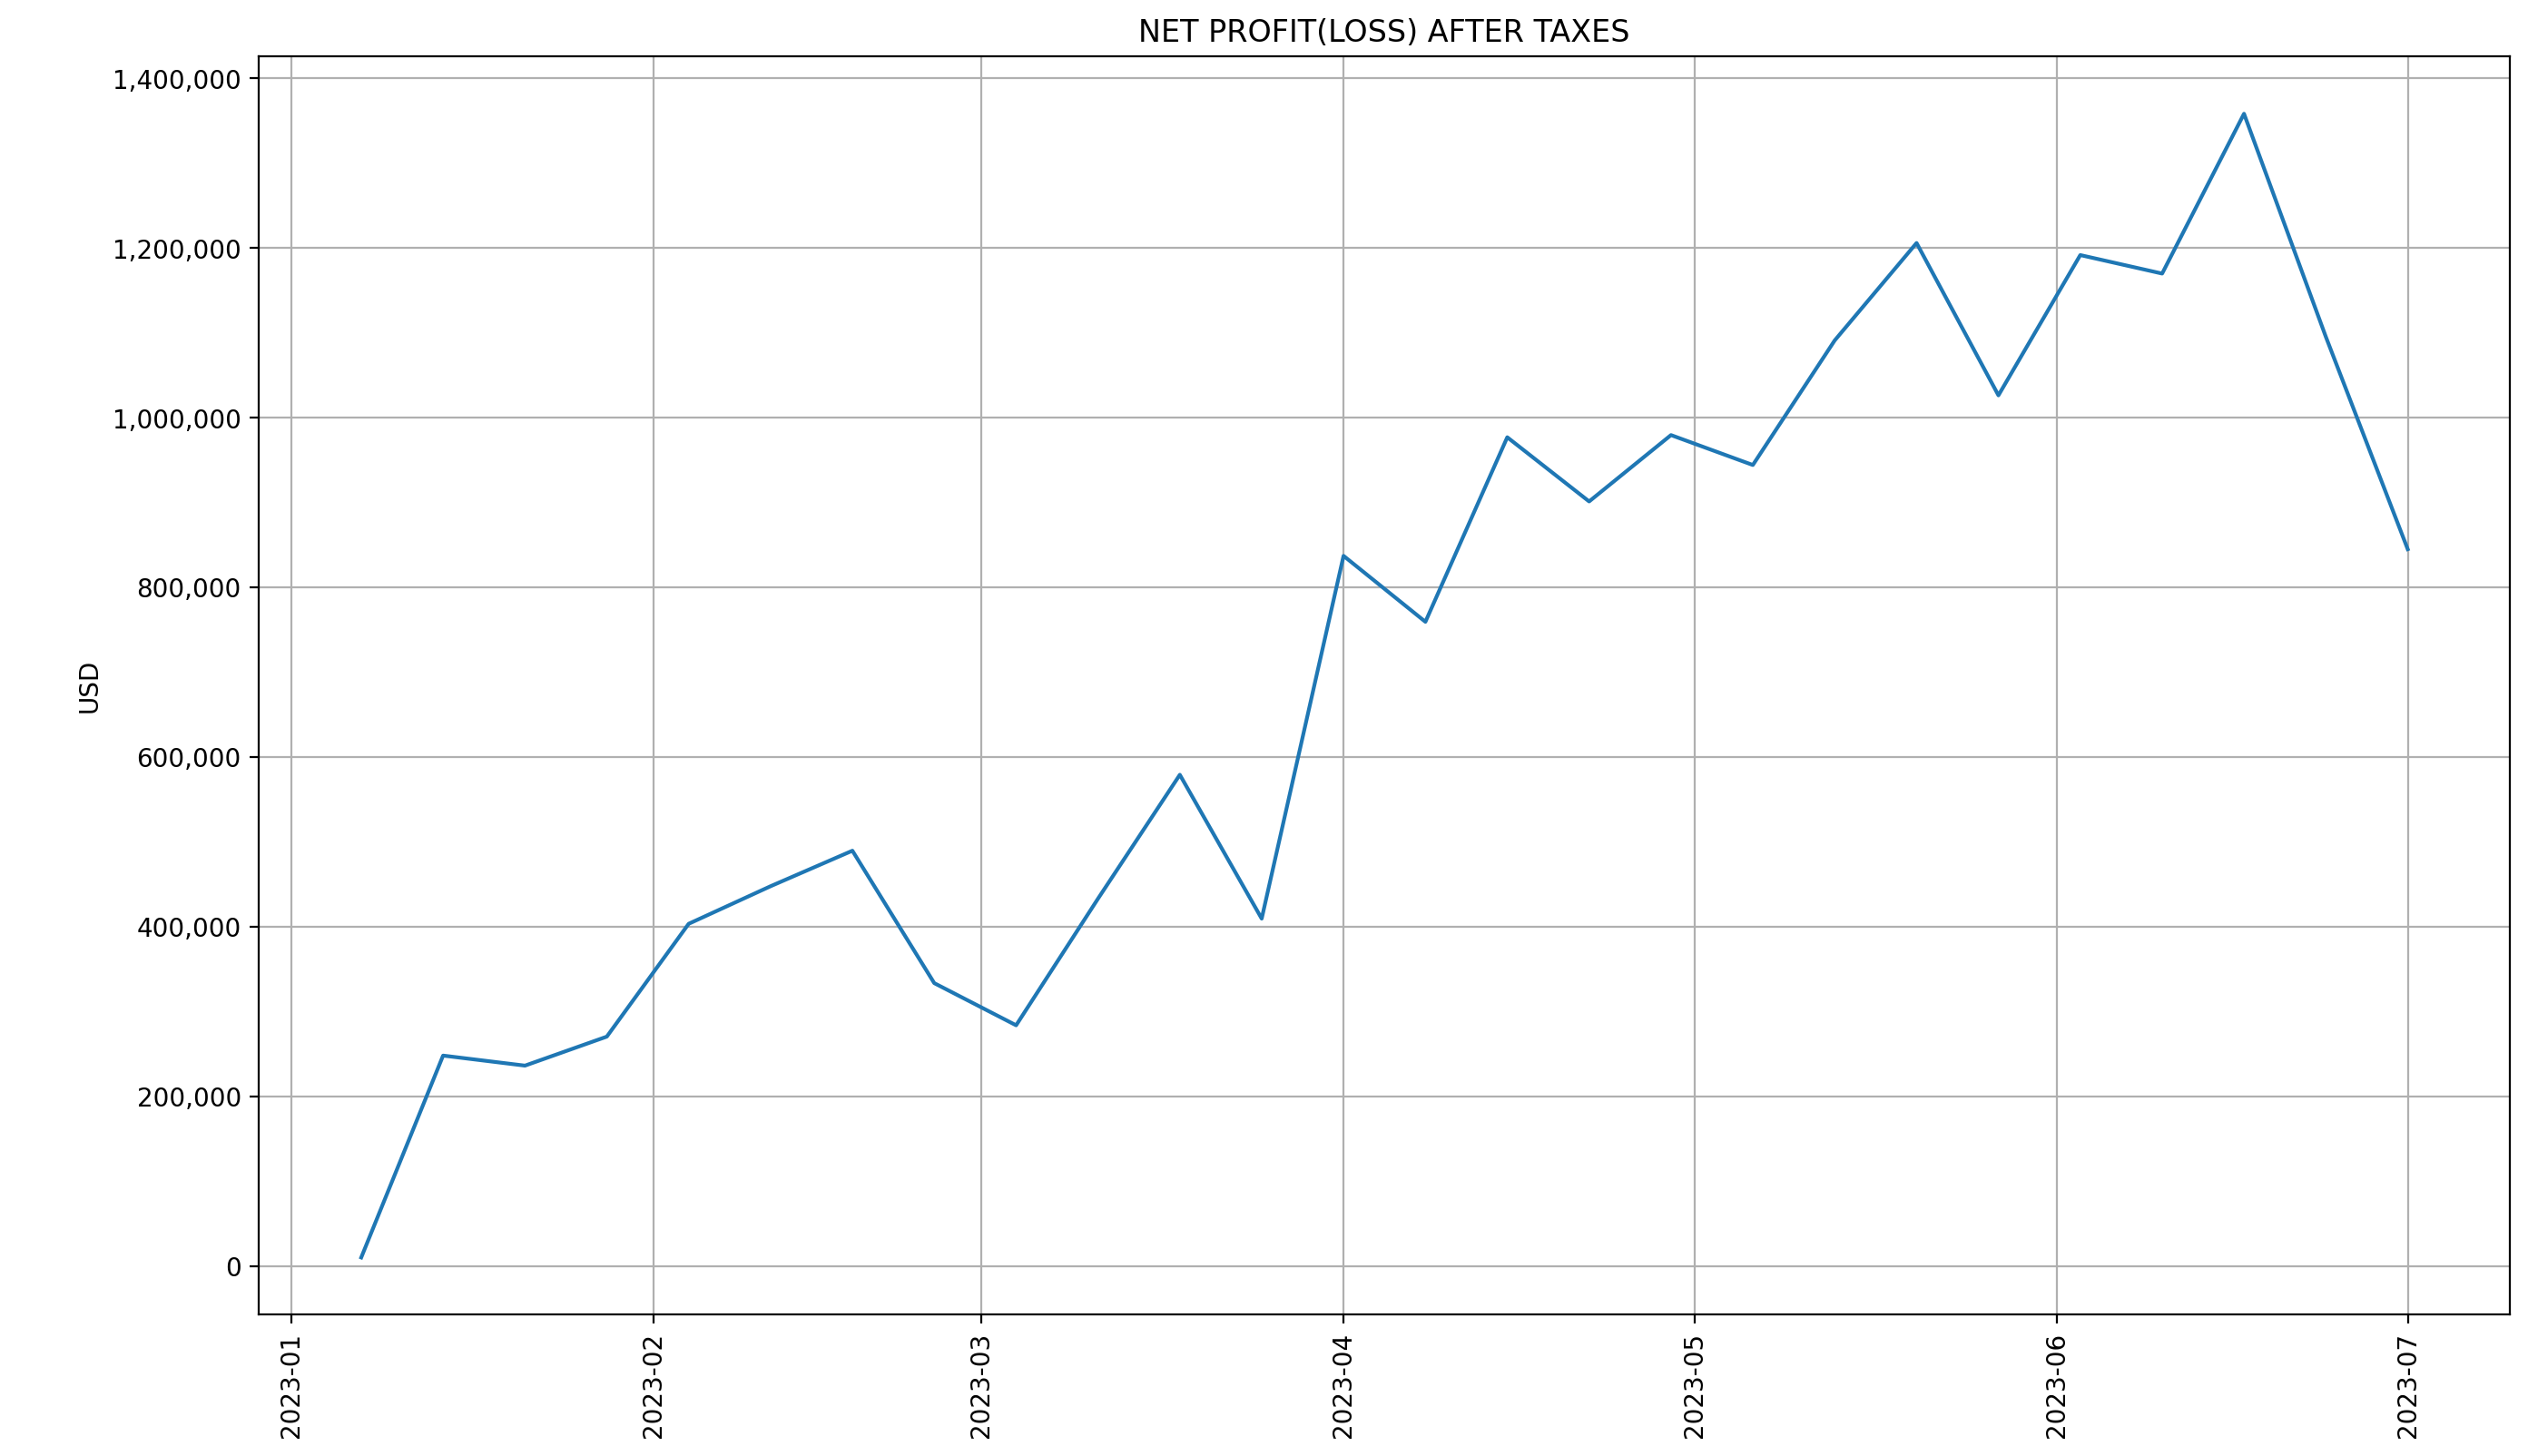

In [18]:
plot_line(pl[pl['Date'] >= '2023-01-1'], 'NET PROFIT(LOSS) AFTER TAXES', True)

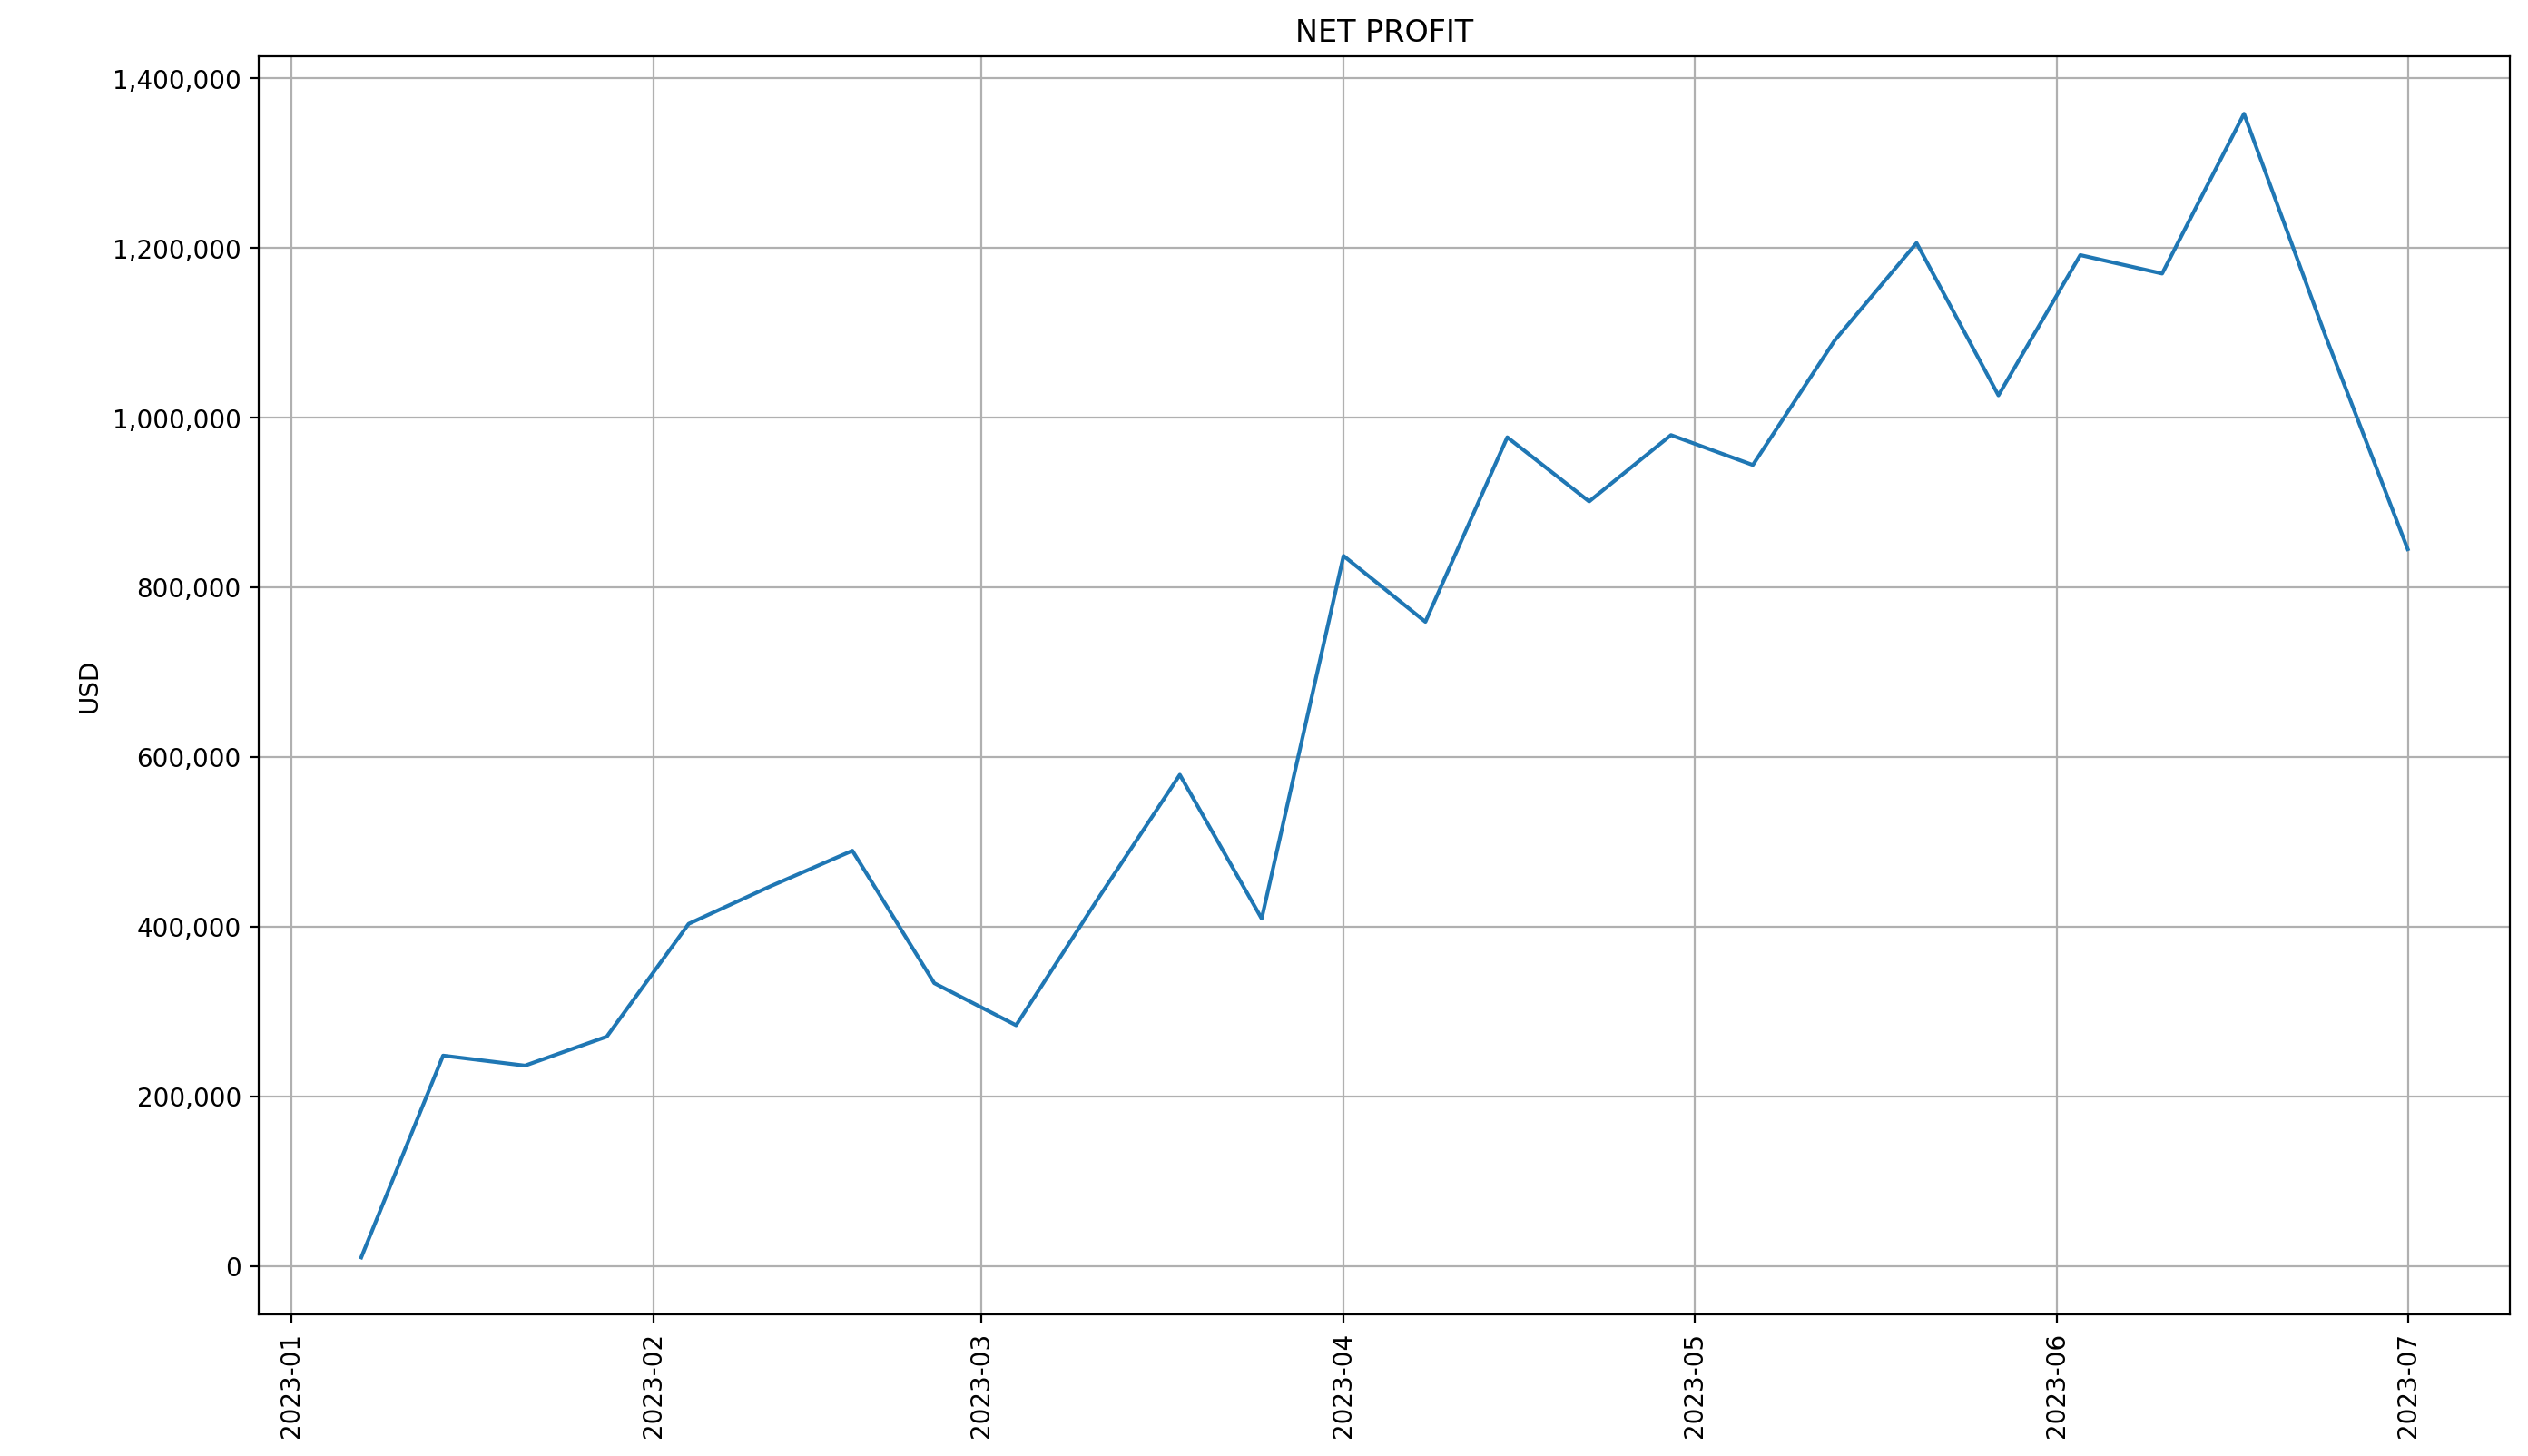

In [19]:
plot_line(bs[bs['Date'] >= '2023-01-1'], 'Cr_--NET PROFIT', False)

## Balance Sheet

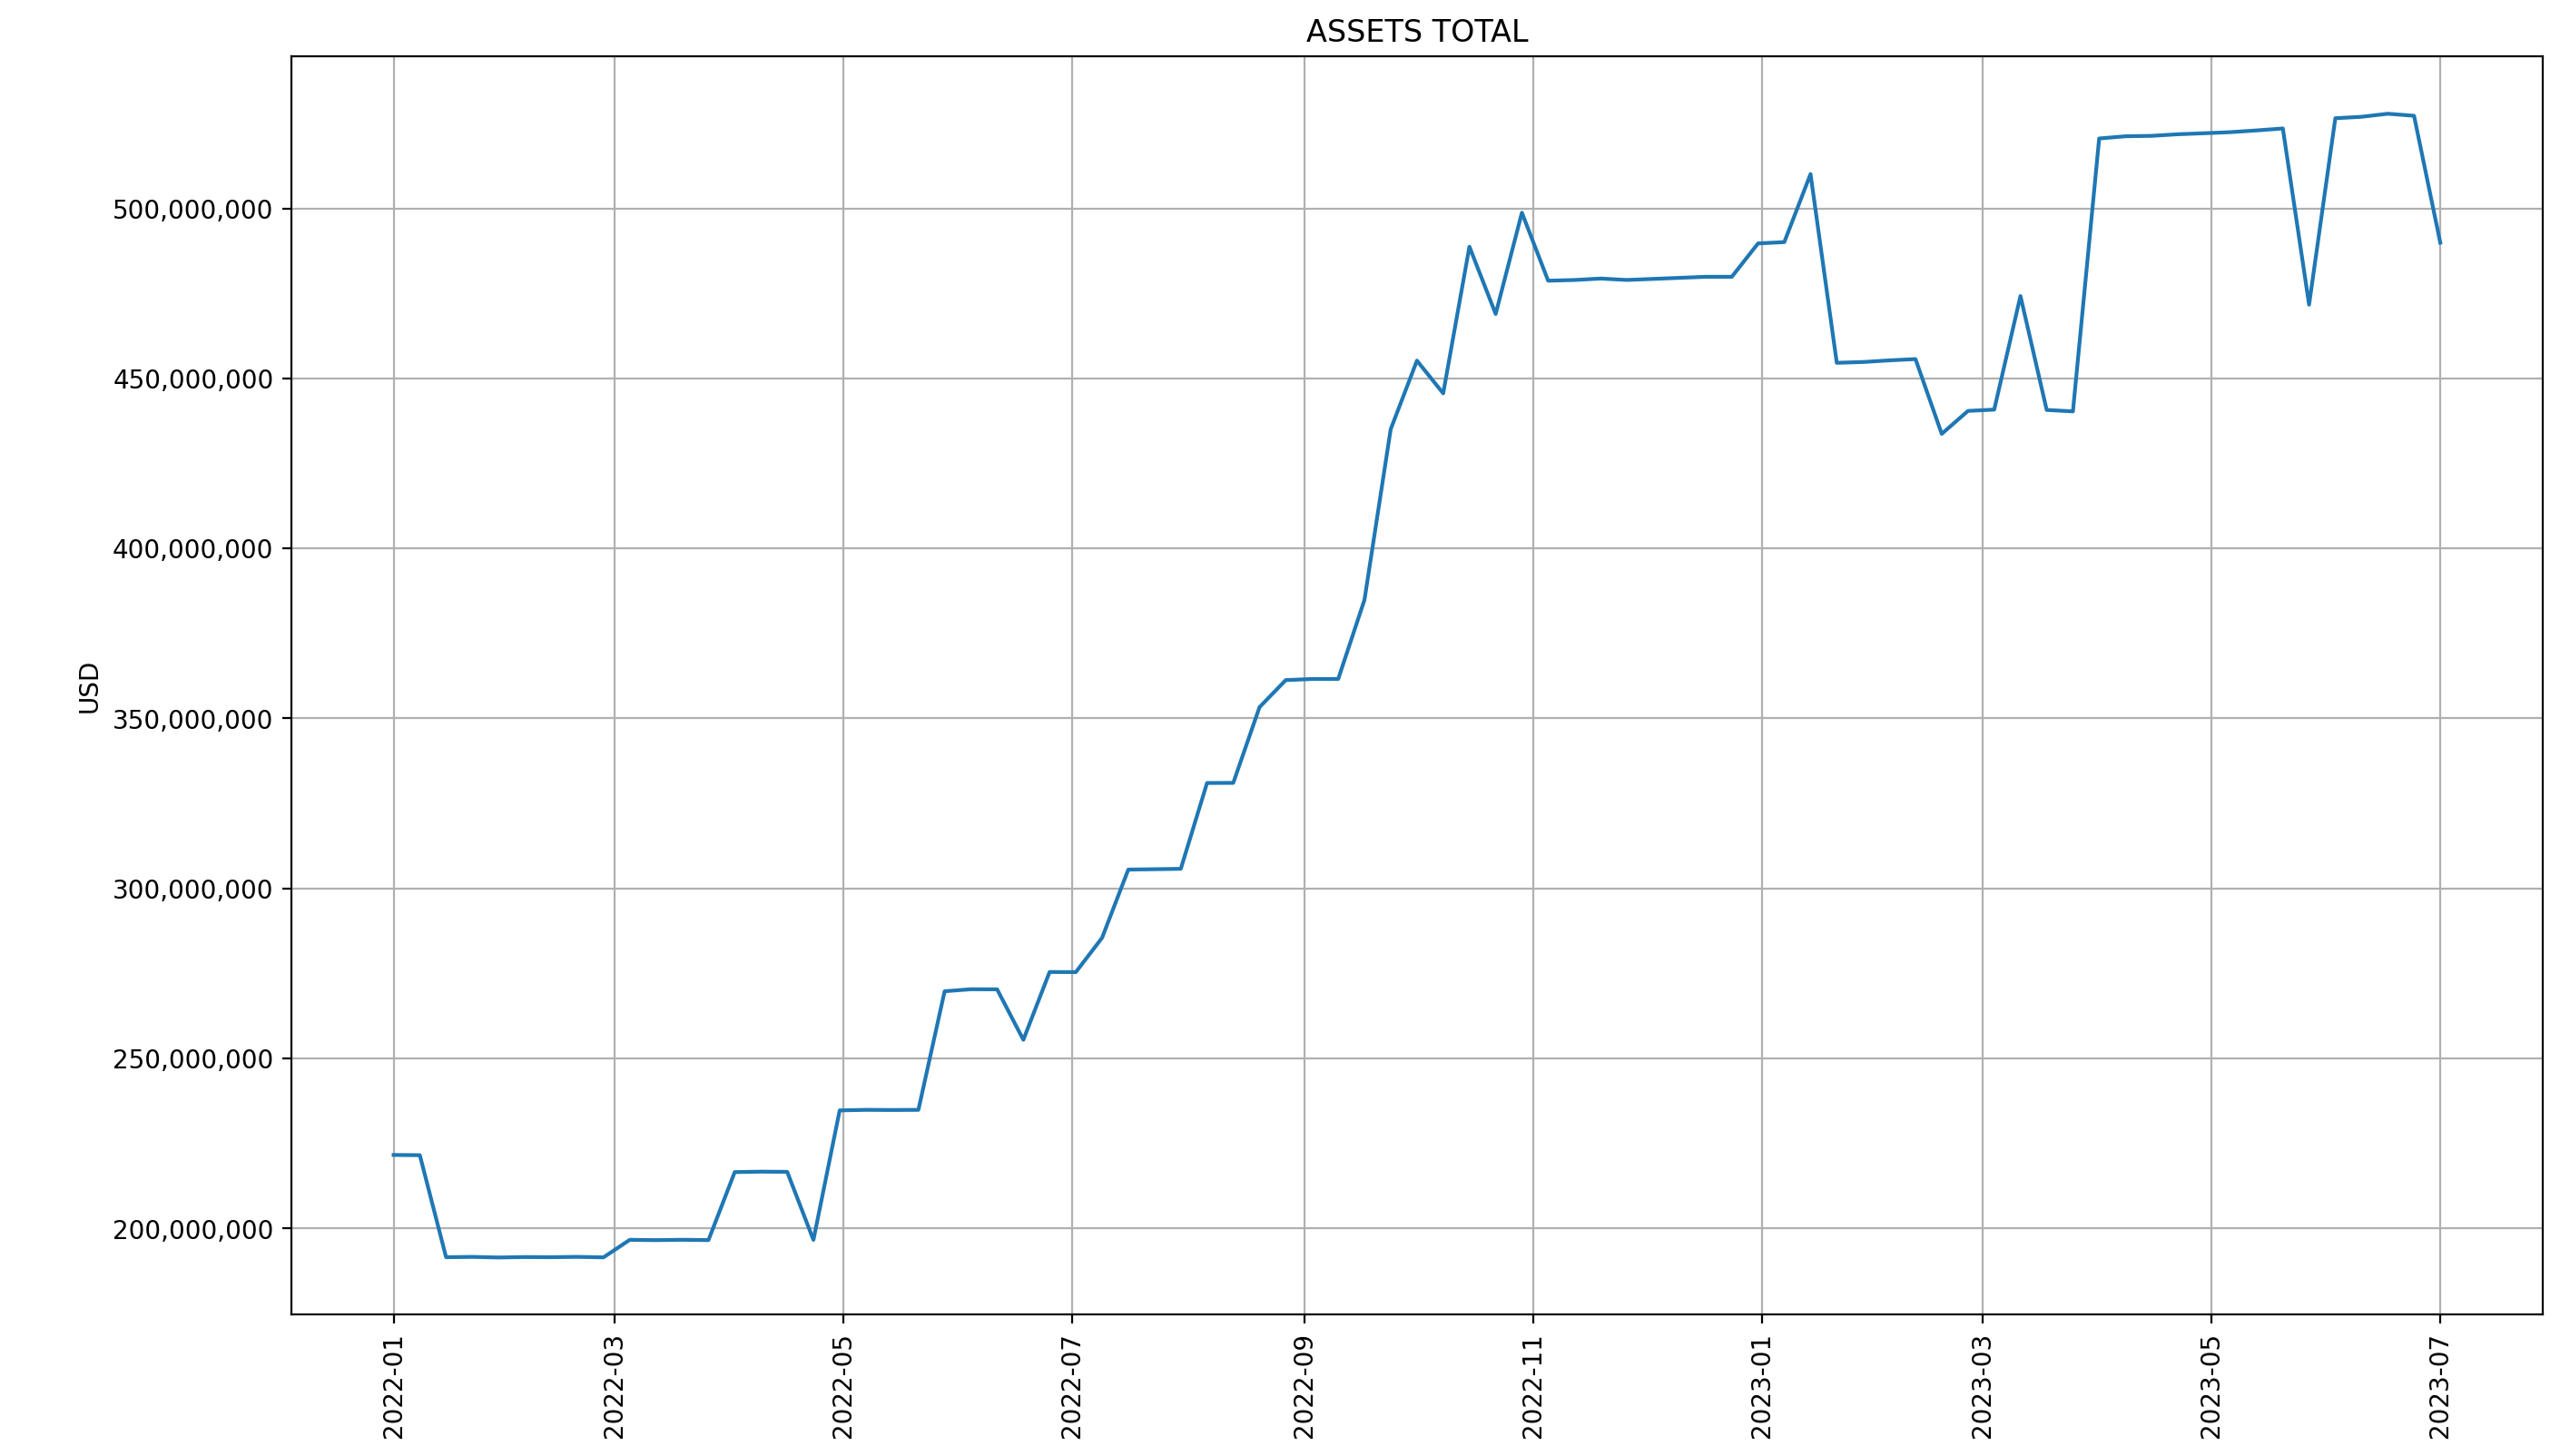

In [20]:
plot_line(bs, 'Dr_*ASSETS TOTAL', False)

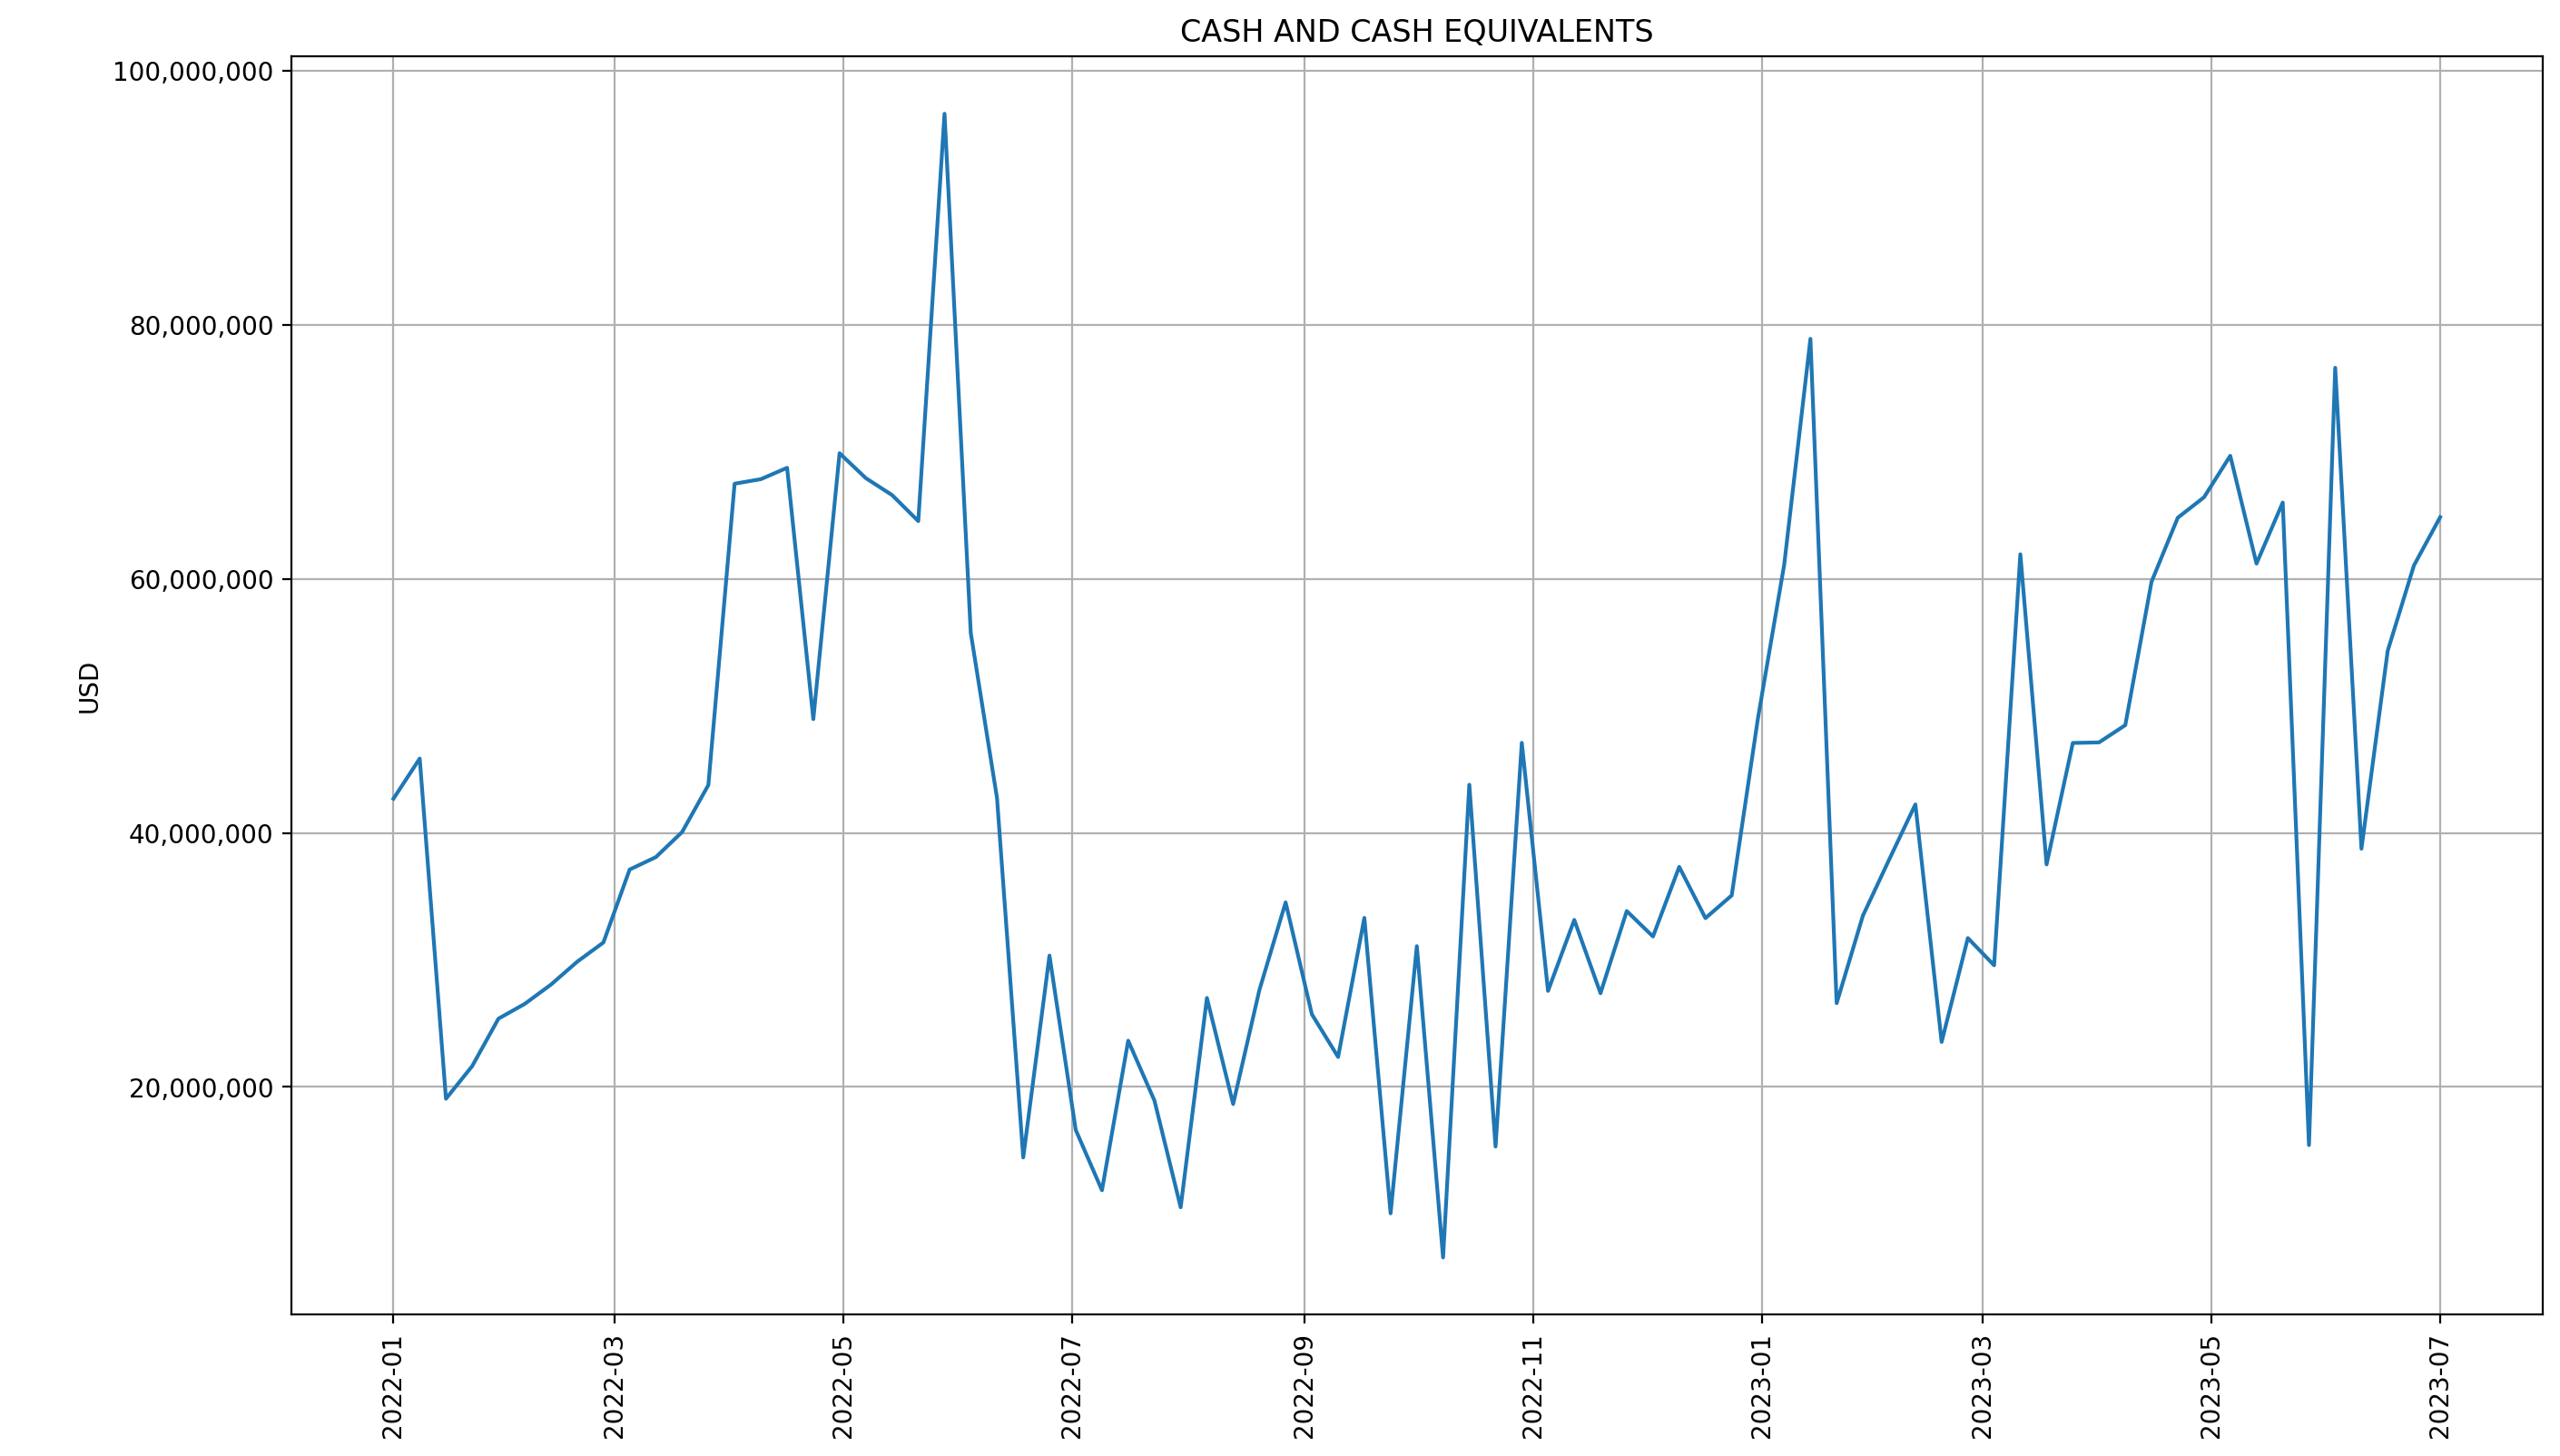

In [21]:
plot_line(bs, 'CASH AND CASH EQUIVALENTS', True)

In [22]:
# Regression analysis
import statsmodels.api as sm
pl['intercept'] = 1
lm = sm.OLS(pl['TOTAL INCOME'], pl[['intercept', 'TOTAL SG&A EXPENSE']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TOTAL INCOME   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     44.77
Date:                Sun, 09 Jul 2023   Prob (F-statistic):           3.17e-09
Time:                        13:37:54   Log-Likelihood:                -1296.1
No. Observations:                  79   AIC:                             2596.
Df Residuals:                      77   BIC:                             2601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept            1.88e+06   6.46e+05      2.911      0.005    5.94e+05    3.17e+06
TOTAL SG&A EXPENSE     1.6097      0.241      6.691      0.000       1.131       2.089
==============================================================================
Omnibus:                       16.722   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.864
Skew:                           1.202   Prob(JB):                     4.86e-05
Kurtosis:                       3.507   Cond. No.                     4.71e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Ratio Analysis

In [23]:
bs = bs[bs['Date'] >= '2023-01-1']

In [24]:
pl = pl[pl['Date'] >= '2023-01-1']

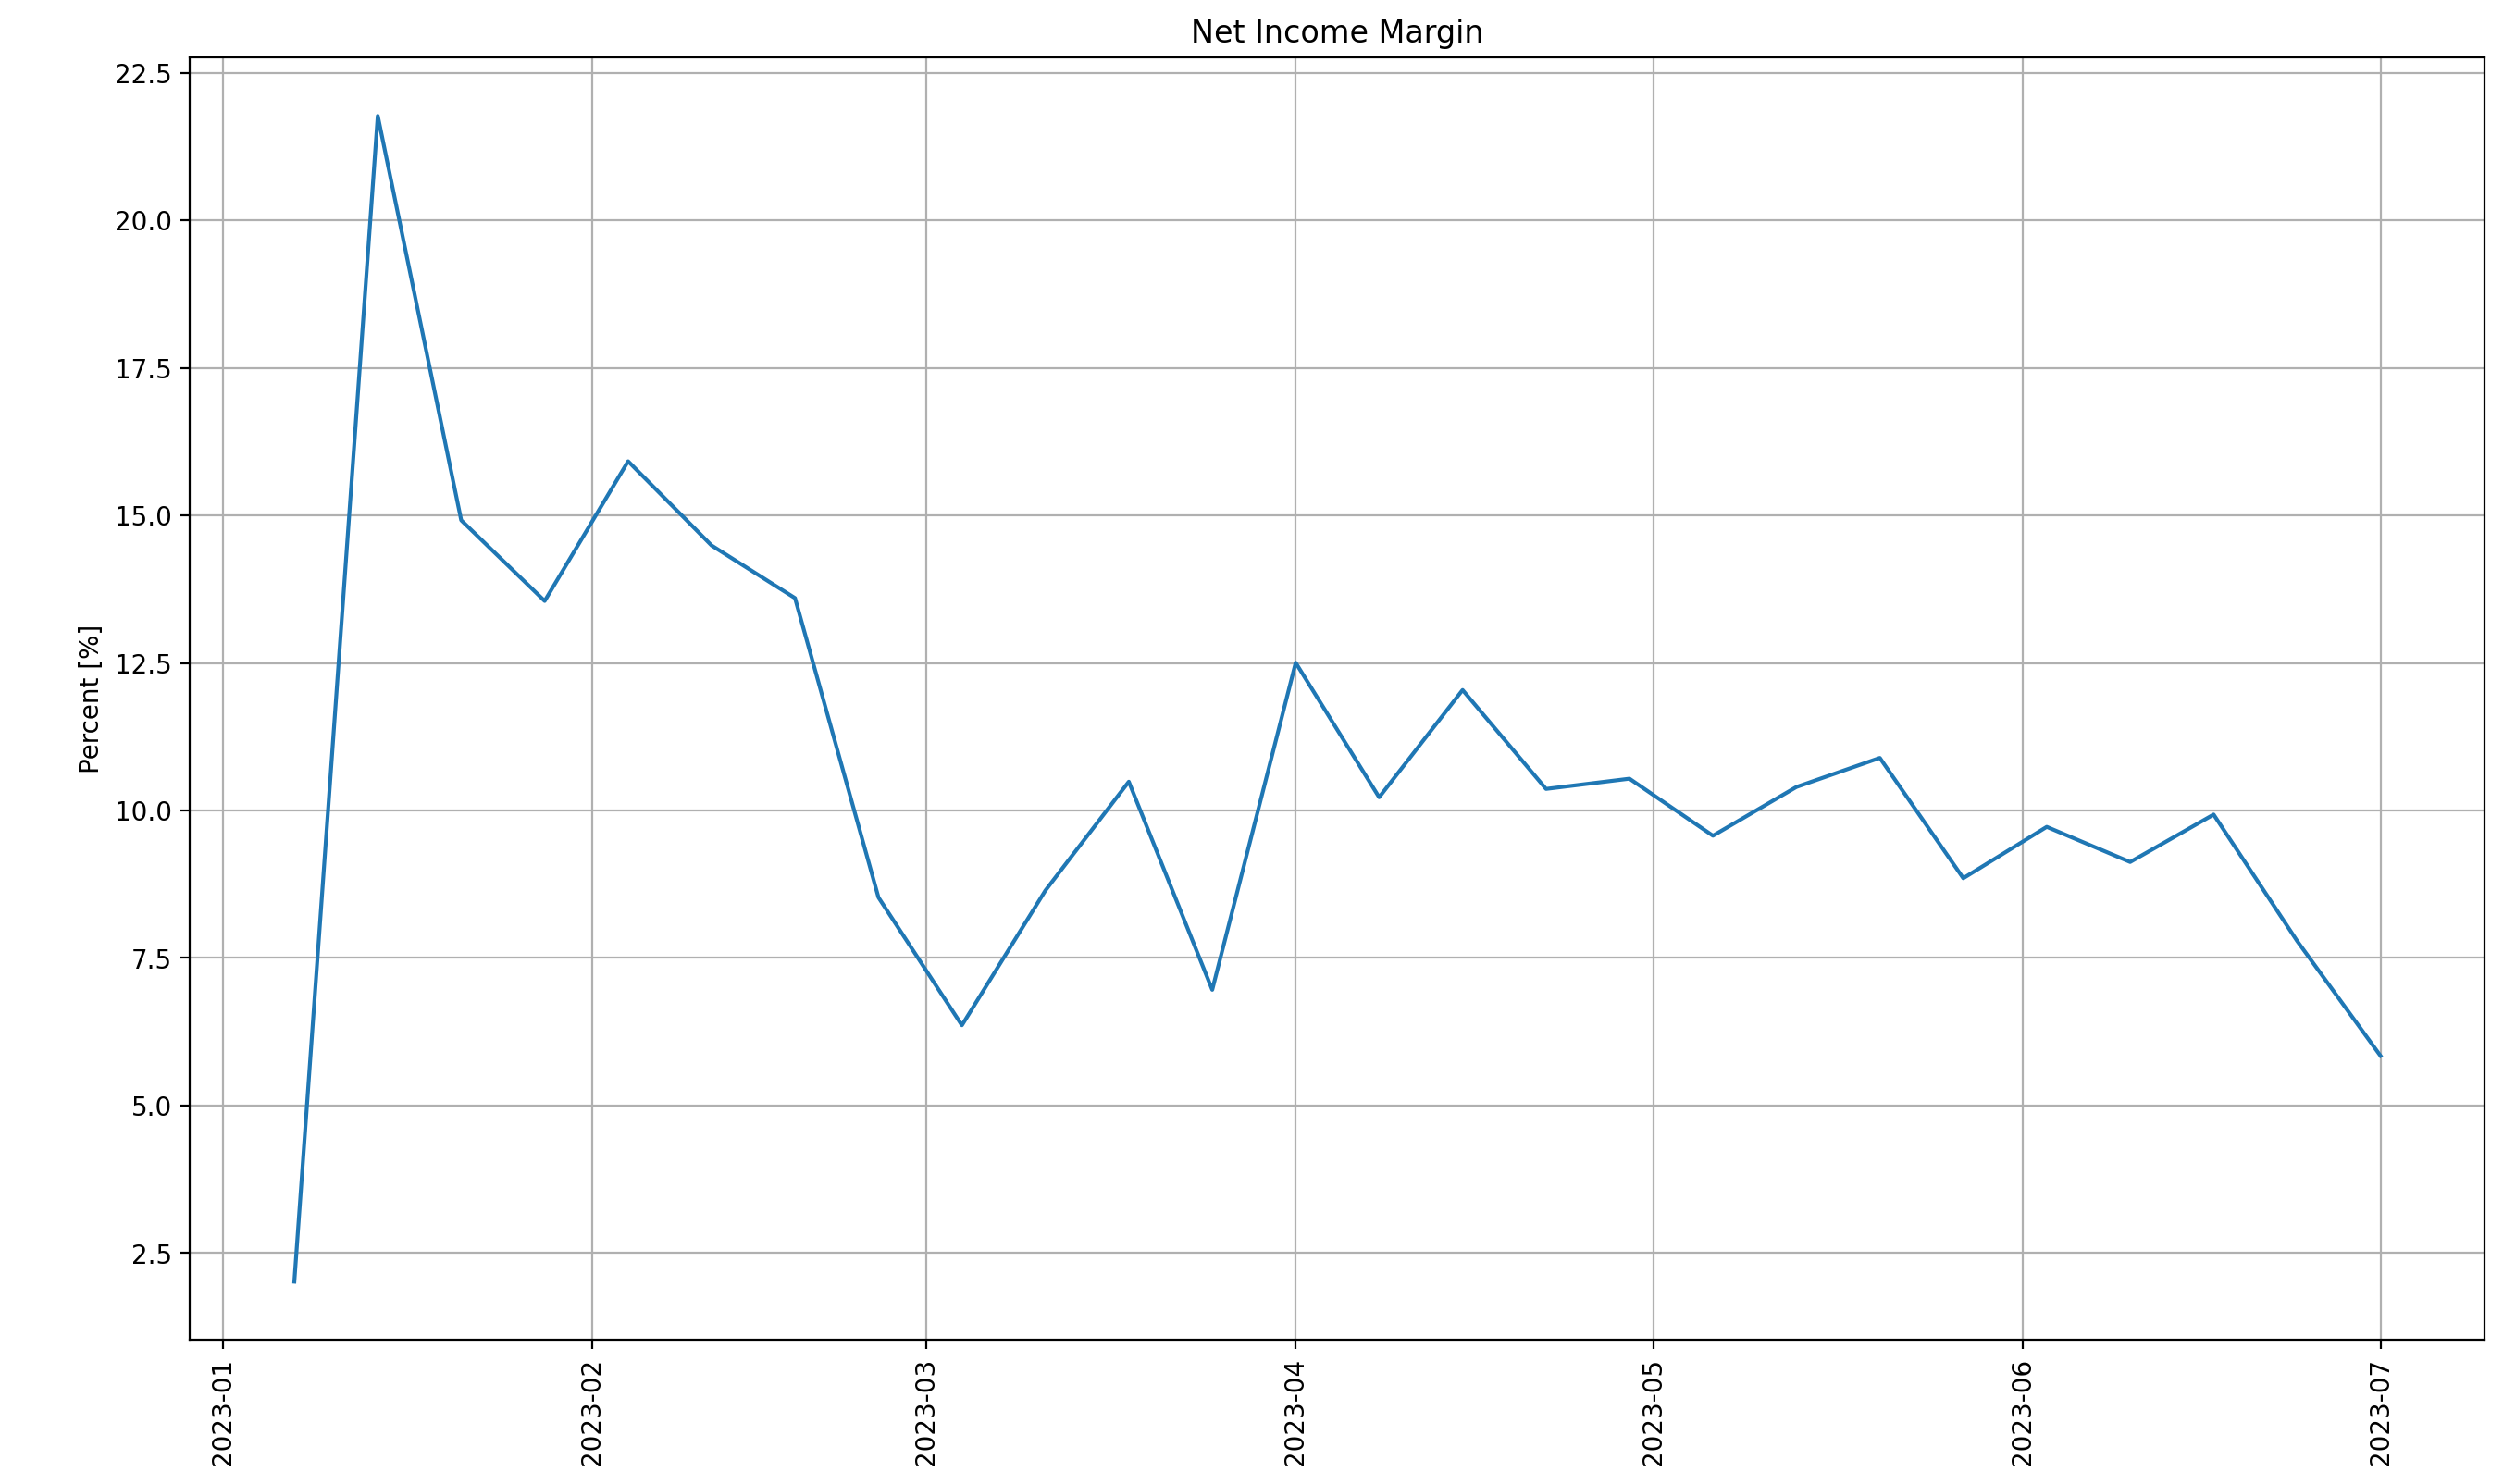

In [25]:
plot_line(pl, 'Net Income Margin', True, True)

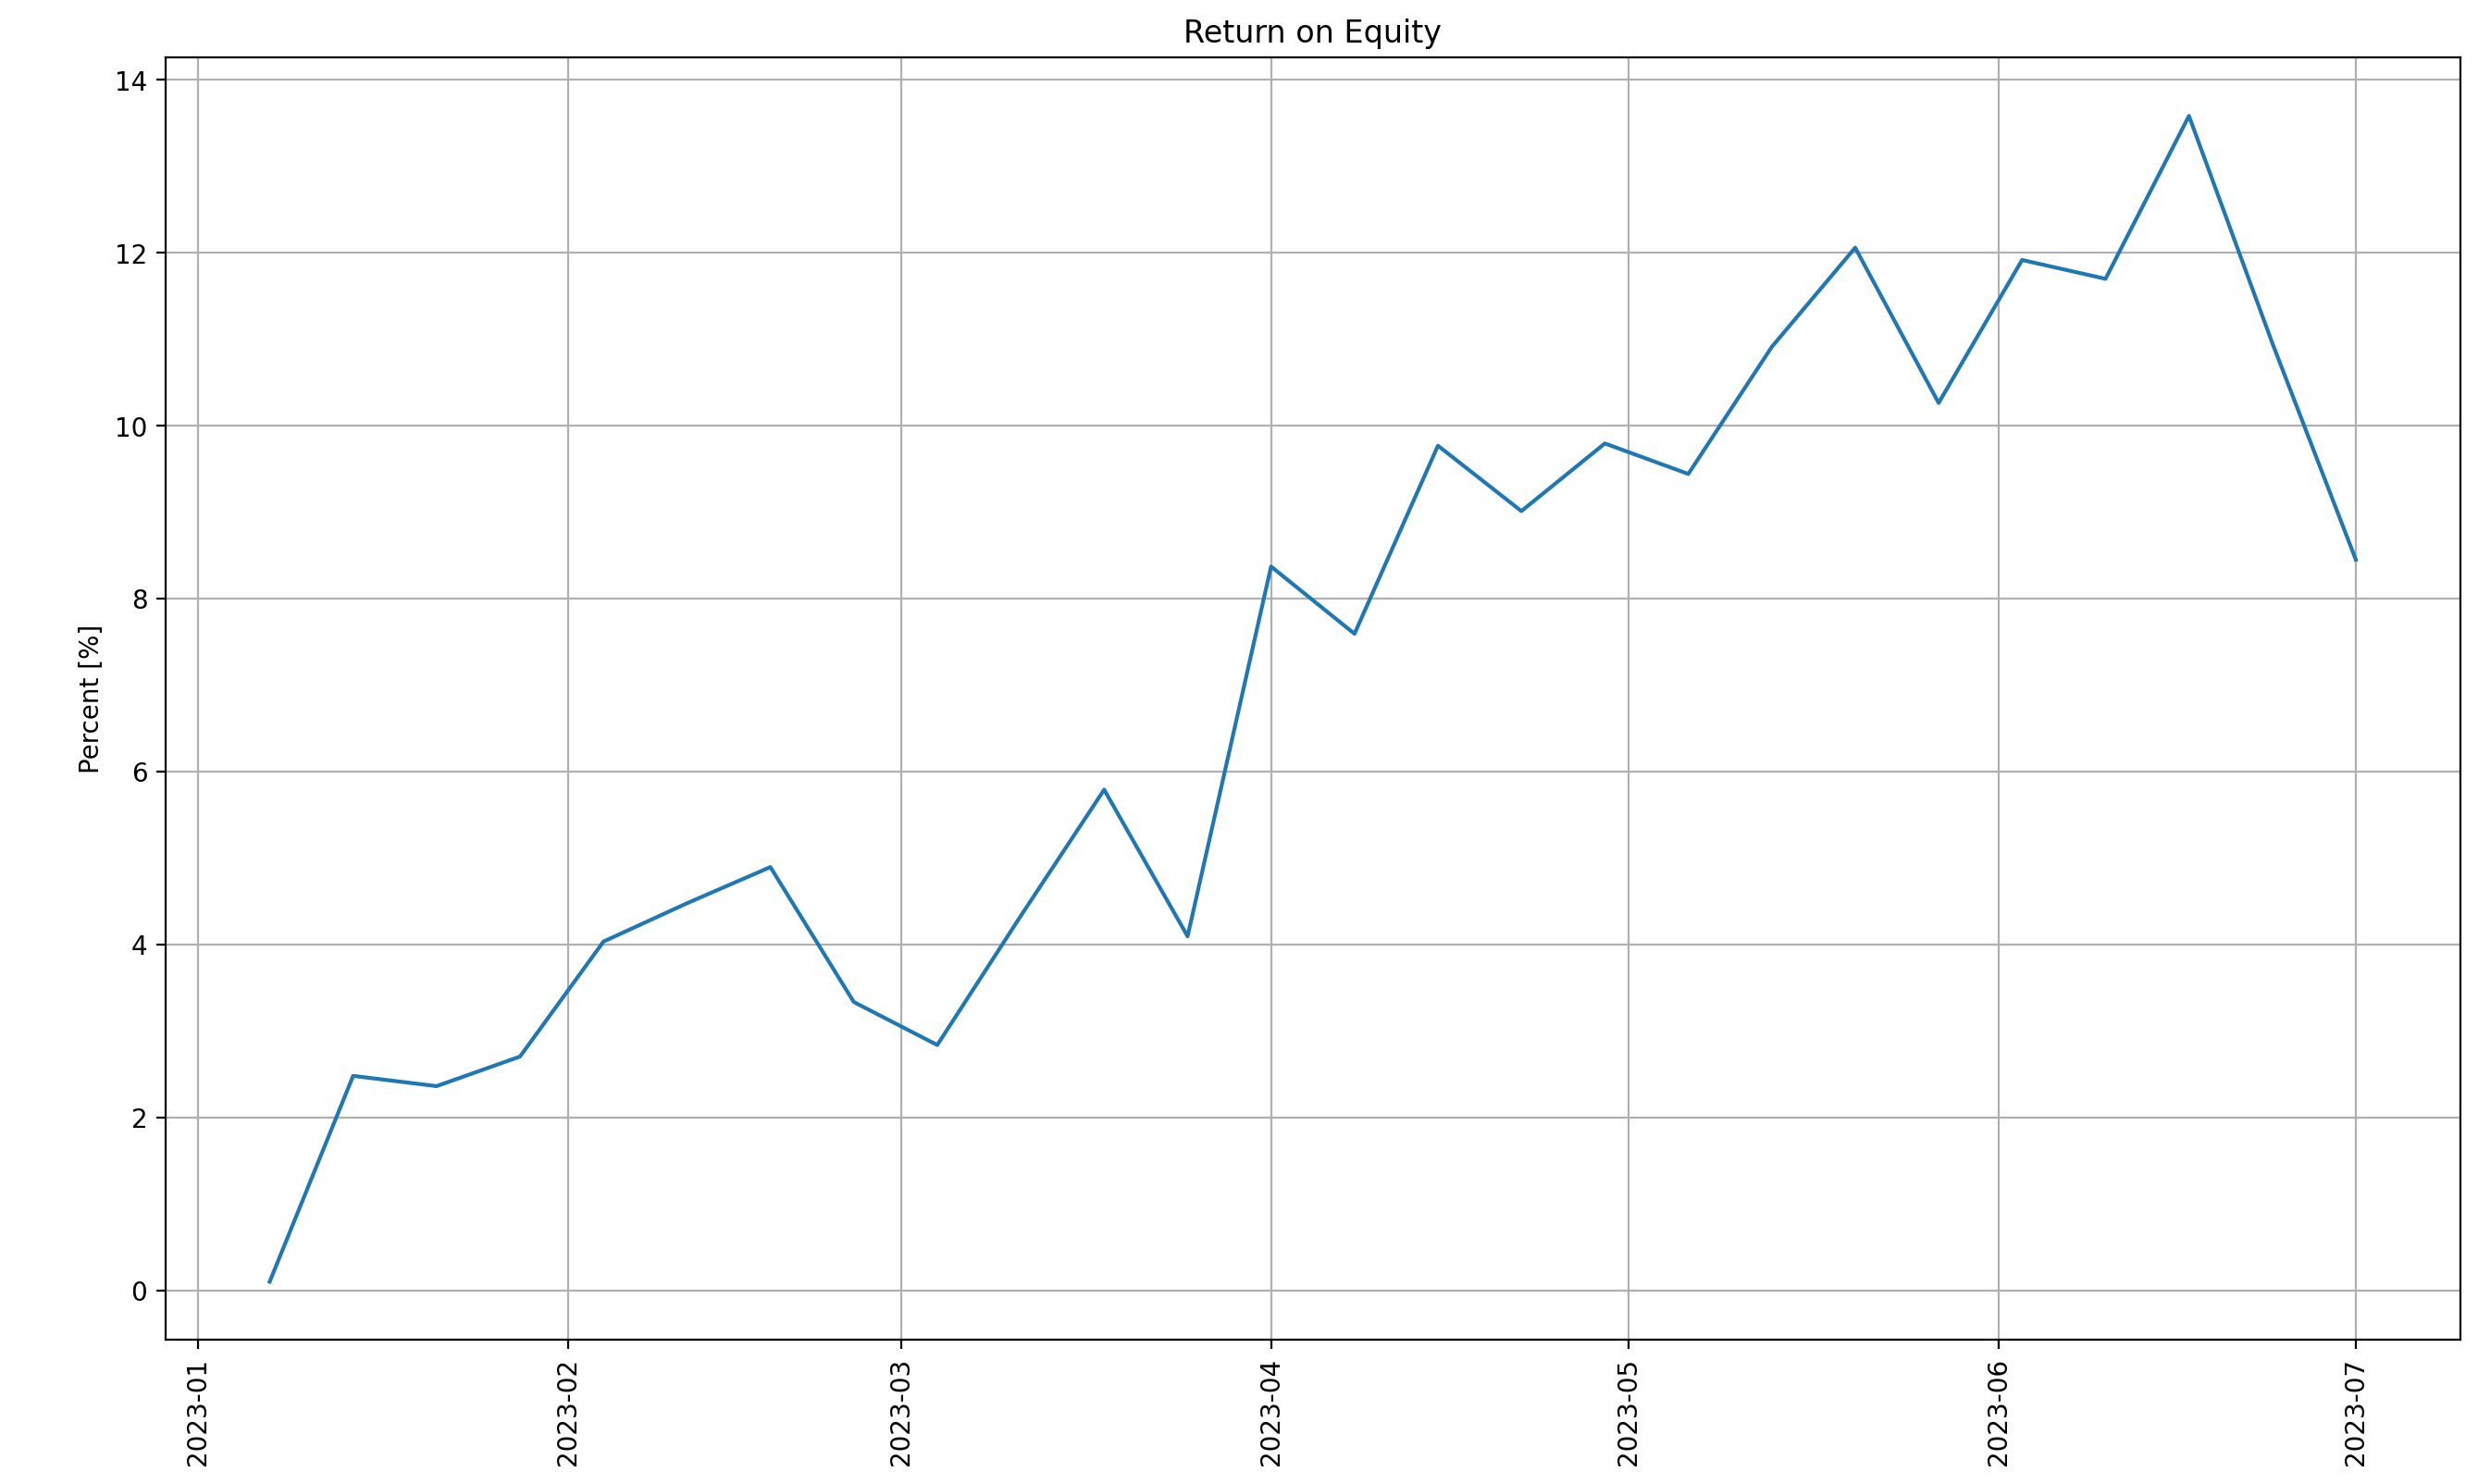

In [26]:
plot_line(bs, 'Return on Equity', True, True)

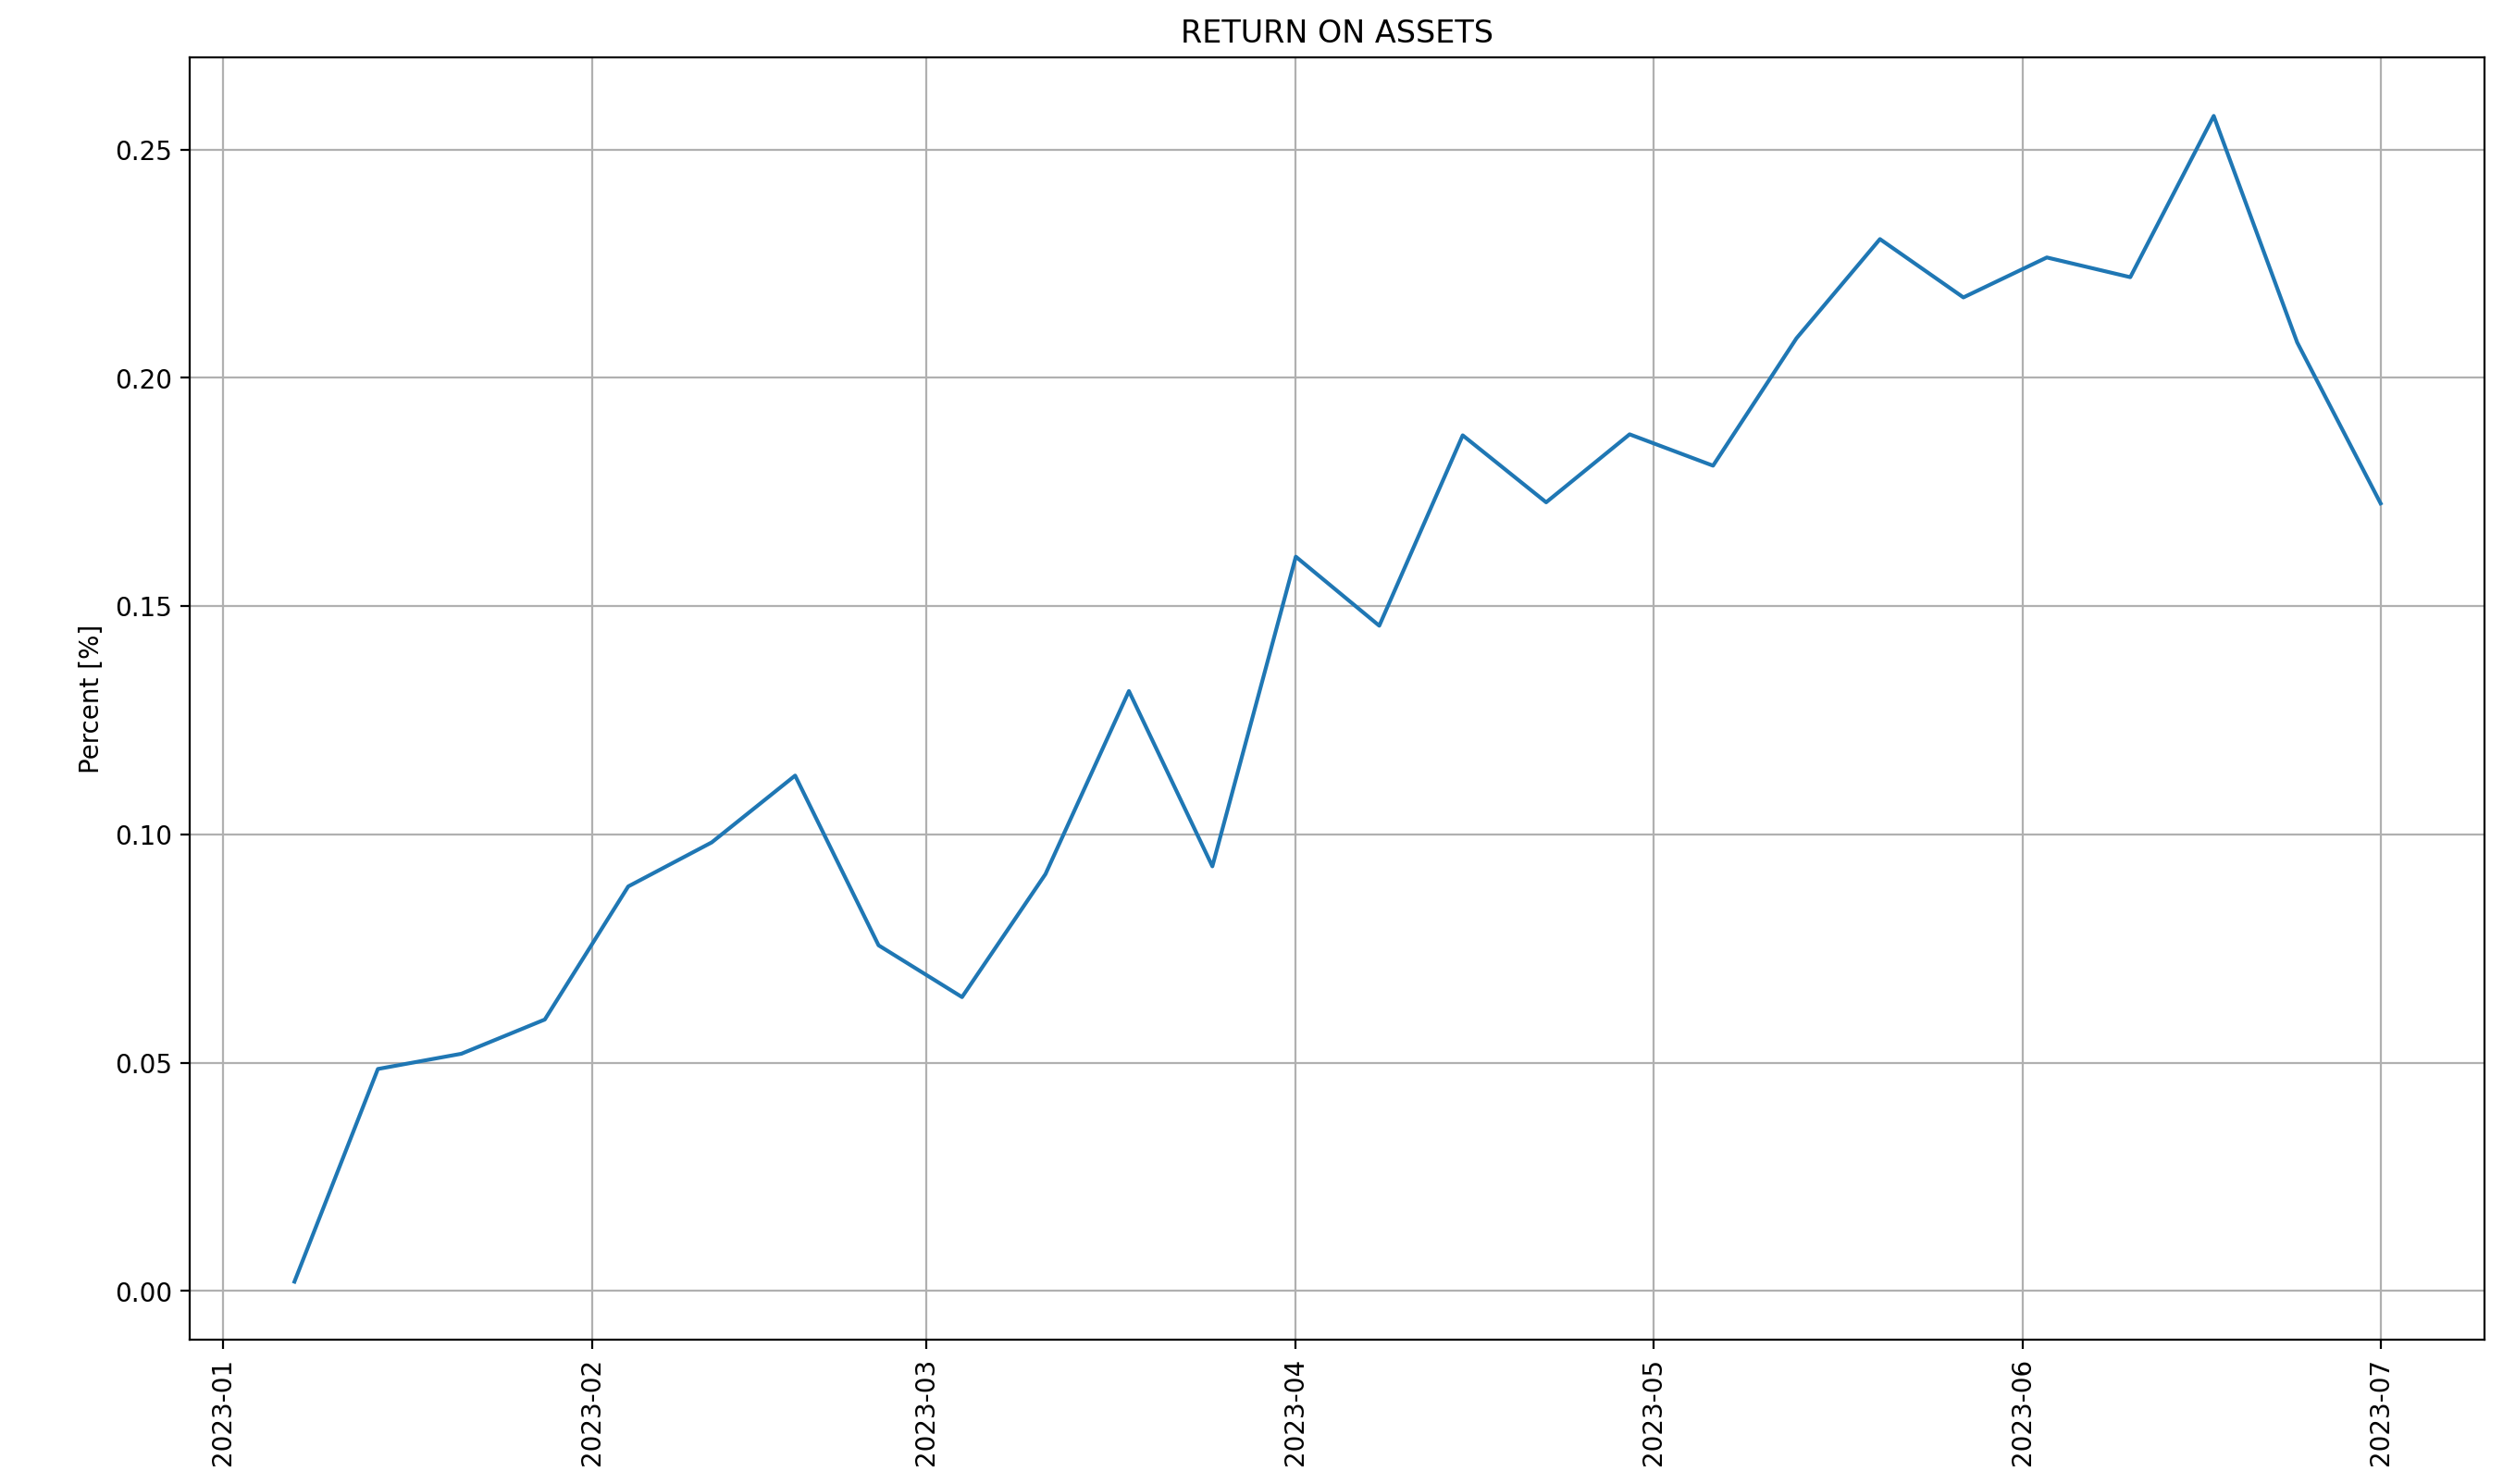

In [27]:
plot_line(bs, 'RETURN ON ASSETS', True, True)

# Prediction

In [28]:
def pred_lr(df):
    df = df.drop(columns = ['Date'])

    # features to predict
    pred_features = df[-1:].drop(columns = ['NET PROFIT(LOSS) AFTER TAXES'])

    # features to train &test
    df = df[:-1]         

    # outcome 
    outcomes = df.pop('NET PROFIT(LOSS) AFTER TAXES').values
    # filter out unwanted columns
    features = df.values

    X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.1, random_state = 0)

    mse_opt = {}
    for degree_value in range(1,4):    
        # find the poly degree having the lowest MSE
        poly_feat = PolynomialFeatures(degree = degree_value)
        X_train_poly = poly_feat.fit_transform(X_train)
        X_test_poly = poly_feat.transform(X_test)
        poly_model = LinearRegression(fit_intercept = False).fit(X_train_poly, y_train)
        y_pred = poly_model.predict(X_test_poly)
        mse = mean_squared_error(y_test, y_pred)
        mse_opt[degree_value] = mse

    mse = pd.DataFrame([mse_opt]).T
    mse.rename(columns = {0:'mse'}, inplace = True)
    mse = mse.reset_index()
    degree_opt = mse[mse['mse'] == mse.mse.min()]['index'].values[0]

    poly_feat = PolynomialFeatures(degree = degree_opt)
    X_train_poly = poly_feat.fit_transform(X_train)
    X_test_poly = poly_feat.transform(X_test)
    poly_model = LinearRegression(fit_intercept = False).fit(X_train_poly, y_train)
    y_pred = poly_model.predict(X_test_poly)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    pred_features_poly = poly_feat.fit_transform(pred_features)
    prediction = float(poly_model.predict(pred_features_poly)[0])
    return [int(features.shape[0]-1), degree_opt, r2, mse, prediction]

## Data processing

In [29]:
pl = pl_all.copy()
# Subtract one day from the datetime column
pl['Date'] = pl['Date'] - timedelta(days=1)
snp = pd.read_csv('predict_aim_sourcedata_snp.csv')
snp['Date'] = pd.to_datetime(snp['Date'], format='%Y-%m-%d')
df = pd.merge(pl, snp, on = 'Date', how = 'left')
df = df.dropna()

In [30]:
# Regression analysis
import statsmodels.api as sm
df['intercept'] = 1
lm = sm.OLS(df['NET PROFIT(LOSS) AFTER TAXES'], df[['intercept', 'Stock_price', 'Cpi', 'Jclaim', 'Int_rate', 'Inf', 'Cboe', 'Gold', 'Oil', 'Bitcoin', 'Dollar', 'Rgdp']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     NET PROFIT(LOSS) AFTER TAXES   R-squared:                       0.797
Model:                                      OLS   Adj. R-squared:                  0.763
Method:                           Least Squares   F-statistic:                     22.91
Date:                          Sun, 09 Jul 2023   Prob (F-statistic):           3.91e-18
Time:                                  13:37:55   Log-Likelihood:                -1039.6
No. Observations:                            76   AIC:                             2103.
Df Residuals:                                64   BIC:                             2131.
Df Model:                                    11                                         
Covariance Type:                      nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -3.845e+07    1.2e+07     -3.193      0.002   -6.25e+07   -1.44e+07
Stock_price  1072.9755    415.815      2.580      0.012     242.289    1903.662
Cpi          5.042e+04   3.11e+04      1.620      0.110   -1.18e+04    1.13e+05
Jclaim          8.0678      2.258      3.573      0.001       3.556      12.579
Int_rate    -2.893e+04   1.45e+05     -0.199      0.843   -3.19e+05    2.61e+05
Inf         -8.304e+05    3.1e+05     -2.680      0.009   -1.45e+06   -2.11e+05
Cboe         1.924e+04   1.64e+04      1.172      0.245   -1.35e+04     5.2e+04
Gold         -596.4958    915.977     -0.651      0.517   -2426.370    1233.378
Oil          3493.4317   4825.954      0.724      0.472   -6147.520    1.31e+04
Bitcoin        11.5150     10.395      1.108      0.272      -9.252      32.281
Dollar       2.941e+04   2.26e+04      1.302      0.198   -1.57e+04    7.45e+04
Rgdp          830.8156    655.903      1.267      0.210    -479.501    2141.132
==============================================================================
Omnibus:                        0.590   Durbin-Watson:                   0.860
Prob(Omnibus):                  0.744   Jarque-Bera (JB):                0.720
Skew:                          -0.114   Prob(JB):                        0.698
Kurtosis:                       2.582   Cond. No.                     1.01e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Regression analysis
import statsmodels.api as sm
df['intercept'] = 1
lm = sm.OLS(df['NET PROFIT(LOSS) AFTER TAXES'], df[['intercept', 'Stock_price', 'Cpi', 'Jclaim', 'Inf', 'Dollar']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     NET PROFIT(LOSS) AFTER TAXES   R-squared:                       0.779
Model:                                      OLS   Adj. R-squared:                  0.763
Method:                           Least Squares   F-statistic:                     49.30
Date:                          Sun, 09 Jul 2023   Prob (F-statistic):           1.33e-21
Time:                                  13:37:55   Log-Likelihood:                -1043.0
No. Observations:                            76   AIC:                             2098.
Df Residuals:                                70   BIC:                             2112.
Df Model:                                     5                                         
Covariance Type:                      nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -1.791e+07   2.45e+06     -7.318      0.000   -2.28e+07    -1.3e+07
Stock_price   877.1996    190.667      4.601      0.000     496.927    1257.472
Cpi          3.738e+04   6733.019      5.552      0.000     2.4e+04    5.08e+04
Jclaim          8.6444      2.161      4.001      0.000       4.335      12.953
Inf         -7.605e+05   1.66e+05     -4.591      0.000   -1.09e+06    -4.3e+05
Dollar       3.321e+04   1.16e+04      2.858      0.006       1e+04    5.64e+04
==============================================================================
Omnibus:                        2.508   Durbin-Watson:                   0.805
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.398
Skew:                          -0.425   Prob(JB):                        0.301
Kurtosis:                       2.811   Cond. No.                     2.04e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

=> Total records: 76
=> Null values: 0
=> Number of Duplicated values: 0


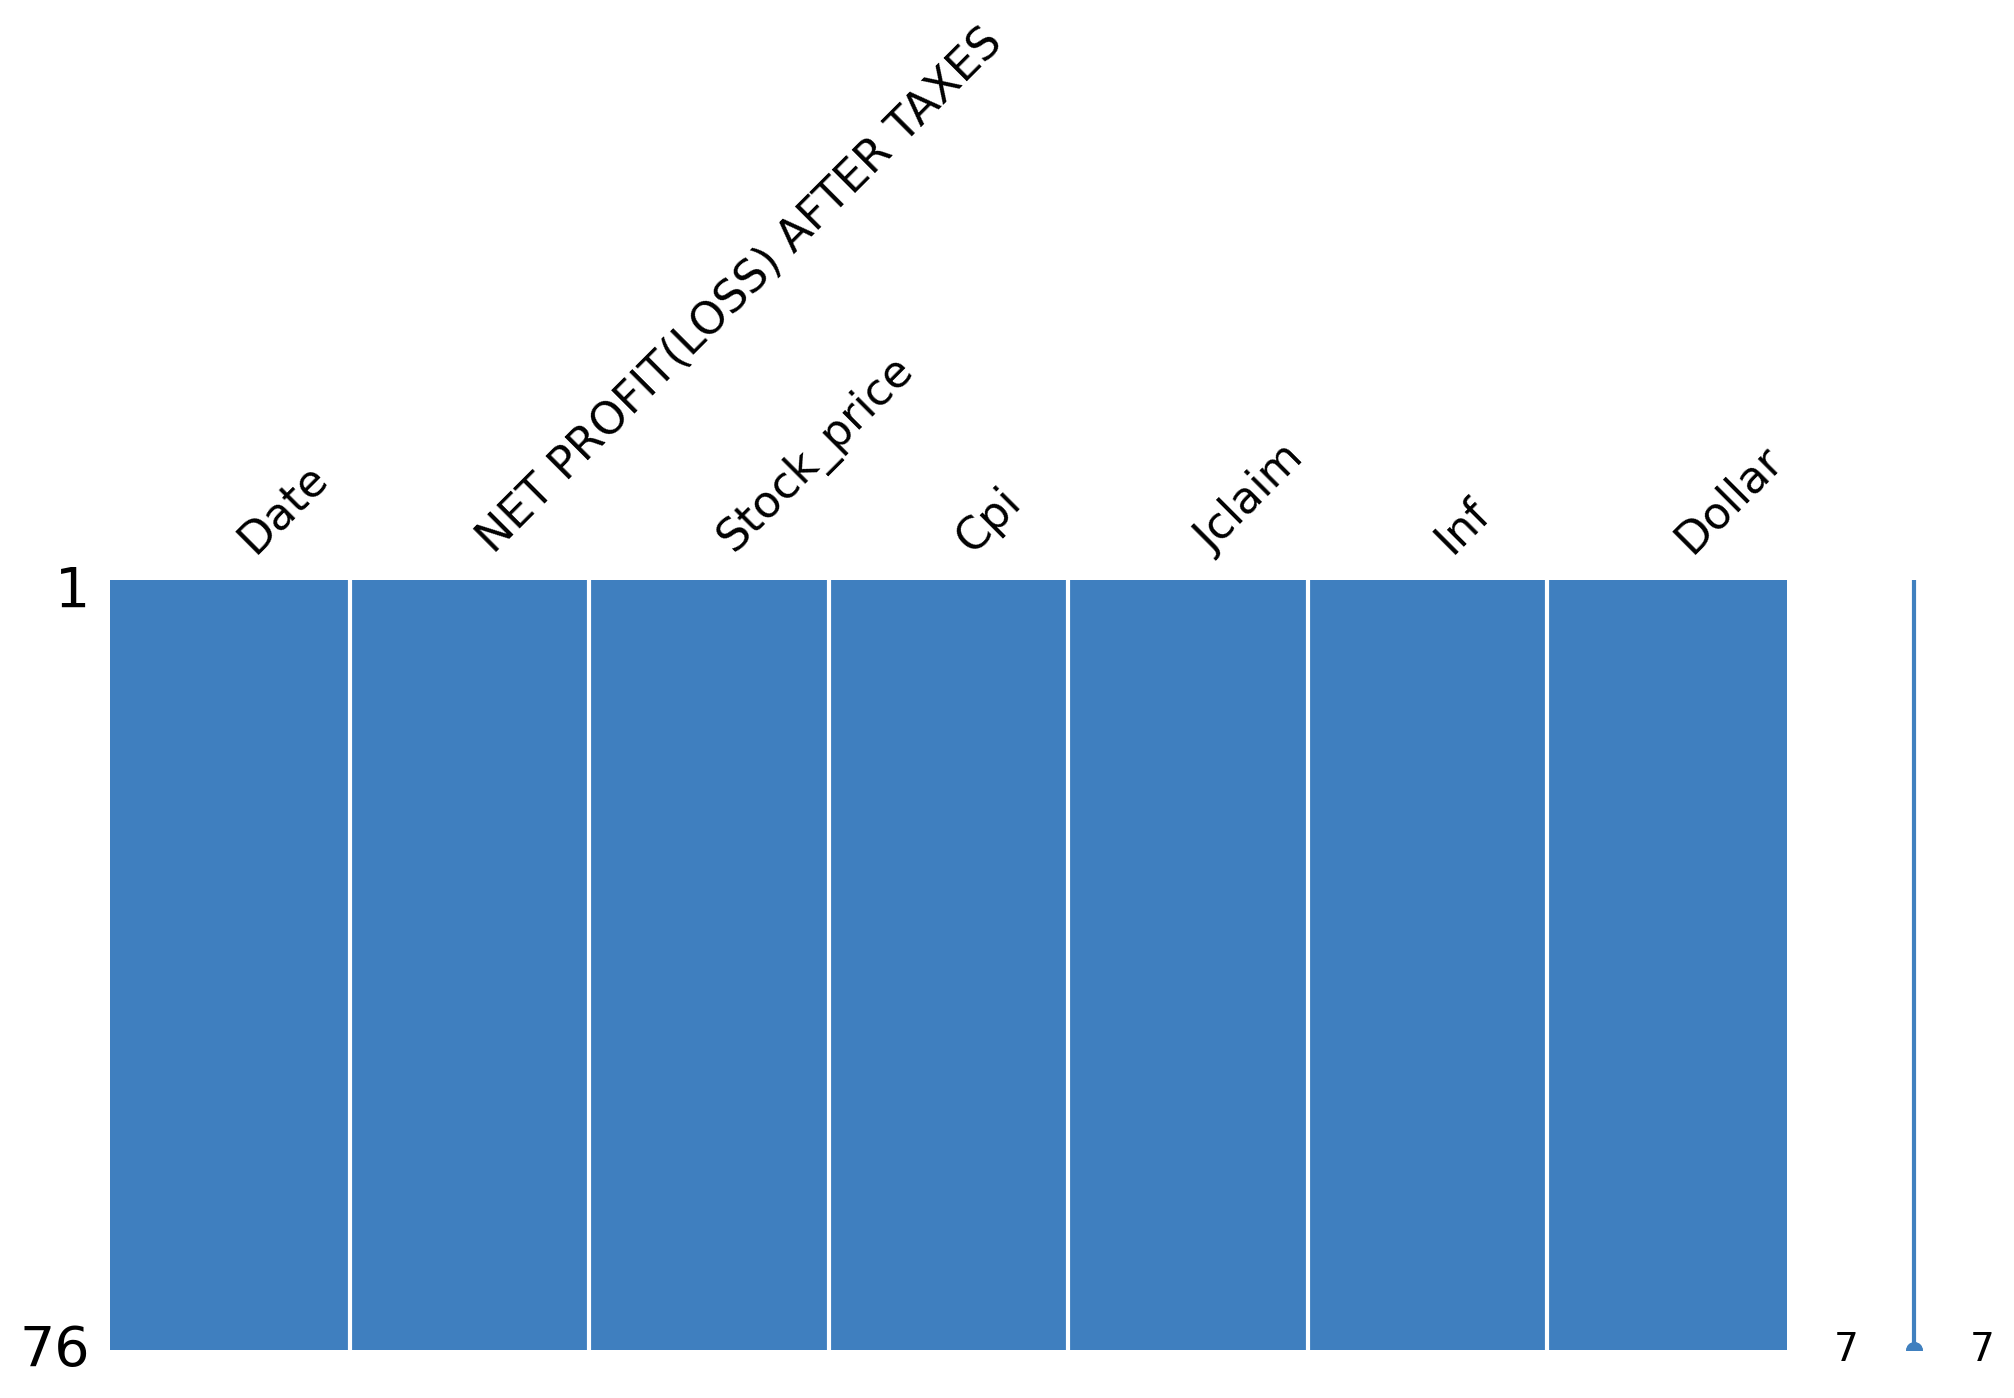

In [32]:
df = df[['Date', 'NET PROFIT(LOSS) AFTER TAXES', 'Stock_price', 'Cpi', 'Jclaim', 'Inf', 'Dollar']]

# initial check about missing and duplicated data
import missingno as msno
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"=> Total records: {df.shape[0]}")
print(f"=> Null values: {df.isna().sum().sum()}")
print(f"=> Number of Duplicated values: {df.duplicated().sum()}")

## Result

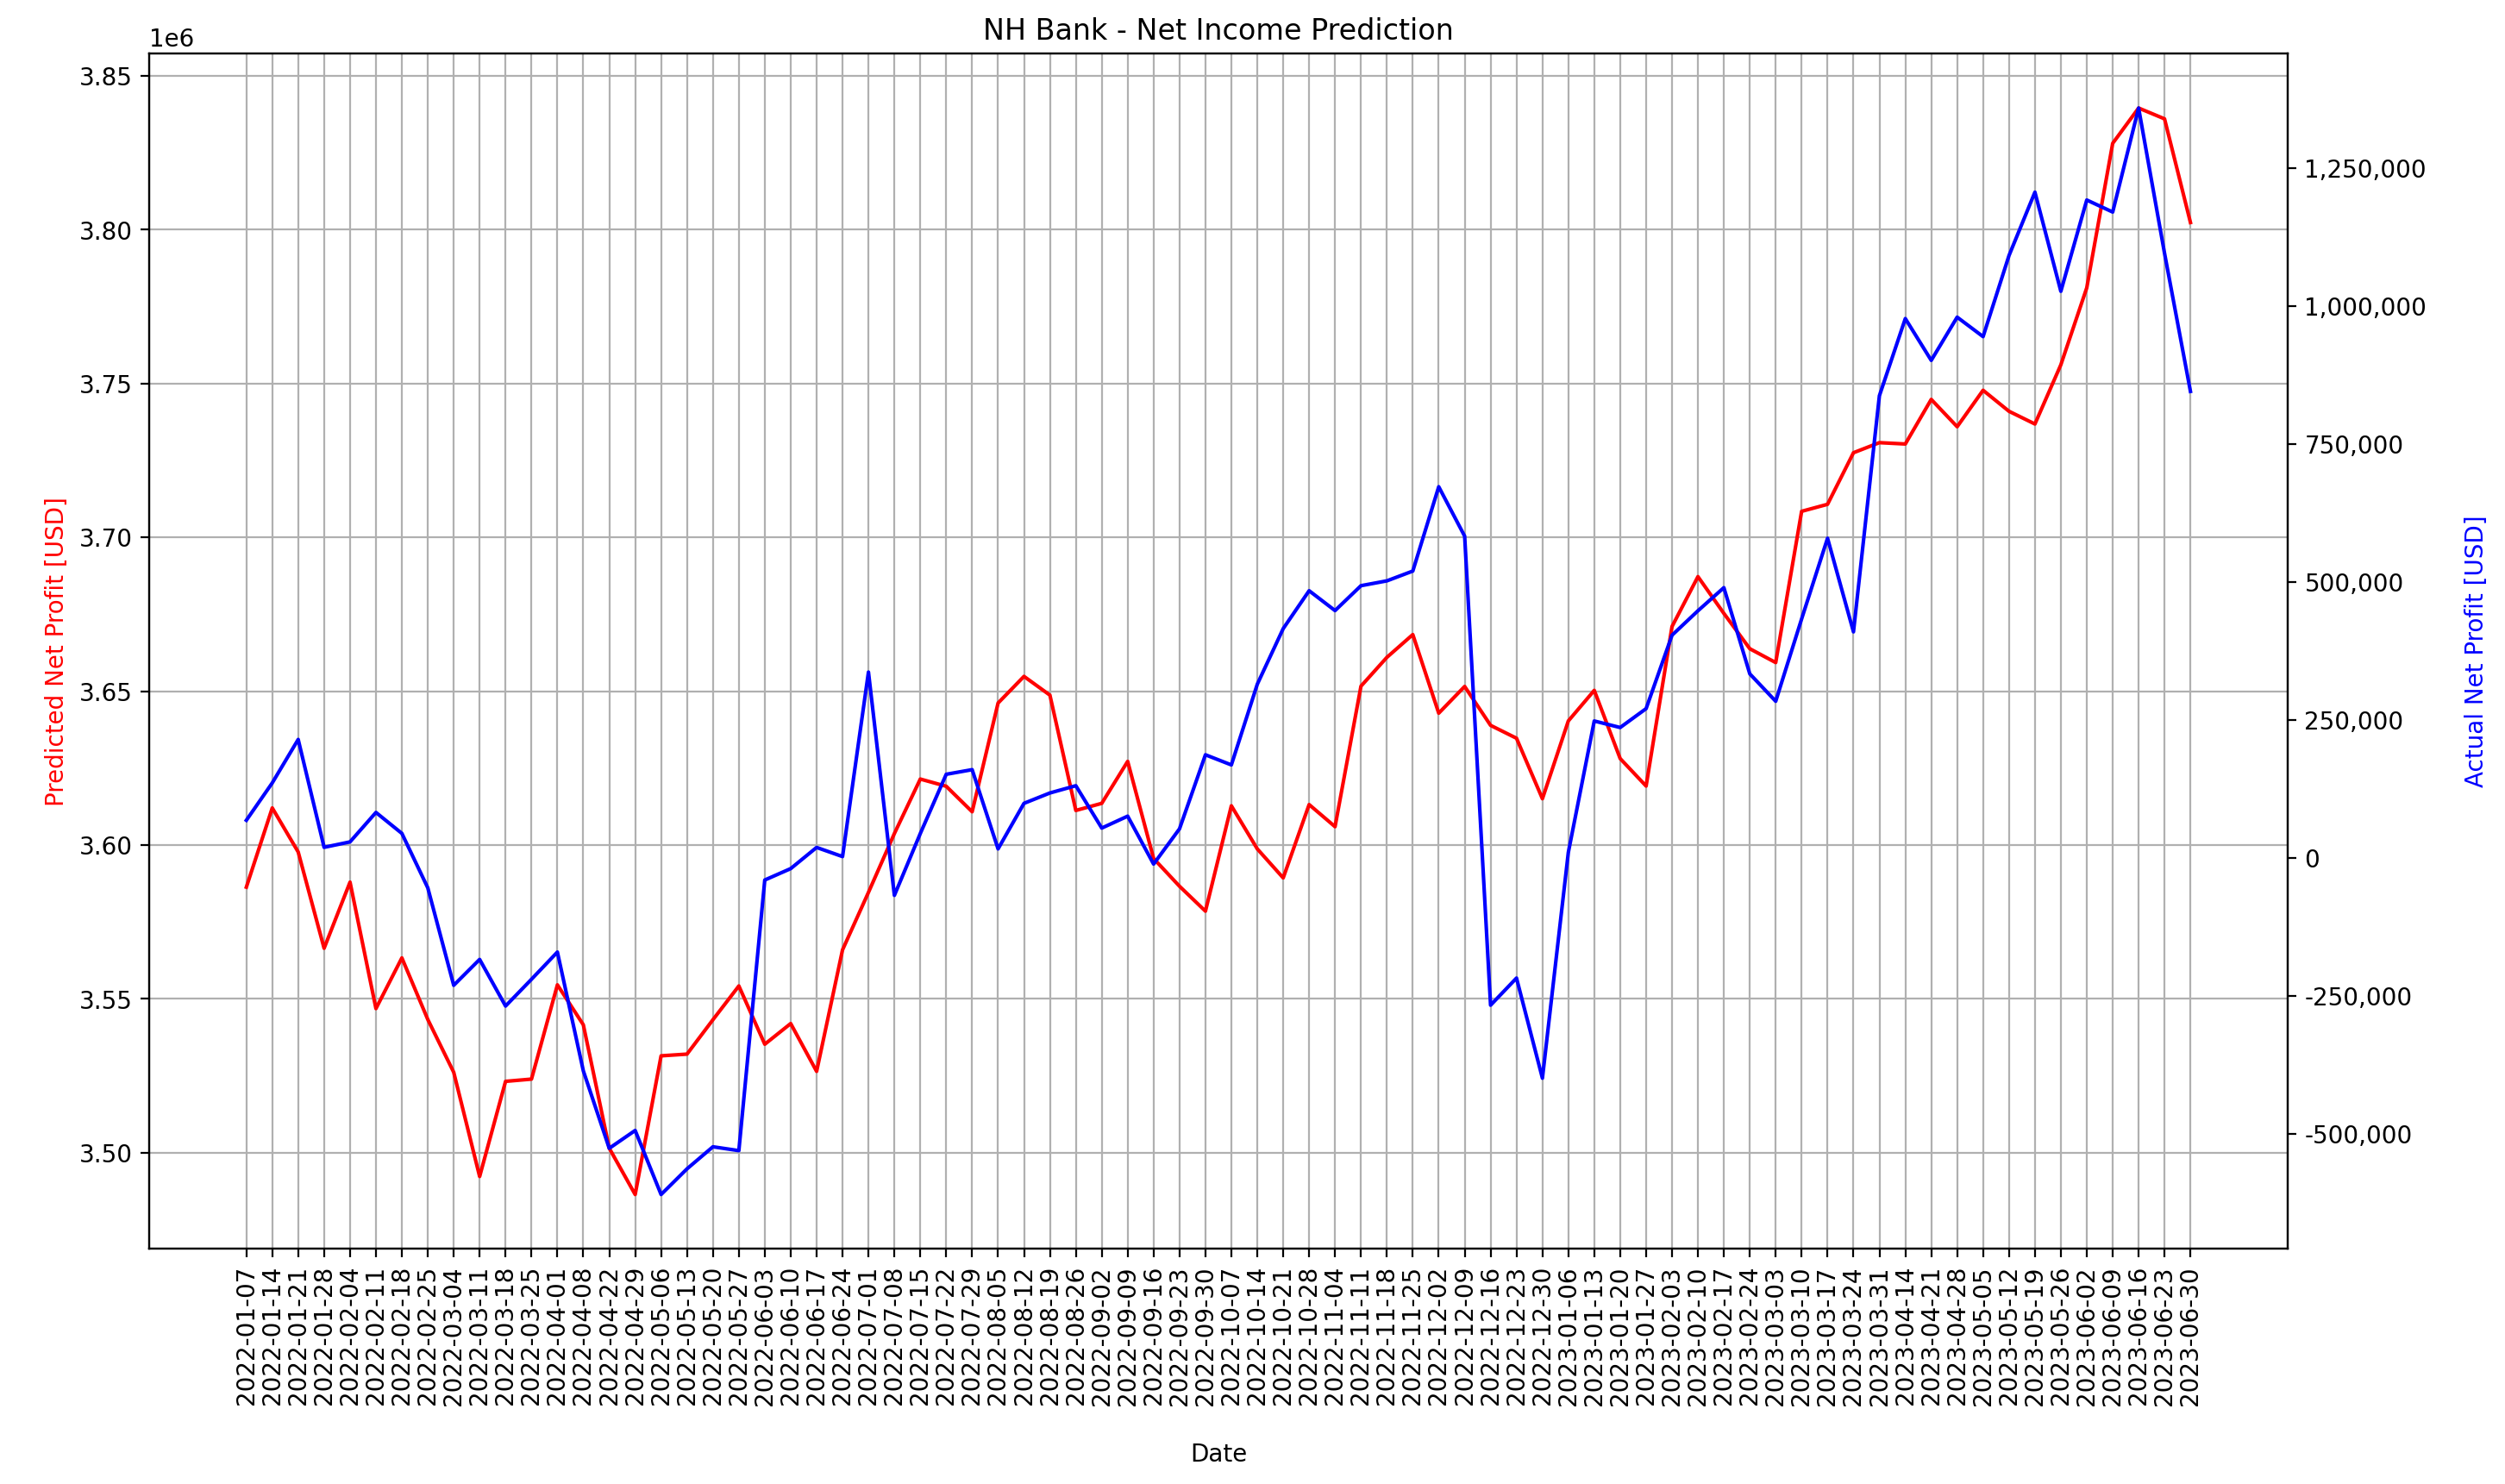



#################################
• No. Observations: 74 records
• Most recent date: 2023-06-30
• Poly degree: 1
• R squared: 0.7594773749272068
• MSE: 35945141340.95599
• Prediction: 1182339.9473250094
#################################


In [33]:
import statsmodels.api as sm
df['intercept'] = 1
lm = sm.OLS(df['NET PROFIT(LOSS) AFTER TAXES'], df[['intercept', 'Stock_price', 'Cpi', 'Jclaim', 'Inf', 'Dollar']])
results = lm.fit()

df_s = df.drop(['NET PROFIT(LOSS) AFTER TAXES'], axis = 1)
coef = results.params[1:].reset_index().rename(columns = {0:'coef'})
df_s = df_s.drop(columns = 'intercept')
for column in df_s.columns.tolist()[1:]:
    df_s[column] = df_s[column] * coef[coef['index'] == column].values.tolist()[0][1]

Average_index = df_s.drop(columns = 'Date').sum(axis = 1) / 5
sean_index = pd.DataFrame()
sean_index['Date'] = df.Date
sean_index['Average_index'] = Average_index
sean_index = sean_index.reset_index(drop = True)
# sean_index.to_csv('sean_index.csv', index = False)
# snp500_today = pred_lr(df_predict)

sean_index_plot = sean_index
sean_index_plot = pd.merge(sean_index_plot, df, on = 'Date', how = 'left')

# date type change
date_list = []
for i in range(len(sean_index_plot['Date'])):
    date_list.append(sean_index_plot['Date'][i].strftime("%Y-%m-%d"))
sean_index_plot['Date'] = date_list

# plot
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
#     sean_index_plot['Date'] = sean_index_plot['Date'].astype('datetime64[ns]')
ax.plot(sean_index_plot['Date'], sean_index_plot['Average_index'], color = 'red')
ax.set_xlabel('\nDate')
ax.set_ylabel('\nPredicted Net Profit [USD]', color = 'red')
# ax.axvline(x = 1, color = 'black', linestyle = '--')
ax.grid()
ax1 = ax.twinx()
ax1.plot(sean_index_plot['Date'], sean_index_plot['NET PROFIT(LOSS) AFTER TAXES'], color = 'blue')
ax1.set_ylabel('\nActual Net Profit [USD]', color = 'blue')
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(sean_index_plot['Date'], rotation = 90)
plt.title('NH Bank - Net Income Prediction')
plt.show()

# prediction
result = pred_lr(df)

print('\n\n#################################')
print(f'• No. Observations: {result[0]} records')
print(f'• Most recent date: {str(df[-1:].Date.values[0])[:-19]}')
print(f'• Poly degree: {result[1]}')
print(f'• R squared: {result[2]}')
print(f'• MSE: {result[3]}')
print(f'• Prediction: {result[4]}')    
print('#################################')

## Accuracy

In [34]:
# prediction accuracy
sean_index_plot['Date'] = sean_index_plot['Date'].astype('datetime64[ns]')
df = sean_index_plot
df.loc[df['Average_index'].shift(-1).diff() > 0, 'sean_diff'] = 1
df.loc[df['Average_index'].shift(-1).diff() <= 0, 'sean_diff'] = 0
df.loc[df['NET PROFIT(LOSS) AFTER TAXES'].shift(-1).diff() > 0, 'snp_diff'] = 1
df.loc[df['NET PROFIT(LOSS) AFTER TAXES'].shift(-1).diff() <= 0, 'snp_diff'] = 0
df.loc[df['sean_diff'] == df['snp_diff'], 'Accuracy'] = 1
df.loc[df['sean_diff'] != df['snp_diff'], 'Accuracy'] = 0
prediction_accuracy = df.Accuracy.mean()*100
if df[-2:].Average_index.diff().values[-1] > 0:
    prediction_result = 'Up'
else:
    prediction_result = 'Down'
print('==============[Result]==============')
# print(' • S&P 500 Actual:          ' + '%.2f' %analysis_price('^GSPC')[4])
# print(' • S&P 500 Prediction:      ' + '%.2f' %snp500_today)
print(' • Prediction Accuracy[%]:  ' + '%.2f' %prediction_accuracy)
print(' • Prediction Result:       ' + '\033[1m' + prediction_result + '\033[0m')
print('====================================')

==============[Result]==============
 • Prediction Accuracy[%]:  48.68
 • Prediction Result:       Down
